## Importacion de librerias

In [ ]:
import pickle
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

# **Contenido del dataset UjiIndoorLoc**

* Atributos 001 a 520 (WAP001-WAP520): Valor de intensidad para WAP001.
Valores enteros negativos de -104 a 0 y +100. Se utiliza el valor positivo 100
si no se detecta WAP001.

* Atributo 521 (Longitud): Longitud. Valores reales negativos de
-7695.9387549299299000 a -7299.786516730871000

* Atributo 522 (Latitud): Latitud. Valores reales positivos desde 4864745.7450159714 hasta 4865017.3646842018.

* Atributo 523 (Piso): Altitud en pisos dentro del edificio.
Valores enteros de 0 a 4.

* Atributo 524 (BuildingID): ID para identificar el edificio.
Se tomaron medidas en tres edificios diferentes. Valores enteros categóricos
de 0 a 2.

* Atributo 525 (SpaceID): Número de identificación interno para identificar el Espacio (oficina, pasillo, aula) donde se realizó la captura. Valores enteros categóricos.

* Atributo 526 (RelativePosition): Posición relativa con respecto al Espacio (1 - Interior, 2 - Exterior delante de la puerta). Valores enteros categóricos.

* Atributo 527 (ID de usuario): Identificador de usuario (ver más abajo). Valores enteros categóricos.

* Atributo 528 (PhoneID): identificador del dispositivo Android (ver más abajo). Valores enteros categóricos.

* Atributo 529 (Marca de tiempo): Hora UNIX en la que se realizó la captura. Valor entero.

## Lectura de los datos

### Se realiza la lectura del conjunto tanto de entrenamiento como de prueba para unirlos y segmentar los datos en un porcentaje 80/20. 80% Entrenamiento y 20% Pruebas

In [ ]:
# !wget https://github.com/ccamachosa31/IAProyectoDL/raw/main/UjiIndoorLocData-20230923T015119Z-001.zip
# !unzip /content/UjiIndoorLocData-20230923T015119Z-001.zip

In [ ]:
data_train = pd.read_csv("https://raw.githubusercontent.com/ccamachosa31/IAProyectoDL/main/Data/UjiIndoorLocData/trainingData.csv")
print(len(data_train))
data_test =  pd.read_csv("https://raw.githubusercontent.com/ccamachosa31/IAProyectoDL/main/Data/UjiIndoorLocData/validationData.csv")
print(len(data_test))
data_full = pd.concat([data_train,data_test])
data_full.info()

19937
1111
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21048 entries, 0 to 1110
Columns: 529 entries, WAP001 to TIMESTAMP
dtypes: float64(2), int64(527)
memory usage: 85.1 MB


In [ ]:
data, data_test = train_test_split(data_full, test_size=0.2, random_state=42)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16838 entries, 16667 to 15795
Columns: 529 entries, WAP001 to TIMESTAMP
dtypes: float64(2), int64(527)
memory usage: 68.1 MB


### La base de datos que se toma para todo el proceso hasta el entrenamiento contiene 16838 registros

## Informacion de dataset (cantidad de registros, cantidad de columnas, tipos de datos de las columnas)

### Las columnas 'USERID' y 'PhoneID' no son relevantes pra el modelo ya que no se requiere conocer como se obtuvieron los datos y la columna 'TIMESTAMP' tampoco sera util ya que no se va a trabajar con tiempos

In [ ]:
data.drop(columns=['TIMESTAMP','USERID','PHONEID'],inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16838 entries, 16667 to 15795
Columns: 526 entries, WAP001 to RELATIVEPOSITION
dtypes: float64(2), int64(524)
memory usage: 67.7 MB


## Verificacion de las columnas en busca de datos nulos o vacios

In [ ]:
steps = range(0,len(data.columns),100)
for ind,val in enumerate(steps):
  if ind + 1 == len(steps):
    print(data[data.columns[steps[ind]:]].info())
  else:
    print(data[data.columns[steps[ind]:steps[ind+1]]].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16838 entries, 16667 to 15795
Data columns (total 100 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   WAP001  16838 non-null  int64
 1   WAP002  16838 non-null  int64
 2   WAP003  16838 non-null  int64
 3   WAP004  16838 non-null  int64
 4   WAP005  16838 non-null  int64
 5   WAP006  16838 non-null  int64
 6   WAP007  16838 non-null  int64
 7   WAP008  16838 non-null  int64
 8   WAP009  16838 non-null  int64
 9   WAP010  16838 non-null  int64
 10  WAP011  16838 non-null  int64
 11  WAP012  16838 non-null  int64
 12  WAP013  16838 non-null  int64
 13  WAP014  16838 non-null  int64
 14  WAP015  16838 non-null  int64
 15  WAP016  16838 non-null  int64
 16  WAP017  16838 non-null  int64
 17  WAP018  16838 non-null  int64
 18  WAP019  16838 non-null  int64
 19  WAP020  16838 non-null  int64
 20  WAP021  16838 non-null  int64
 21  WAP022  16838 non-null  int64
 22  WAP023  16838 non-null  int64
 23  WAP024

### No se encuentran valores nulos

## Estadisticas de las columnas

In [ ]:
steps = range(0,len(data.columns),5)
for ind,val in enumerate(steps):
  if ind + 1 == len(steps):
    print(data[data.columns[steps[ind]:]].describe())
  else:
    print(data[data.columns[steps[ind]:steps[ind+1]]].describe())

             WAP001        WAP002        WAP003        WAP004        WAP005
count  16838.000000  16838.000000  16838.000000  16838.000000  16838.000000
mean      99.770163     99.821594     99.977907     99.977907     99.657263
std        6.665987      5.785294      2.027104      2.027192      8.113281
min      -97.000000    -90.000000    -87.000000    -88.000000    -97.000000
25%      100.000000    100.000000    100.000000    100.000000    100.000000
50%      100.000000    100.000000    100.000000    100.000000    100.000000
75%      100.000000    100.000000    100.000000    100.000000    100.000000
max      100.000000    100.000000    100.000000    100.000000    100.000000
             WAP006        WAP007        WAP008        WAP009        WAP010
count  16838.000000  16838.000000  16838.000000  16838.000000  16838.000000
mean      97.243616     95.205725     93.683870     94.537178     99.123827
std       22.476409     29.193008     33.400032     30.745001     12.929841
min      -98

### 2 de las columnas WAP cuentan con los mismos datos que son el valor 100 que indica sin deteccion, esta caracteristica al ser igual para todos los registros no son relevantes para el modelo y se eliminaran

In [ ]:
columns_select = pd.DataFrame((data.mean(axis=0)!=100))
columns_select = columns_select[columns_select[0]==True].T.columns
data = data[columns_select]
data.head()

WAP001  WAP002  WAP003  WAP004  WAP005  WAP006  WAP007  WAP008  WAP009  \
16667     100     100     100     100     100     100     100     100     100   
9792      100     100     100     100     100     100     100     100     100   
3753      100     100     100     100     100     100     100     100     100   
7270      100     100     100     100     100     100     100     100     100   
4046      100     100     100     100     100     100     100     100     100   

       WAP010  ...  WAP517  WAP518  WAP519  WAP520  LONGITUDE      LATITUDE  \
16667     100  ...     100     100     100     100 -7667.3518  4.864937e+06   
9792      100  ...     -50     100     100     100 -7352.5203  4.864833e+06   
3753      100  ...     100     100     100     100 -7366.0378  4.864846e+06   
7270      100  ...     100     100     100     100 -7616.9462  4.864980e+06   
4046      100  ...     100     100     100     100 -7316.8672  4.864814e+06   

       FLOOR  BUILDINGID  SPACEID  RELATIVEPOSITION  
16667      1           0      216                 2  
9792       2           2      125                 2  
3753       1           2      107                 2  
7270       2           0      115                 2  
4046       1           2      131                 2  

[5 rows x 520 columns]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16838 entries, 16667 to 15795
Columns: 520 entries, WAP001 to RELATIVEPOSITION
dtypes: float64(2), int64(518)
memory usage: 66.9 MB


In [ ]:
data[data[data.columns[:-6]].mean(axis=1)==100]

WAP001  WAP002  WAP003  WAP004  WAP005  WAP006  WAP007  WAP008  WAP009  \
19369     100     100     100     100     100     100     100     100     100   
4880      100     100     100     100     100     100     100     100     100   
4745      100     100     100     100     100     100     100     100     100   
5046      100     100     100     100     100     100     100     100     100   
19448     100     100     100     100     100     100     100     100     100   
19387     100     100     100     100     100     100     100     100     100   
19427     100     100     100     100     100     100     100     100     100   
5101      100     100     100     100     100     100     100     100     100   
4812      100     100     100     100     100     100     100     100     100   
4856      100     100     100     100     100     100     100     100     100   
5094      100     100     100     100     100     100     100     100     100   
5058      100     100     100     100     100     100     100     100     100   
4723      100     100     100     100     100     100     100     100     100   
4901      100     100     100     100     100     100     100     100     100   
4849      100     100     100     100     100     100     100     100     100   
4929      100     100     100     100     100     100     100     100     100   
4685      100     100     100     100     100     100     100     100     100   
83        100     100     100     100     100     100     100     100     100   
4721      100     100     100     100     100     100     100     100     100   
4826      100     100     100     100     100     100     100     100     100   
4716      100     100     100     100     100     100     100     100     100   
4649      100     100     100     100     100     100     100     100     100   
4756      100     100     100     100     100     100     100     100     100   
18654     100     100     100     100     100     100     100     100     100   
5134      100     100     100     100     100     100     100     100     100   
4928      100     100     100     100     100     100     100     100     100   
4803      100     100     100     100     100     100     100     100     100   
4793      100     100     100     100     100     100     100     100     100   
4701      100     100     100     100     100     100     100     100     100   
5108      100     100     100     100     100     100     100     100     100   
5114      100     100     100     100     100     100     100     100     100   
4655      100     100     100     100     100     100     100     100     100   
4636      100     100     100     100     100     100     100     100     100   
5095      100     100     100     100     100     100     100     100     100   
5065      100     100     100     100     100     100     100     100     100   
4         100     100     100     100     100     100     100     100     100   
18744     100     100     100     100     100     100     100     100     100   
5127      100     100     100     100     100     100     100     100     100   
4645      100     100     100     100     100     100     100     100     100   
4908      100     100     100     100     100     100     100     100     100   
4758      100     100     100     100     100     100     100     100     100   
5060      100     100     100     100     100     100     100     100     100   
18745     100     100     100     100     100     100     100     100     100   
4906      100     100     100     100     100     100     100     100     100   
3791      100     100     100     100     100     100     100     100     100   
19410     100     100     100     100     100     100     100     100     100   
19278     100     100     100     100     100     100     100     100     100   
5097      100     100     100     100     100     100     100     100     100   
4855      100     100     100     100 

### Se encuentran tambien 59 registros en los cuales las mediciones dee todos los WAP tambien indican si deteccion pero cuentan con diferentes valores en longitud, latitud y Piso lo que puede ocasionar un mal entrenamiento en el modelo, estos registros se eliminaran

In [ ]:
data = data[data[data.columns[:-6]].mean(axis=1)!=100]

## Visualizacion y Analisis de los datos

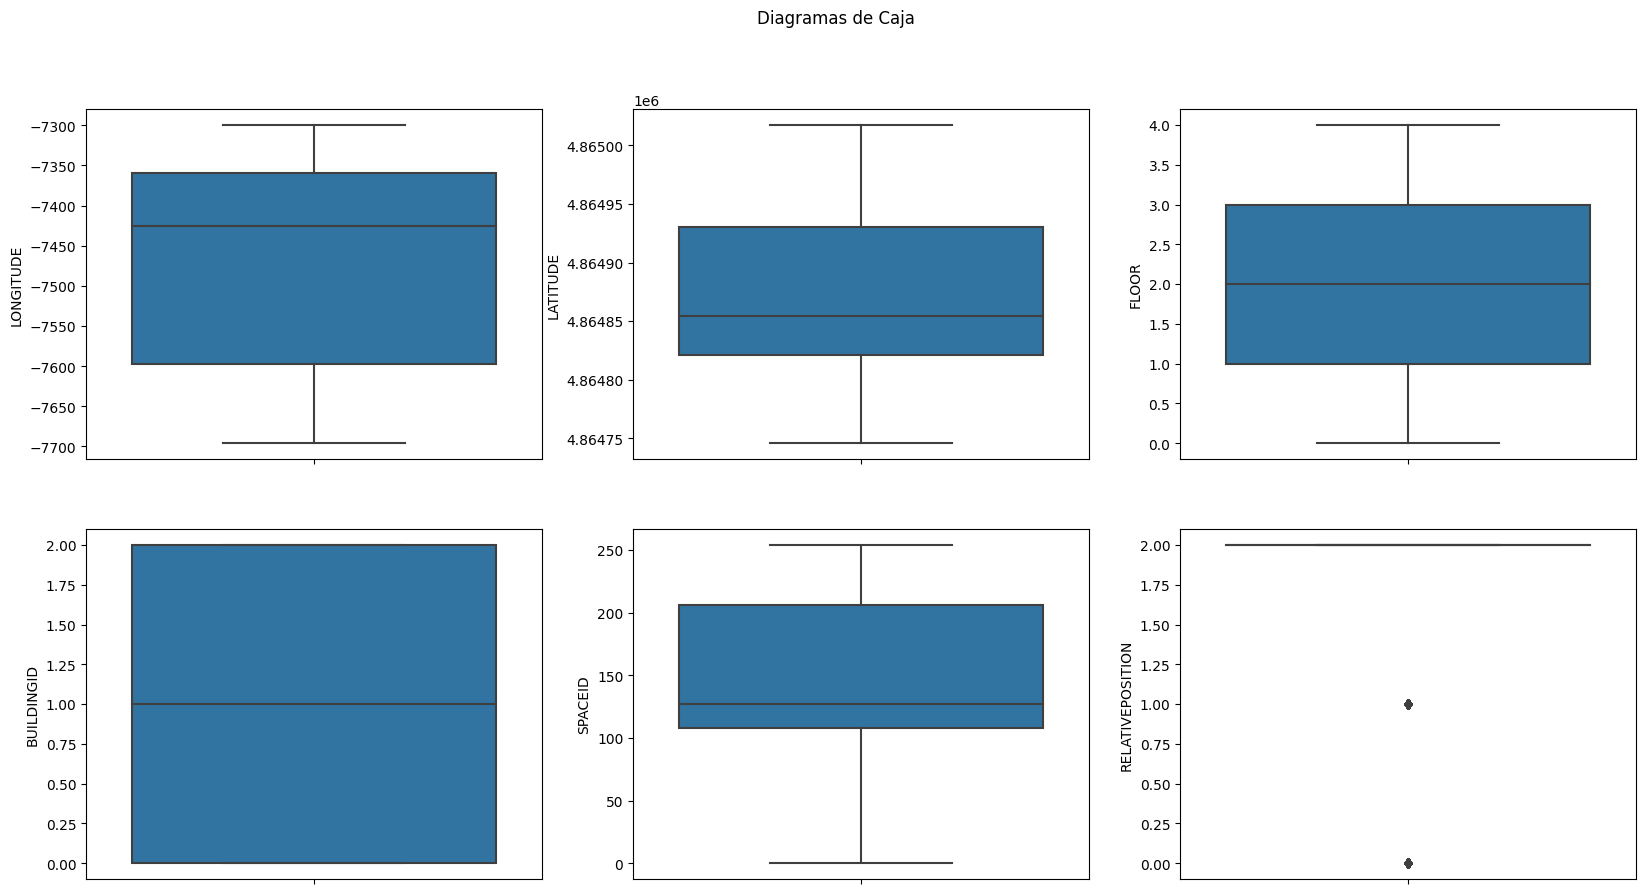

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Diagramas de Caja')
row = 0
col = 0
for ind, column in enumerate(data.columns[-6:]):
  sns.boxplot(data, y=column, ax=axes[row, col])
  if ind == 2:
    row += 1
    col = 0
  else:
    col += 1

### Dentro de las columnas que no son medicion de intensidad no se encuentran datos atipicos

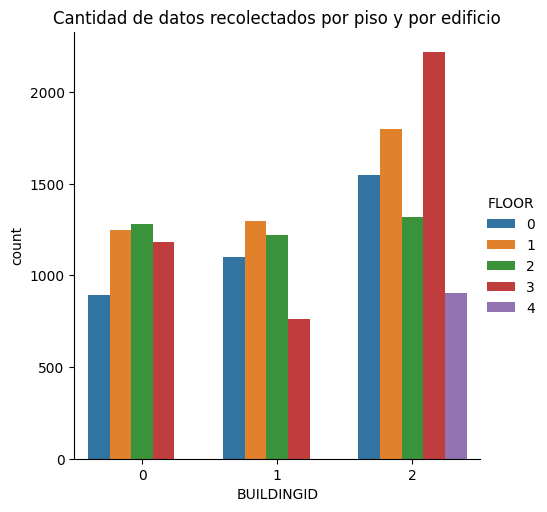

In [ ]:
sns.catplot(data, x="BUILDINGID", kind="count", hue='FLOOR')
plt.title("Cantidad de datos recolectados por piso y por edificio")
plt.show()

### Se encuentra que solamente un edificio cuenta con mediciones en el 4 piso, los otros no cuentan con esto tal vez porque no tienen un cuarto piso

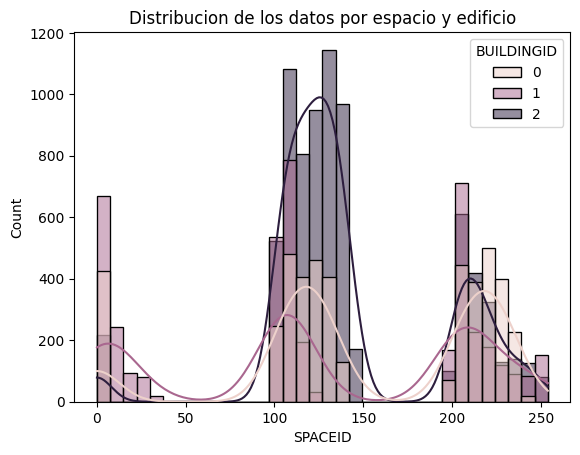

In [ ]:
sns.histplot(data, x="SPACEID", kde=True, hue='BUILDINGID')
plt.title("Distribucion de los datos por espacio y edificio")
plt.show()

### La mayor concentracion de los datos se encuentran entre los espacios del 100 al 150 y segundo relevante son del 200 al 250, no hay linealidad en la categorizacion de los espacios

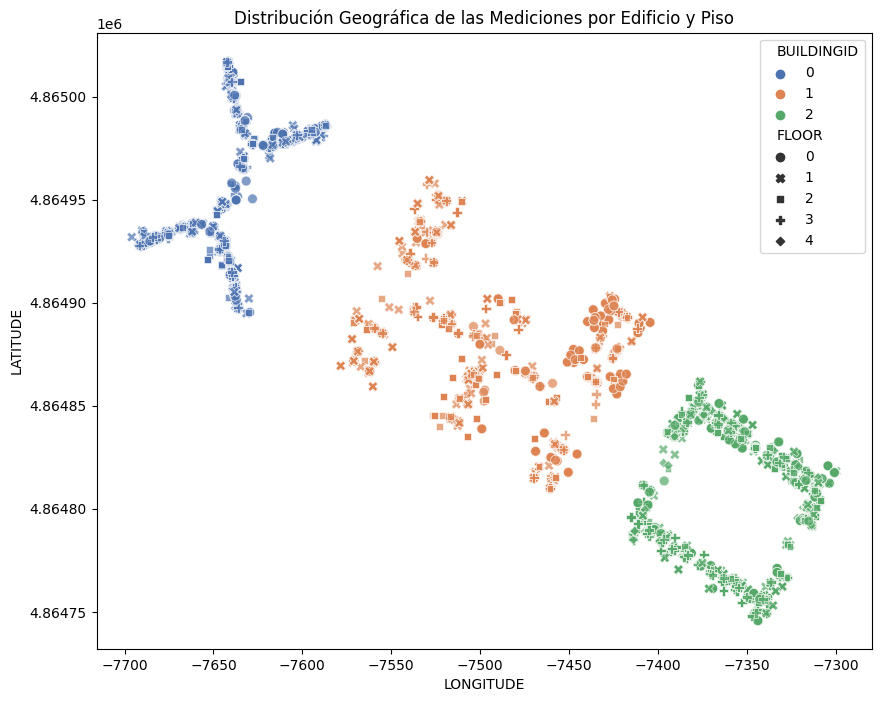

In [ ]:
# visualizar las mediciones geográficas
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='LONGITUDE', y='LATITUDE', hue='BUILDINGID', palette='deep', style='FLOOR', s=50, alpha=0.7)
plt.title("Distribución Geográfica de las Mediciones por Edificio y Piso")
plt.show()

### La distribucción también muestra una aproximación de la estructura de los edificios

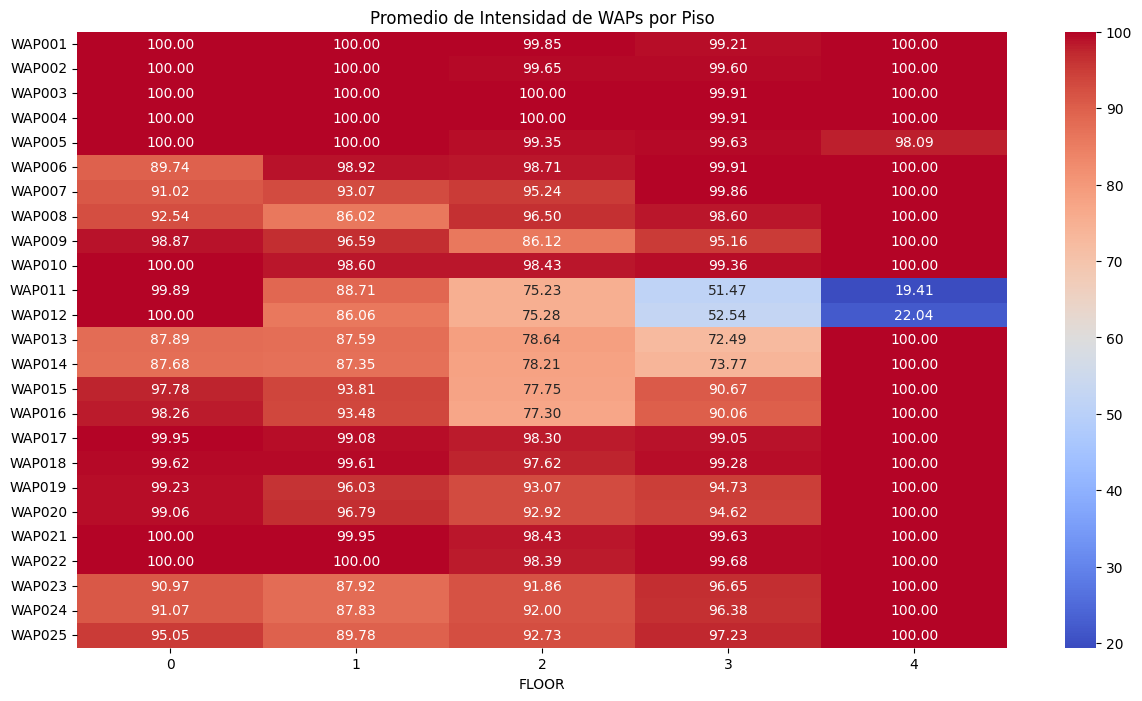

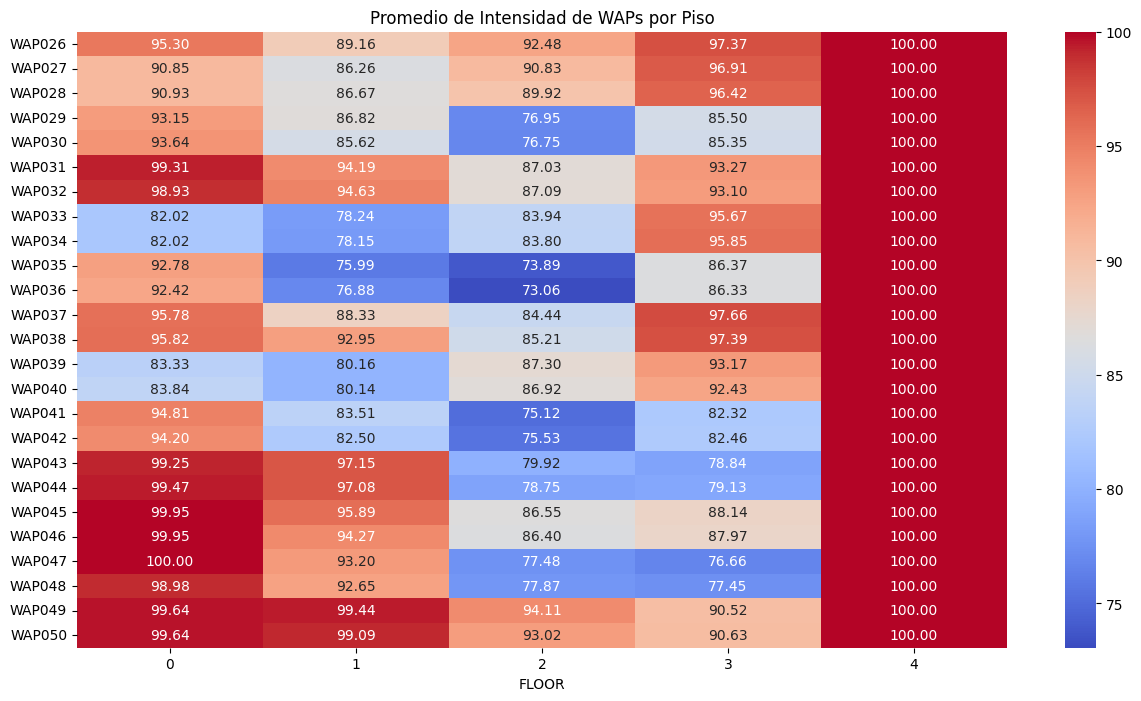

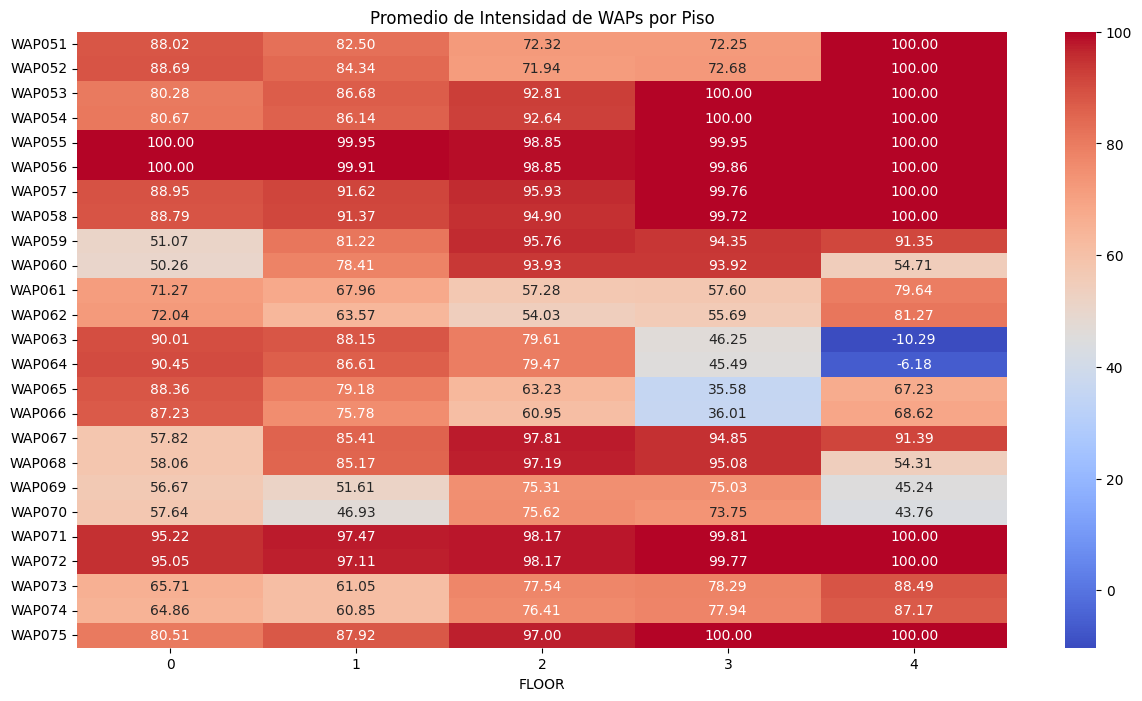

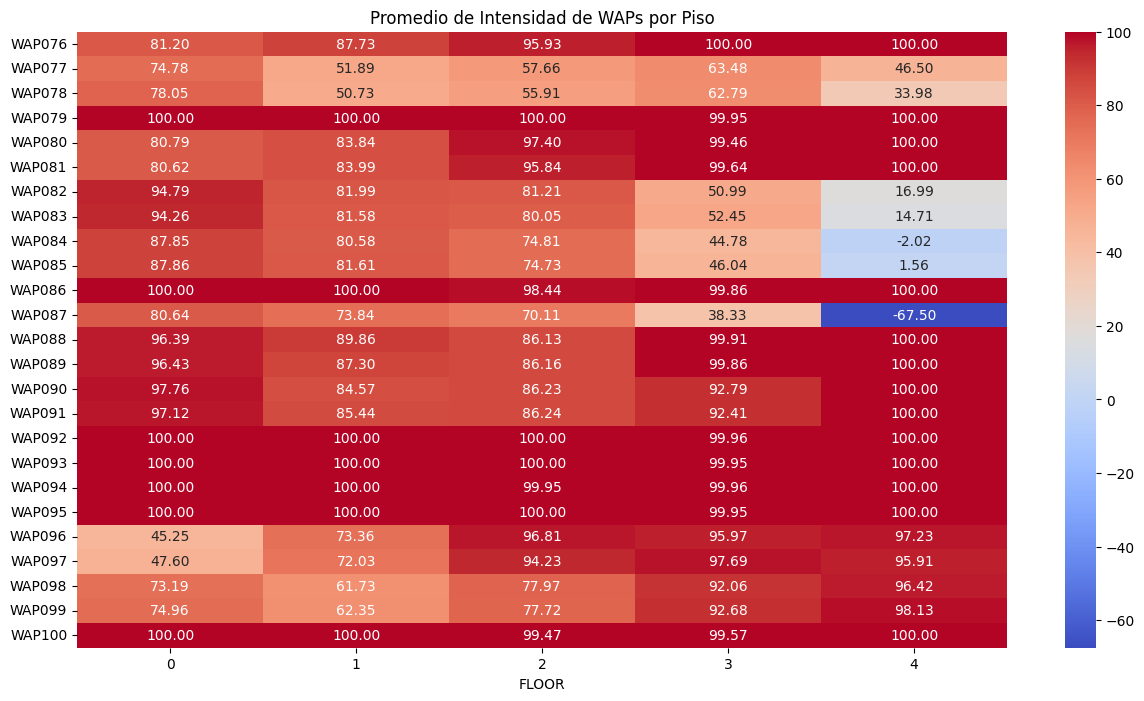

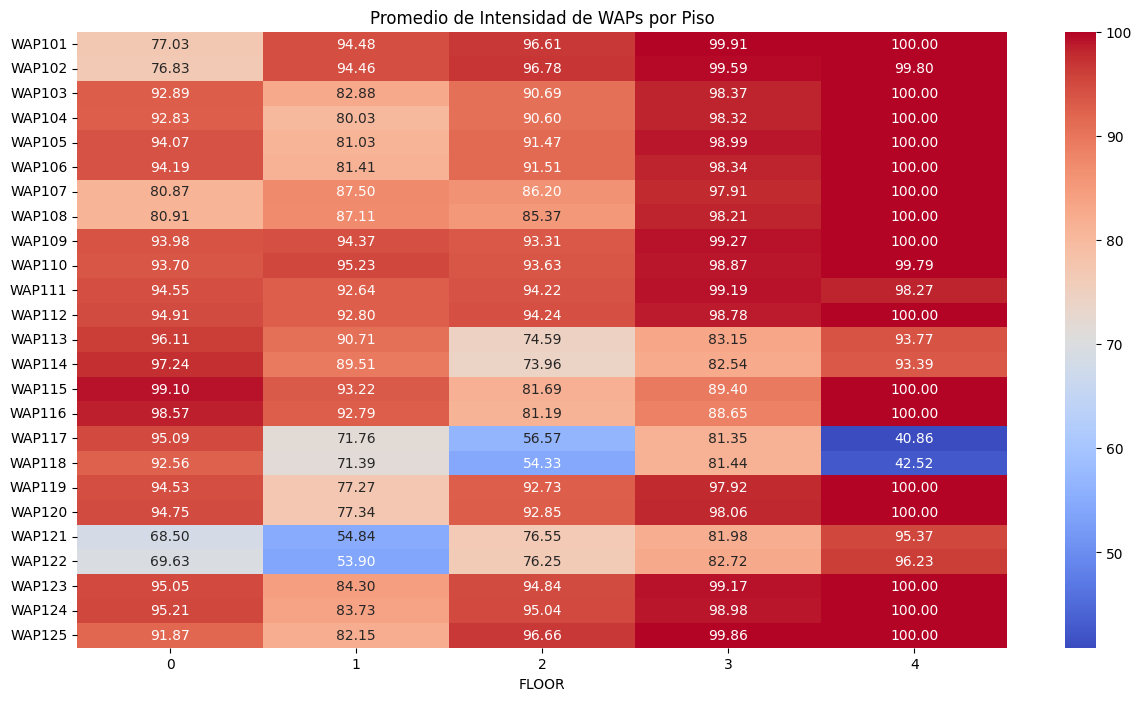

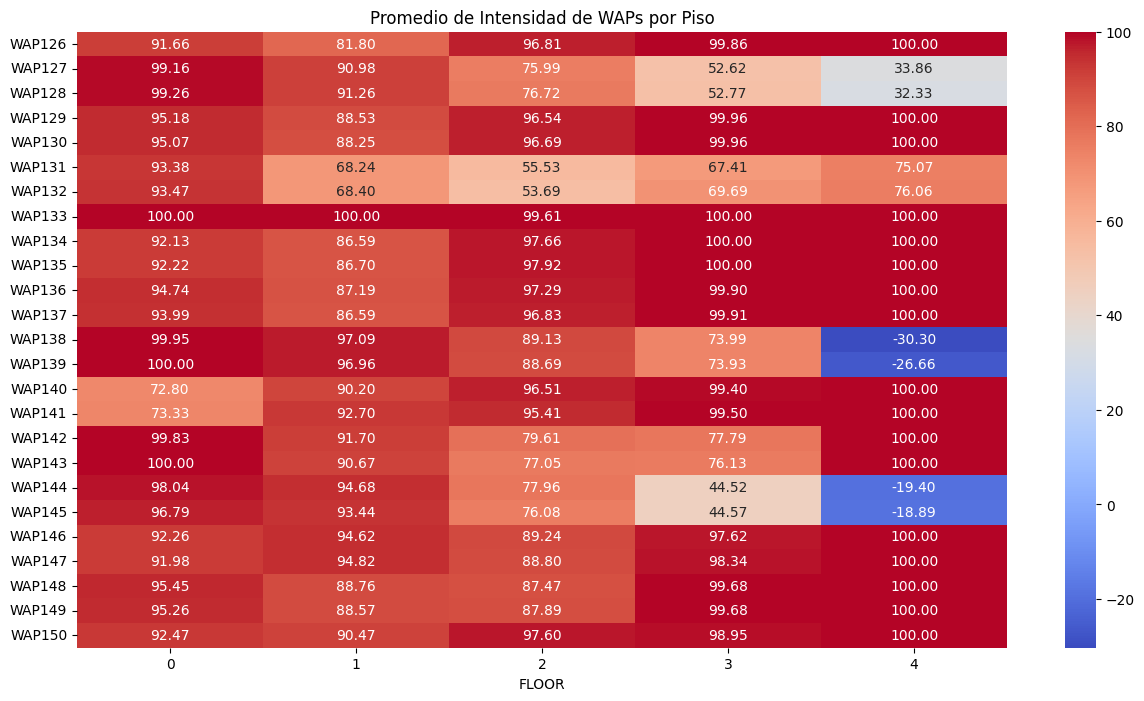

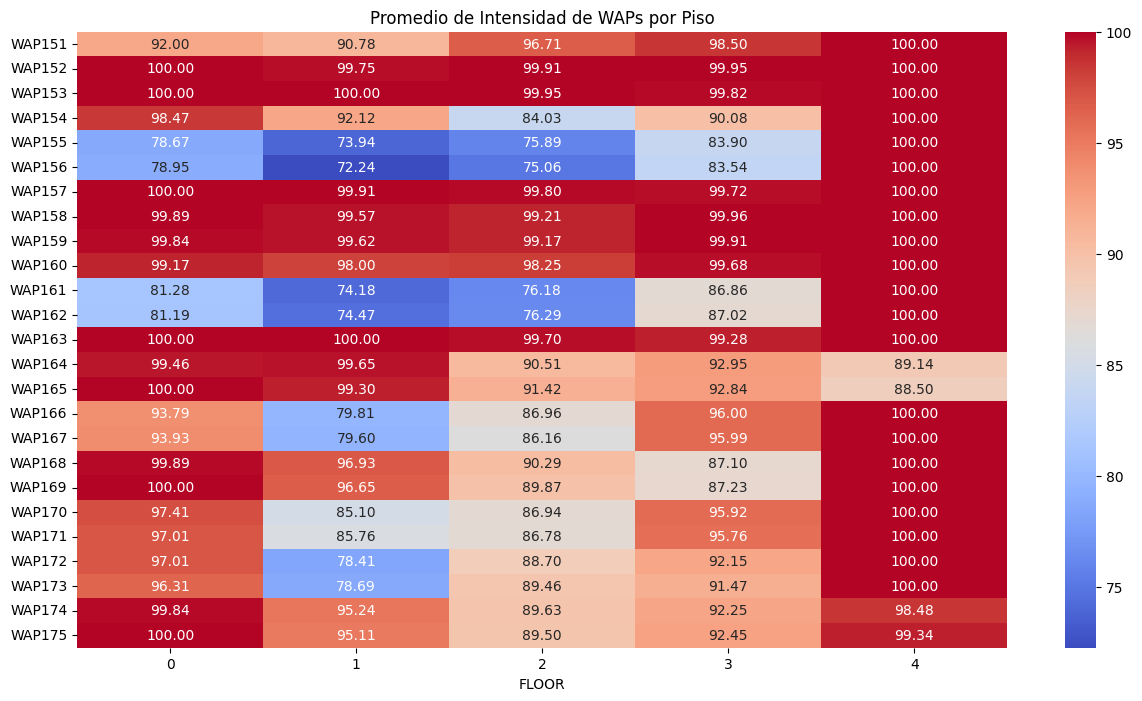

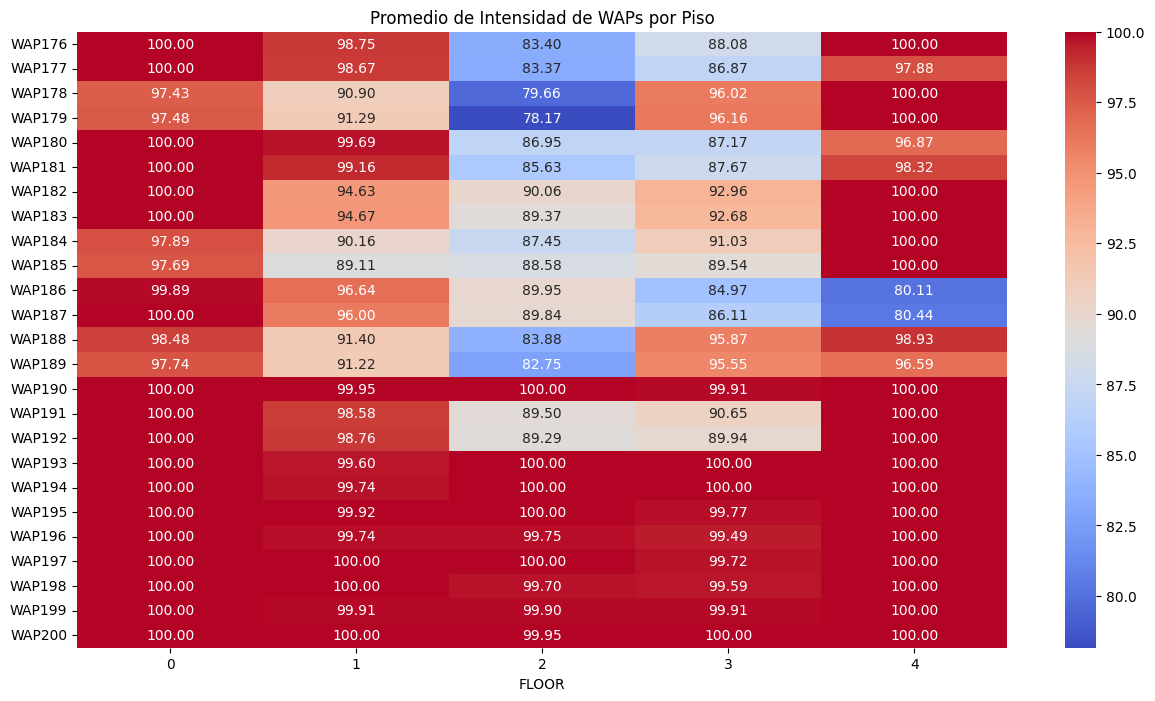

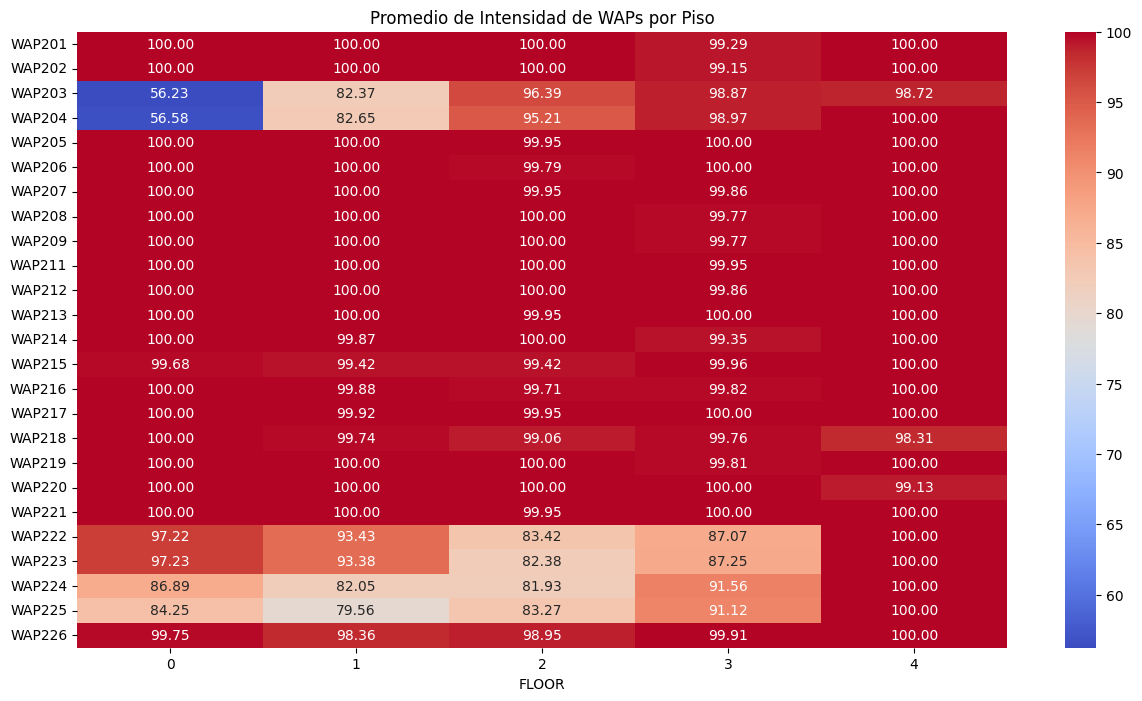

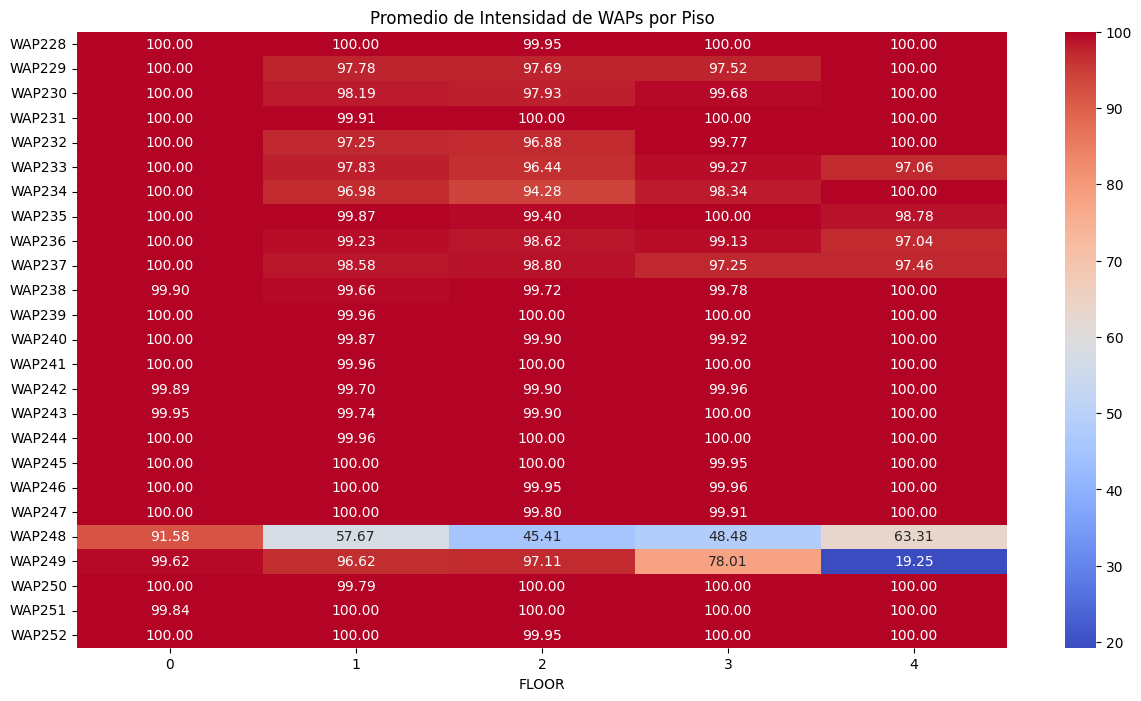

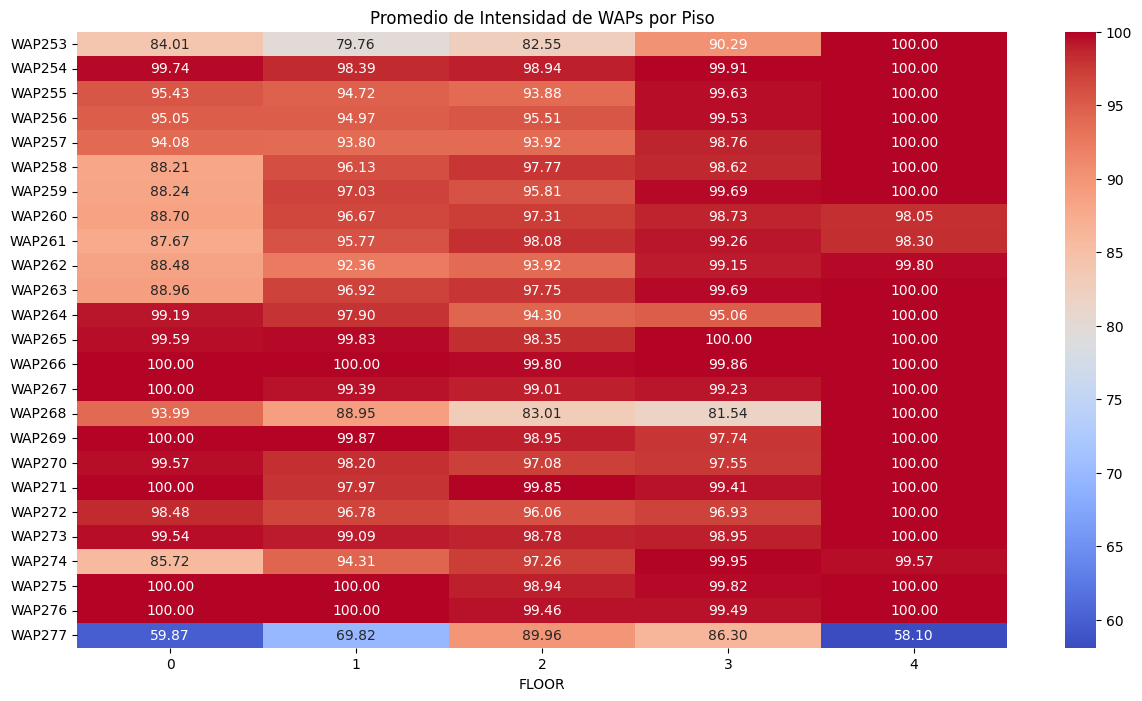

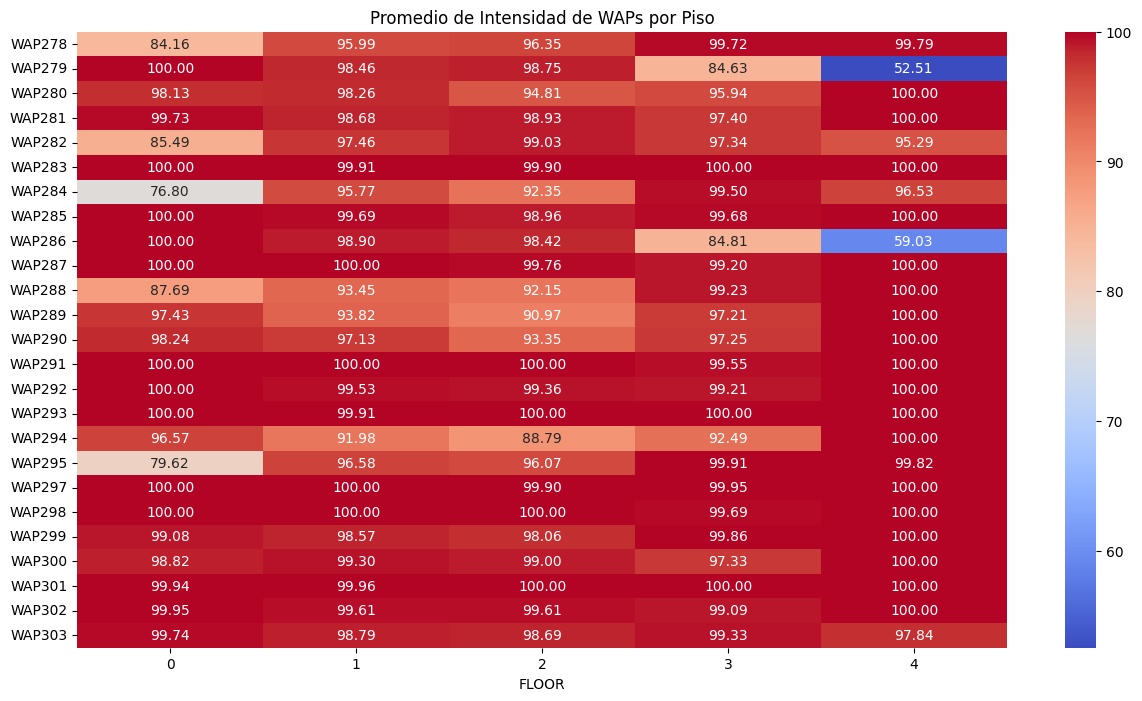

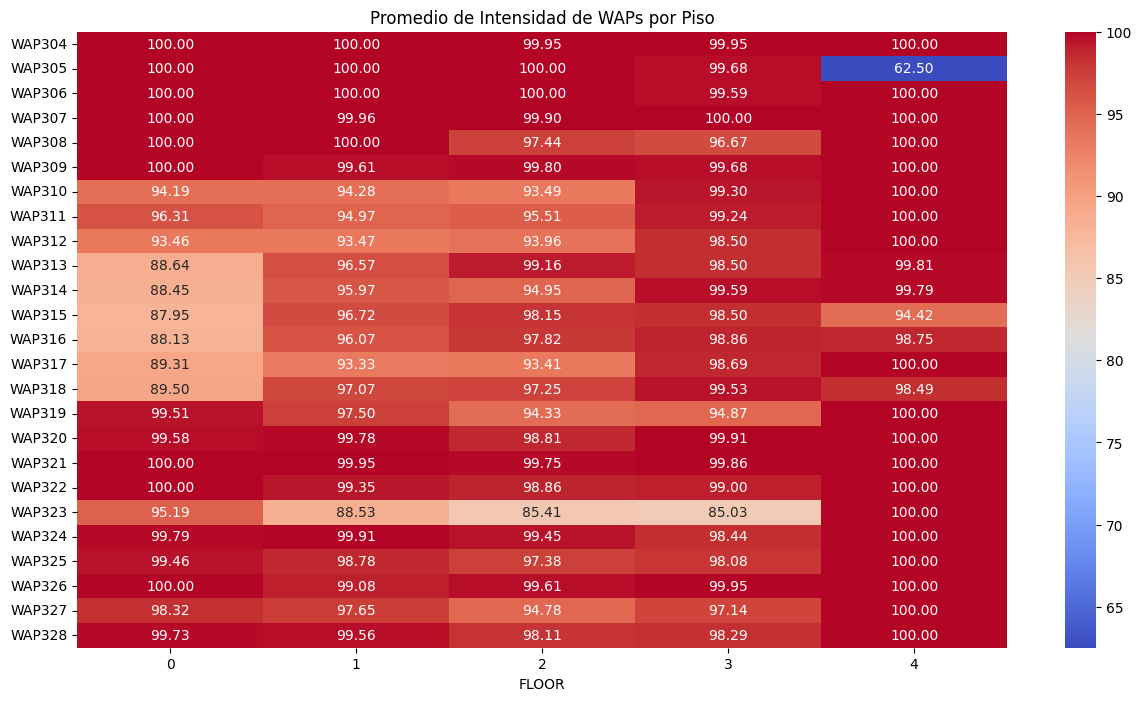

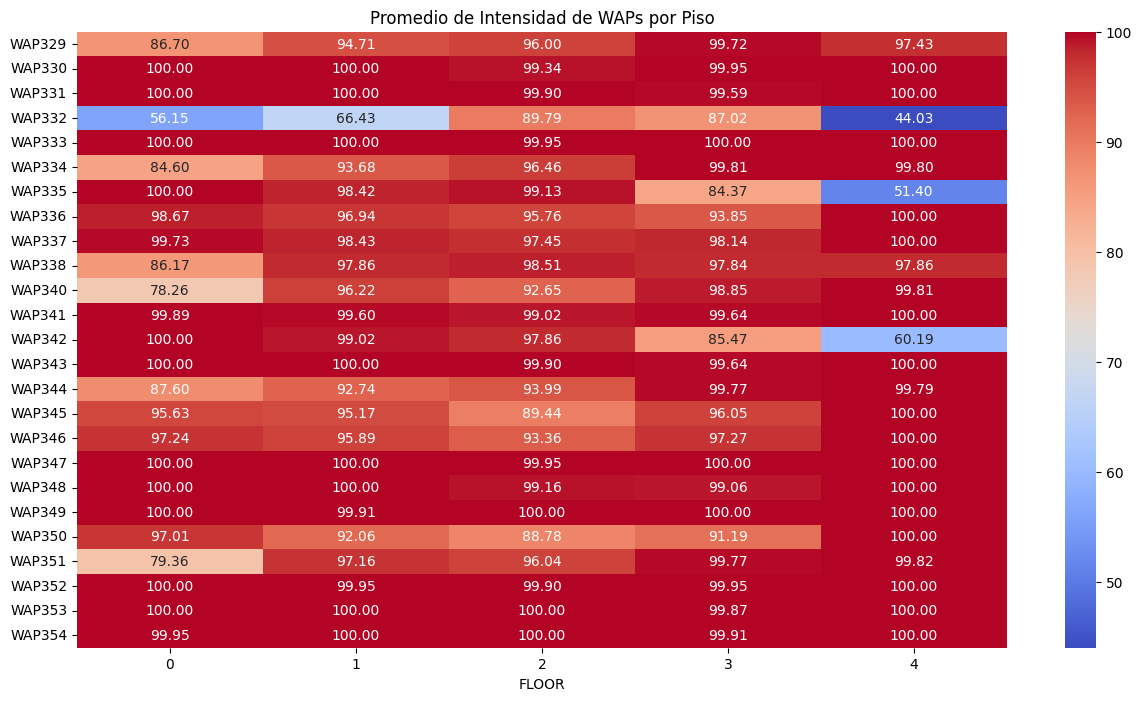

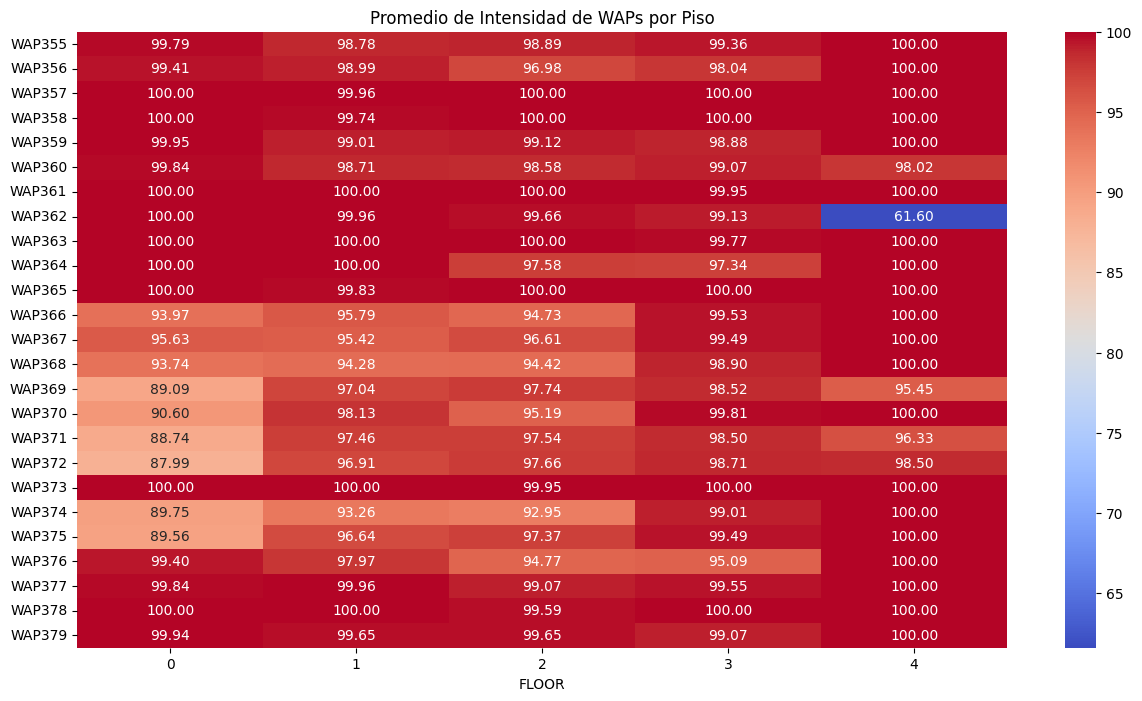

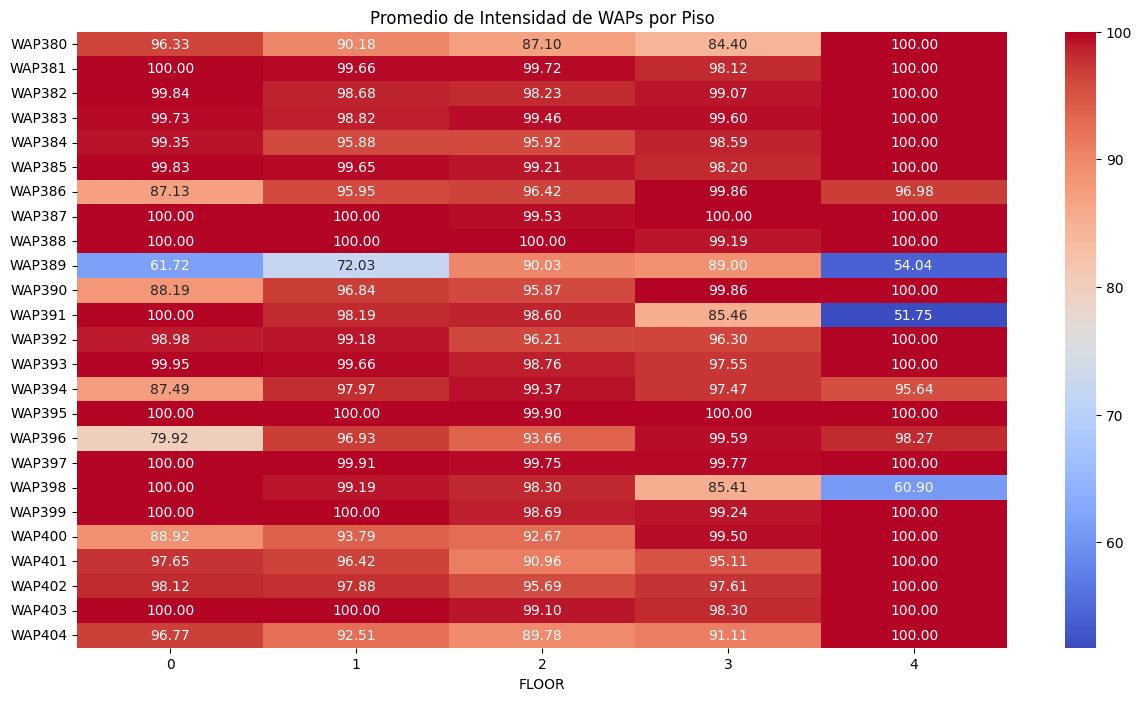

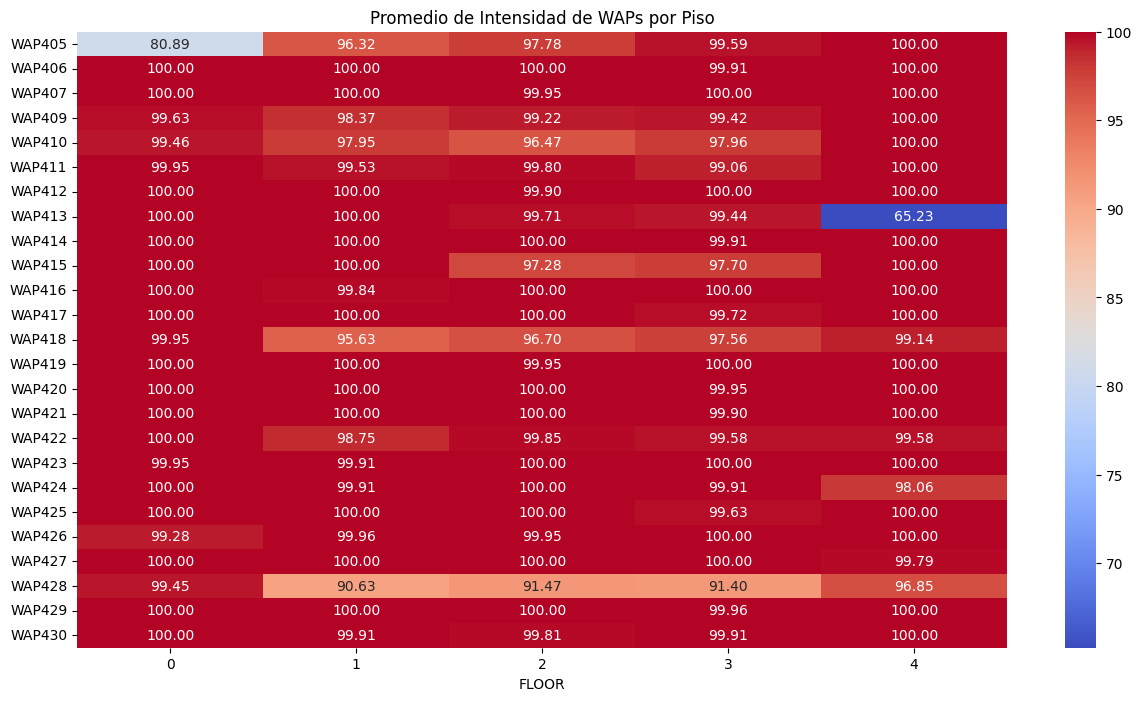

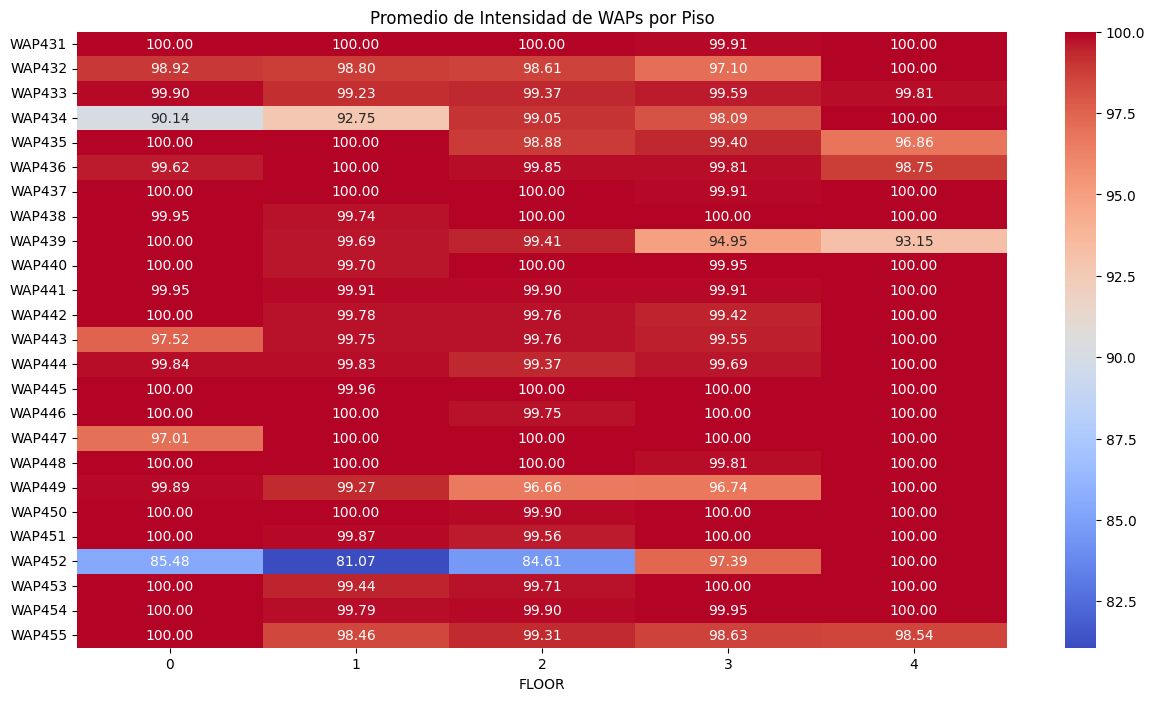

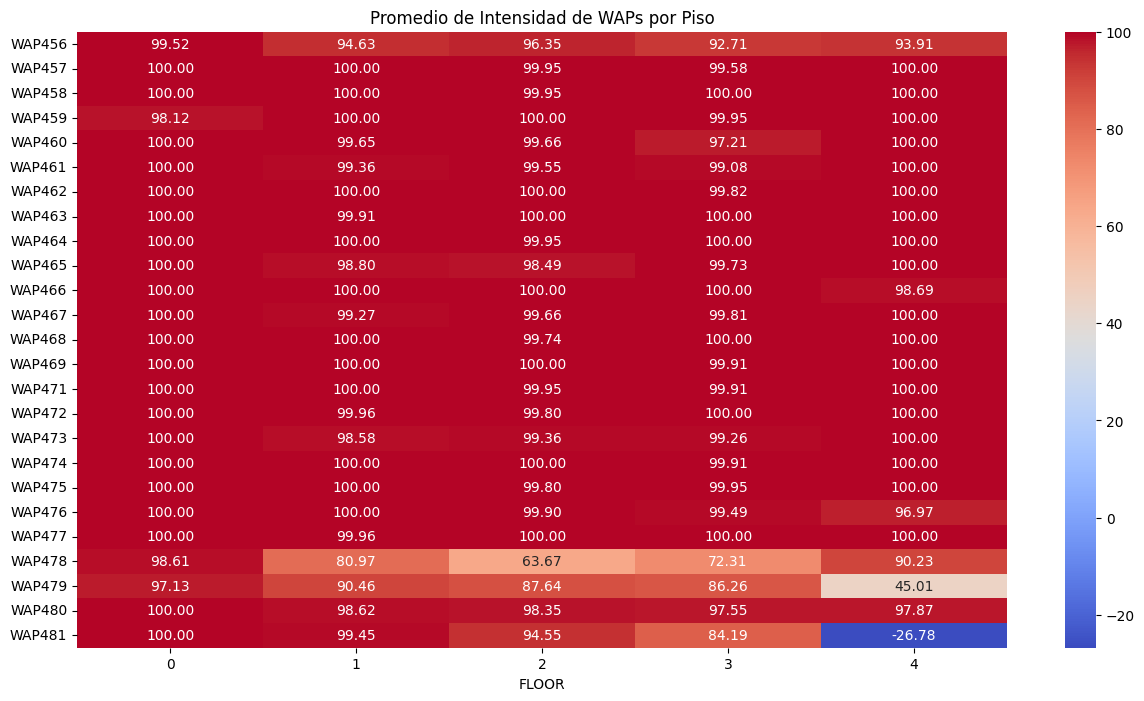

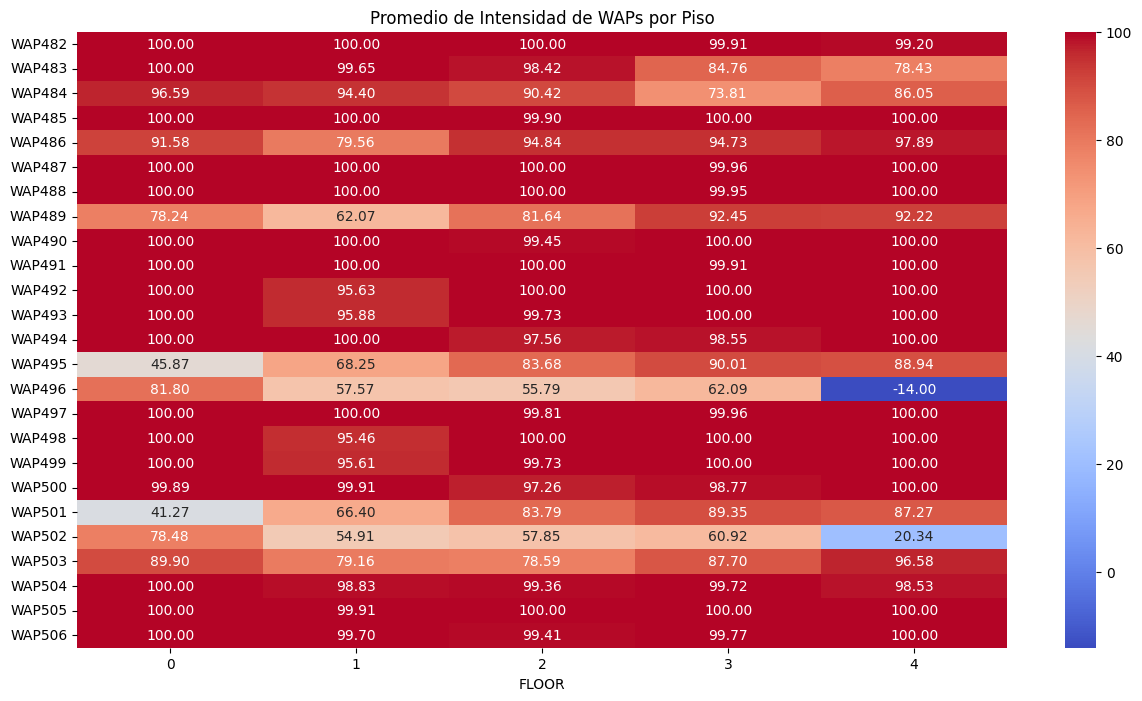

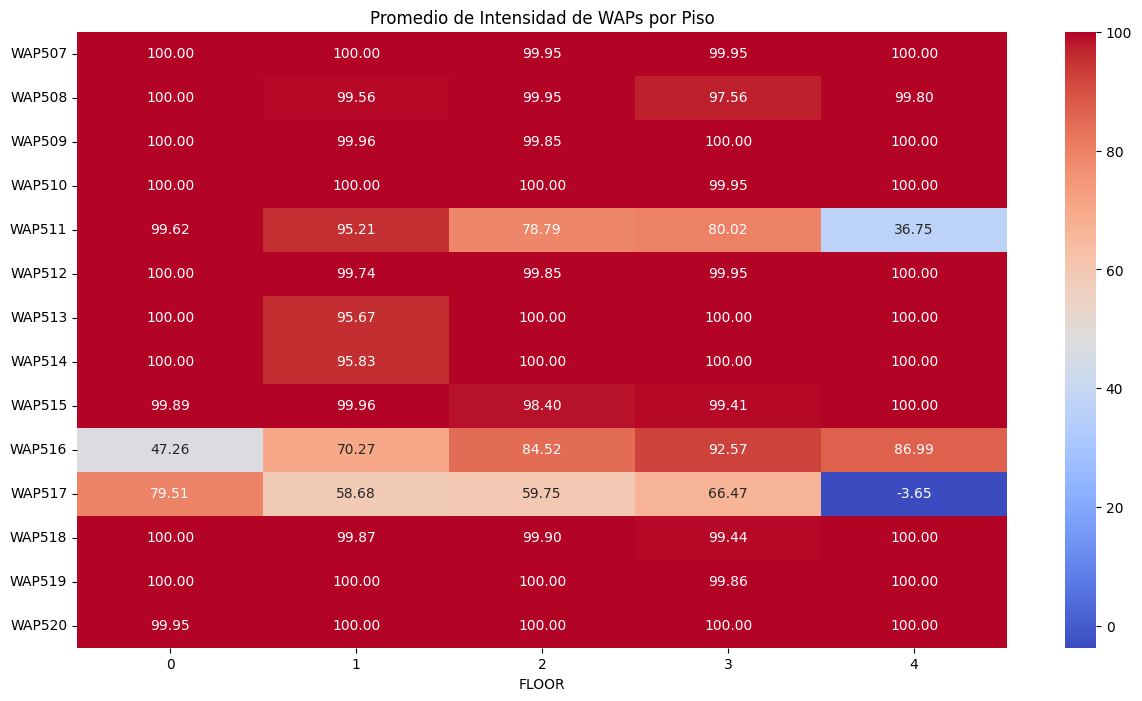

In [ ]:
heat_data = data.groupby('FLOOR')[data.columns[:-6]].mean()
for cols in np.array(data.columns[:-20]).reshape(20,25):
  heatmap_data = heat_data[cols].T
  plt.figure(figsize=(15, 8))
  sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".2f")
  plt.title("Promedio de Intensidad de WAPs por Piso")
  plt.show()

heatmap_data = heat_data[np.array(data.columns[500:-6])].T
plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Promedio de Intensidad de WAPs por Piso")
plt.show()

### Se ve que muchos de los atributos para el piso 4 su promedio es 100 debido a que solo 1 edificio cuenta con 4 pisos, esto hace que muchos dispositivos WAP no apliquen para las mediciones en este, ademas se ve que varios de estos dispositivos como lo son por ejemplo del WAP205 al WAP221 tambien tienen pocas mediciones sobre los 4 pisos, una probabilidad alta de que no sea relevantes para el modelo.

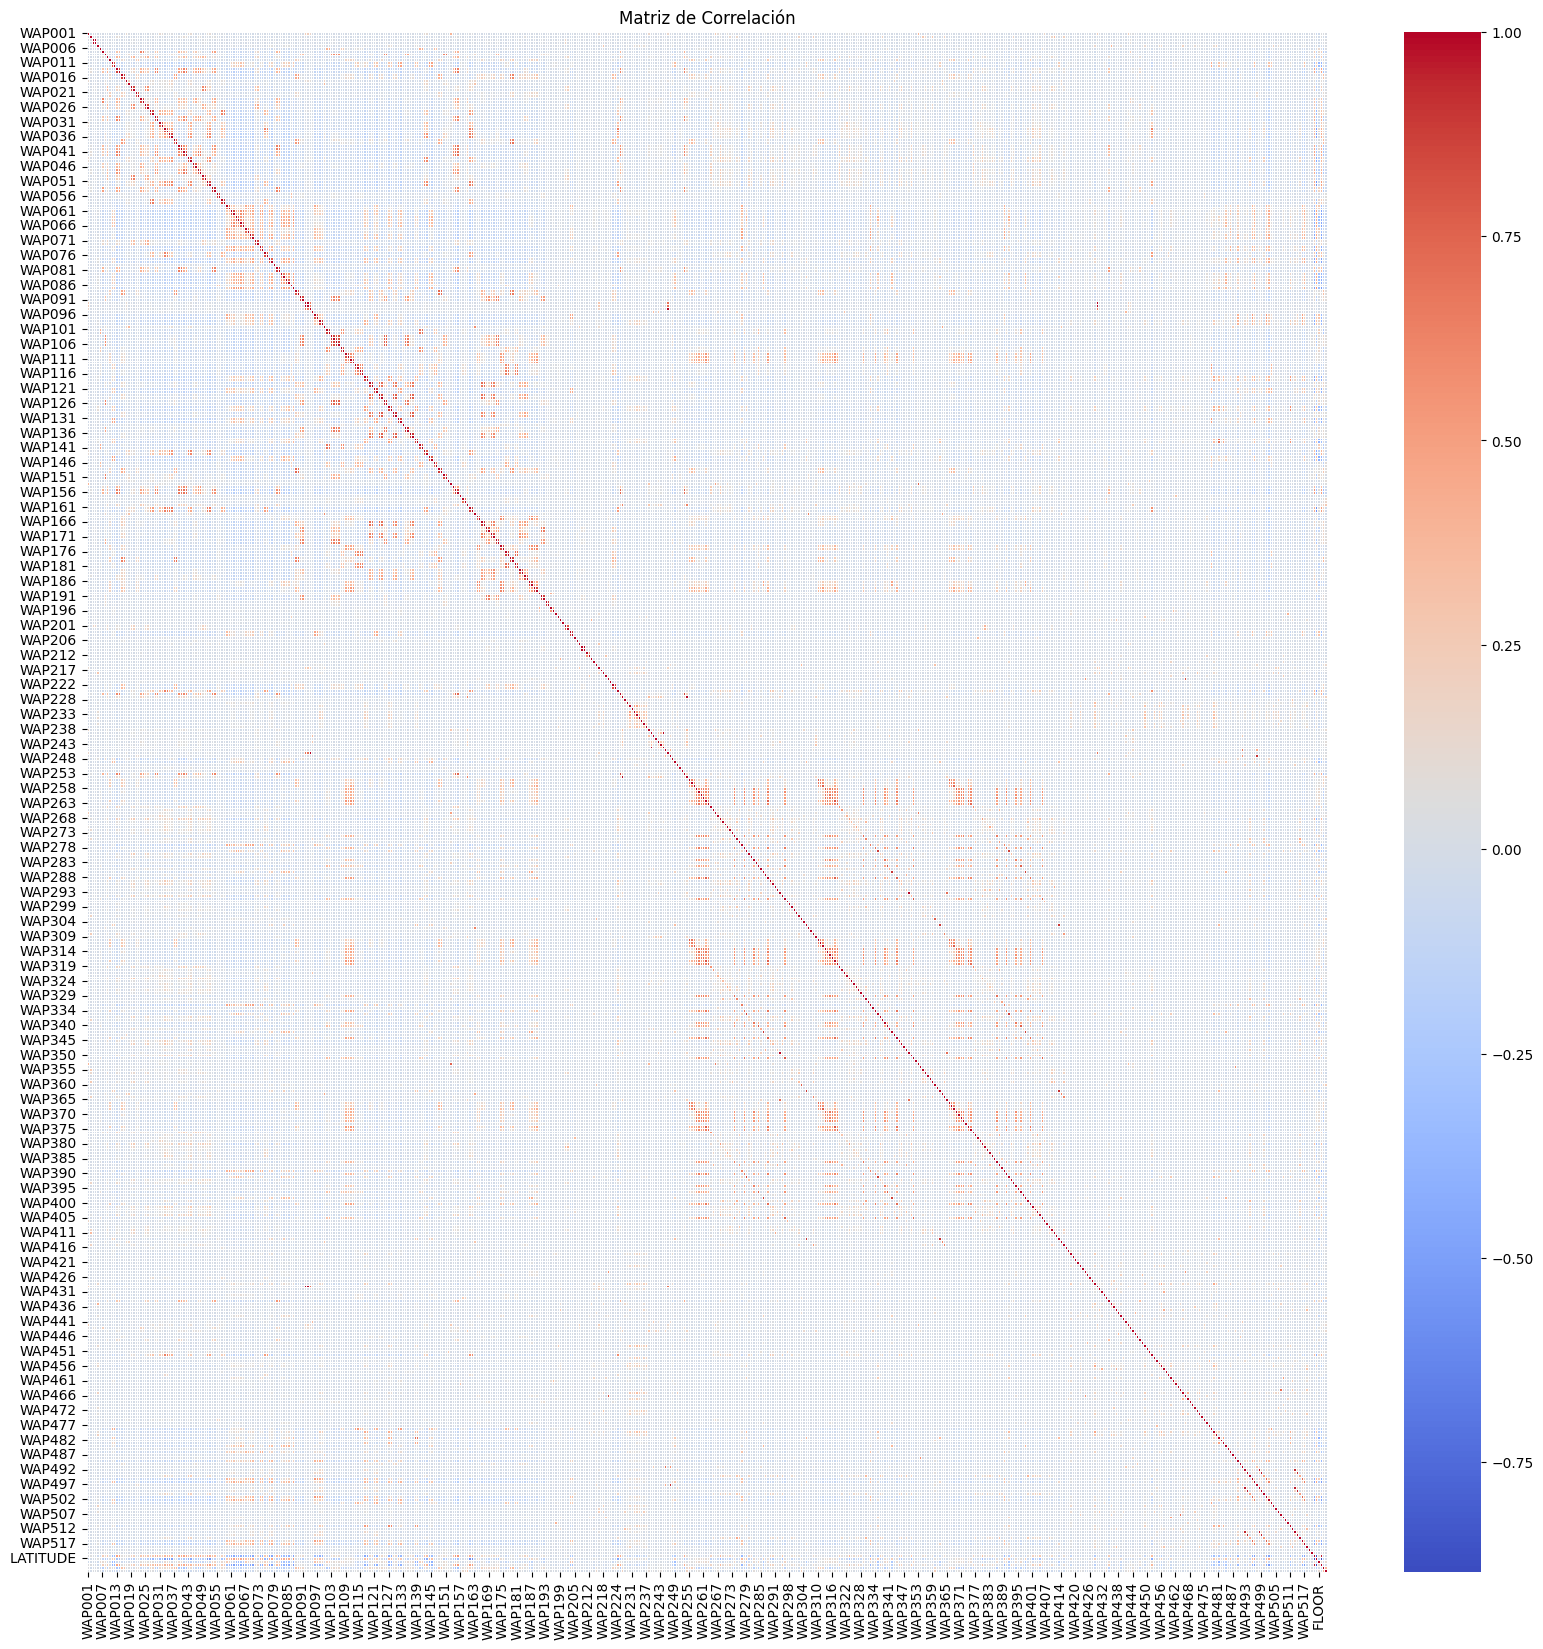

In [ ]:
correlation_matrix = data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

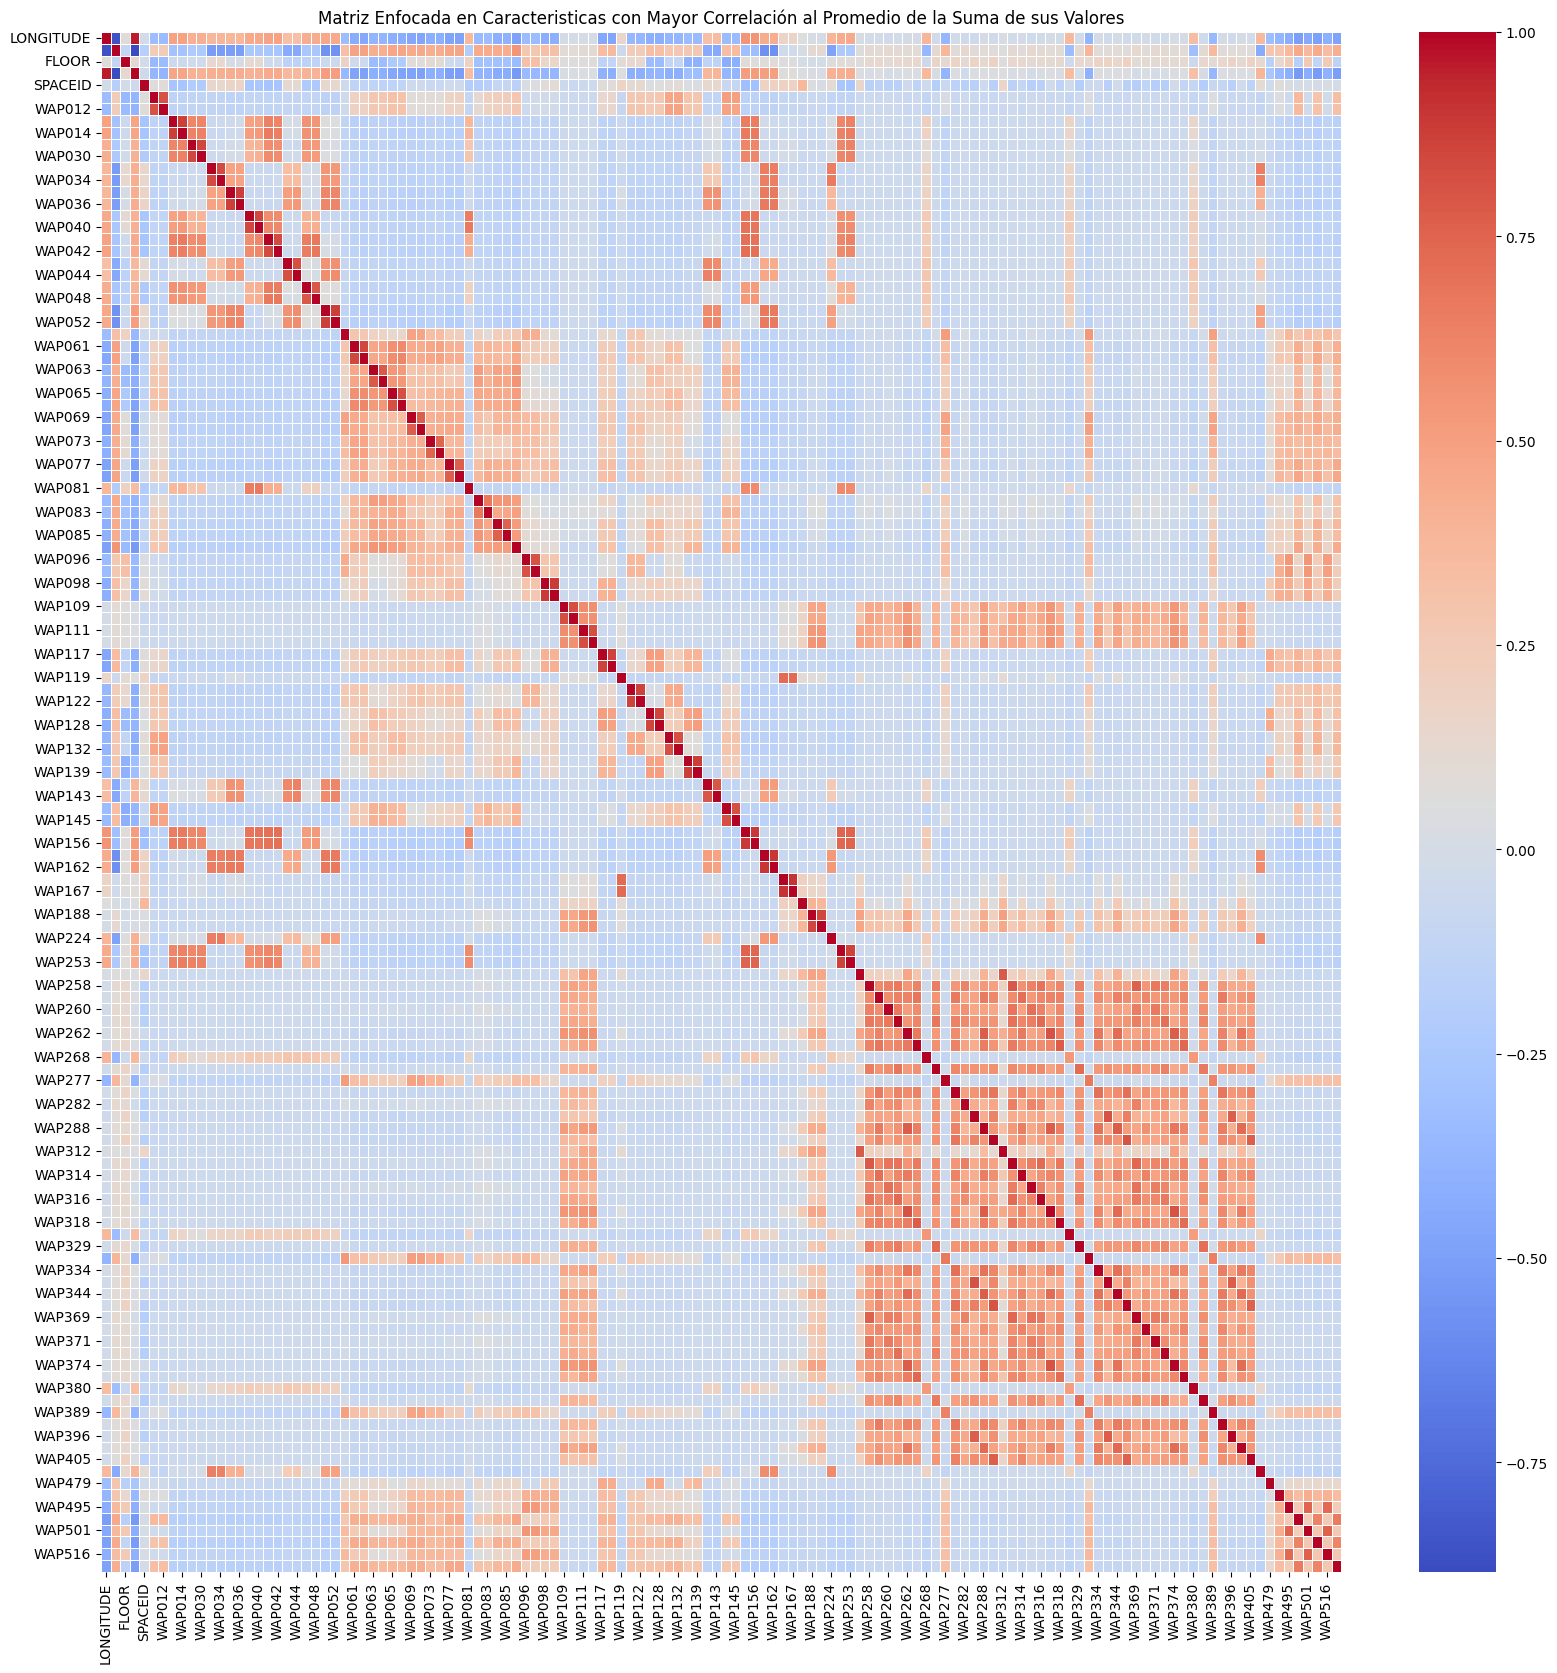

In [ ]:
columns_relevant = np.where((correlation_matrix.abs().sum()>=np.percentile(correlation_matrix.abs().sum(), 75))&(correlation_matrix.abs()!=1),correlation_matrix.index,0)
cols_waps = list(data[np.unique(columns_relevant[columns_relevant!=0])].drop(columns=['LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID']).columns)
cols_waps.sort()
columns_of_interest = ['LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID'] + cols_waps
plt.figure(figsize=(20, 20))
sns.heatmap(data[columns_of_interest].corr(), cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Matriz Enfocada en Caracteristicas con Mayor Correlación al Promedio de la Suma de sus Valores')
plt.show()

In [ ]:
data = data[np.unique(columns_relevant[columns_relevant!=0])]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16779 entries, 16667 to 15795
Columns: 130 entries, BUILDINGID to WAP517
dtypes: float64(2), int64(128)
memory usage: 16.8 MB


### Tomando los atributos cuya suma de los valores de correlacion con las otras variables sea mayor al promedio de todas, podemos encontrar que muchas columnas no son relevantes para el modelo y quedarnos con las que pueden aportar mas al mismo.

# Seleccionar un Edificio

## Lectura de los datos

### Se realiza la lectura del conjunto tanto de entrenamiento como de prueba para unirlos y segmentar los datos en un porcentaje 80/20. 80% Entrenamiento y 20% Pruebas

In [ ]:
data_train = pd.read_csv("https://raw.githubusercontent.com/ccamachosa31/IAProyectoDL/main/Data/UjiIndoorLocData/trainingData.csv")
print(len(data_train))
data_test =  pd.read_csv("https://raw.githubusercontent.com/ccamachosa31/IAProyectoDL/main/Data/UjiIndoorLocData/validationData.csv")
print(len(data_test))
data_full = pd.concat([data_train,data_test])
data_full.info()

19937
1111
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21048 entries, 0 to 1110
Columns: 529 entries, WAP001 to TIMESTAMP
dtypes: float64(2), int64(527)
memory usage: 85.1 MB


In [ ]:
most_frequent_building = data_full['BUILDINGID'].value_counts().idxmax()
building_data = data_full[data_full['BUILDINGID'] == most_frequent_building]
print(most_frequent_building)
data, data_test = train_test_split(building_data, test_size=0.2, random_state=42)
data.info()

2
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7808 entries, 2462 to 13672
Columns: 529 entries, WAP001 to TIMESTAMP
dtypes: float64(2), int64(527)
memory usage: 31.6 MB


### La base de datos que se toma para todo el proceso hasta el entrenamiento contiene 7808 registros y solamente los datos relacionados al edificio 2

## Informacion de dataset (cantidad de registros, cantidad de columnas, tipos de datos de las columnas)

### Las columnas 'USERID' y 'PhoneID' no son relevantes pra el modelo ya que no se requiere conocer como se obtuvieron los datos y la columna 'TIMESTAMP' tampoco sera util ya que no se va a trabajar con tiempos

In [ ]:
data.drop(columns=['TIMESTAMP','USERID','PHONEID','BUILDINGID'],inplace=True)

In [ ]:
data_org = data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7808 entries, 2462 to 13672
Columns: 525 entries, WAP001 to RELATIVEPOSITION
dtypes: float64(2), int64(523)
memory usage: 31.3 MB


## Verificacion de las columnas en busca de datos nulos o vacios

In [ ]:
steps = range(0,len(data.columns),100)
for ind,val in enumerate(steps):
  if ind + 1 == len(steps):
    print(data[data.columns[steps[ind]:]].info())
  else:
    print(data[data.columns[steps[ind]:steps[ind+1]]].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7808 entries, 2462 to 13672
Data columns (total 100 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   WAP001  7808 non-null   int64
 1   WAP002  7808 non-null   int64
 2   WAP003  7808 non-null   int64
 3   WAP004  7808 non-null   int64
 4   WAP005  7808 non-null   int64
 5   WAP006  7808 non-null   int64
 6   WAP007  7808 non-null   int64
 7   WAP008  7808 non-null   int64
 8   WAP009  7808 non-null   int64
 9   WAP010  7808 non-null   int64
 10  WAP011  7808 non-null   int64
 11  WAP012  7808 non-null   int64
 12  WAP013  7808 non-null   int64
 13  WAP014  7808 non-null   int64
 14  WAP015  7808 non-null   int64
 15  WAP016  7808 non-null   int64
 16  WAP017  7808 non-null   int64
 17  WAP018  7808 non-null   int64
 18  WAP019  7808 non-null   int64
 19  WAP020  7808 non-null   int64
 20  WAP021  7808 non-null   int64
 21  WAP022  7808 non-null   int64
 22  WAP023  7808 non-null   int64
 23  WAP024  

### No se encuentran valores nulos

## Estadisticas de las columnas

In [ ]:
steps = range(0,len(data.columns),5)
for ind,val in enumerate(steps):
  if ind + 1 == len(steps):
    print(data[data.columns[steps[ind]:]].describe())
  else:
    print(data[data.columns[steps[ind]:steps[ind+1]]].describe())

       WAP001  WAP002  WAP003  WAP004       WAP005
count  7808.0  7808.0  7808.0  7808.0  7808.000000
mean    100.0   100.0   100.0   100.0    99.184939
std       0.0     0.0     0.0     0.0    12.512276
min     100.0   100.0   100.0   100.0   -97.000000
25%     100.0   100.0   100.0   100.0   100.000000
50%     100.0   100.0   100.0   100.0   100.000000
75%     100.0   100.0   100.0   100.0   100.000000
max     100.0   100.0   100.0   100.0   100.000000
            WAP006  WAP007  WAP008  WAP009  WAP010
count  7808.000000  7808.0  7808.0  7808.0  7808.0
mean     99.418545   100.0   100.0   100.0   100.0
std      10.475124     0.0     0.0     0.0     0.0
min     -98.000000   100.0   100.0   100.0   100.0
25%     100.000000   100.0   100.0   100.0   100.0
50%     100.000000   100.0   100.0   100.0   100.0
75%     100.000000   100.0   100.0   100.0   100.0
max     100.000000   100.0   100.0   100.0   100.0
            WAP011       WAP012  WAP013  WAP014  WAP015
count  7808.000000  7808.0

### 2 de las columnas WAP cuentan con los mismos datos que son el valor 100 que indica sin deteccion, esta caracteristica al ser igual para todos los registros no son relevantes para el modelo y se eliminaran

In [ ]:
columns_select = pd.DataFrame((data.mean(axis=0)!=100))
columns_select = columns_select[columns_select[0]==True].T.columns
data = data[columns_select]
data.head()

WAP005  WAP006  WAP011  WAP012  WAP059  WAP060  WAP061  WAP062  WAP063  \
2462      100     100     -88     -88     100     100     -90     -94     -88   
11026     100     100     -82     -82     100     100     100     100     -94   
5822      100     100     100     100     -60     -67     -87     -87     100   
14554     100     100     100     -85     100     100     100     100     100   
18648     100     100     100     100     100     -99     100     100     100   

       WAP064  ...  WAP513  WAP514  WAP516  WAP517  WAP518    LONGITUDE  \
2462      -88  ...     100     100     100     -87     100 -7390.761200   
11026     100  ...     100     100     -88     100     100 -7325.052900   
5822      100  ...     100     100     100     100     100 -7342.435300   
14554     100  ...     100     100     100     100     100 -7374.897300   
18648     100  ...     100     100     -83     100     100 -7351.981125   

           LATITUDE  FLOOR  SPACEID  RELATIVEPOSITION  
2462   4.864835e+06      4      147                 2  
11026  4.864819e+06      3      124                 2  
5822   4.864757e+06      0      207                 2  
14554  4.864856e+06      1      105                 2  
18648  4.864843e+06      0      140                 1  

[5 rows x 226 columns]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7808 entries, 2462 to 13672
Columns: 226 entries, WAP005 to RELATIVEPOSITION
dtypes: float64(2), int64(224)
memory usage: 13.5 MB


In [ ]:
data[data[data.columns[:-6]].mean(axis=1)==100]

WAP005  WAP006  WAP011  WAP012  WAP059  WAP060  WAP061  WAP062  WAP063  \
4756      100     100     100     100     100     100     100     100     100   
4777      100     100     100     100     100     100     100     100     100   
4982      100     100     100     100     100     100     100     100     100   
5116      100     100     100     100     100     100     100     100     100   
18744     100     100     100     100     100     100     100     100     100   
4755      100     100     100     100     100     100     100     100     100   
5031      100     100     100     100     100     100     100     100     100   
4716      100     100     100     100     100     100     100     100     100   
4966      100     100     100     100     100     100     100     100     100   
4721      100     100     100     100     100     100     100     100     100   
4928      100     100     100     100     100     100     100     100     100   
4914      100     100     100     100     100     100     100     100     100   
4884      100     100     100     100     100     100     100     100     100   
19282     100     100     100     100     100     100     100     100     100   
4701      100     100     100     100     100     100     100     100     100   
4981      100     100     100     100     100     100     100     100     100   
18745     100     100     100     100     100     100     100     100     100   
4929      100     100     100     100     100     100     100     100     100   
5114      100     100     100     100     100     100     100     100     100   
4931      100     100     100     100     100     100     100     100     100   
5127      100     100     100     100     100     100     100     100     100   
4880      100     100     100     100     100     100     100     100     100   
18654     100     100     100     100     100     100     100     100     100   
4655      100     100     100     100     100     100     100     100     100   
19278     100     100     100     100     100     100     100     100     100   
4826      100     100     100     100     100     100     100     100     100   
5065      100     100     100     100     100     100     100     100     100   
5081      100     100     100     100     100     100     100     100     100   
4812      100     100     100     100     100     100     100     100     100   
5134      100     100     100     100     100     100     100     100     100   
4758      100     100     100     100     100     100     100     100     100   

       WAP064  ...  WAP513  WAP514  WAP516  WAP517  WAP518    LONGITUDE  \
4756      100  ...     100     100     100     100     100 -7404.835700   
4777      100  ...     100     100     100     100     100 -7310.764900   
4982      100  ...     100     100     100     100     100 -7311.829500   
5116      100  ...     100     100     100     100     100 -7408.338870   
18744     100  ...     100     100     100     100     100 -7345.411800   
4755      100  ...     100     100     100     100     100 -7404.436200   
5031      100  ...     100     100     100     100     100 -7311.829500   
4716      100  ...     100     100     100     100     100 -7342.435300   
4966      100  ...     100     100     100     100     100 -7411.353136   
4721      100  ...     100     100     100     100     100 -7333.069100   
4928      100  ...     100     100     100     100     100 -7314.611700   
4914      100  ...     100     100     100     100     100 -7411.353136   
4884      100  ...     100     100     100     100     100 -7314.611700   
19282     100  ...     100     100     100     100     100 -7359.913360   
4701      100  ...     100     100     100     100     100 -7404.835700   
4981      100  ...     100     100     100     100     100 -7318.694800   
18745     100  ...     100     100     100     100     100 -7338.753300   
4929      100  ...     100     100     100     100     100 -7320

### Se encuentran tambien 59 registros en los cuales las mediciones dee todos los WAP tambien indican si deteccion pero cuentan con diferentes valores en longitud, latitud y Piso lo que puede ocasionar un mal entrenamiento en el modelo, estos registros se eliminaran

In [ ]:
data = data[data[data.columns[:-6]].mean(axis=1)!=100]

## Visualizacion y Analisis de los datos

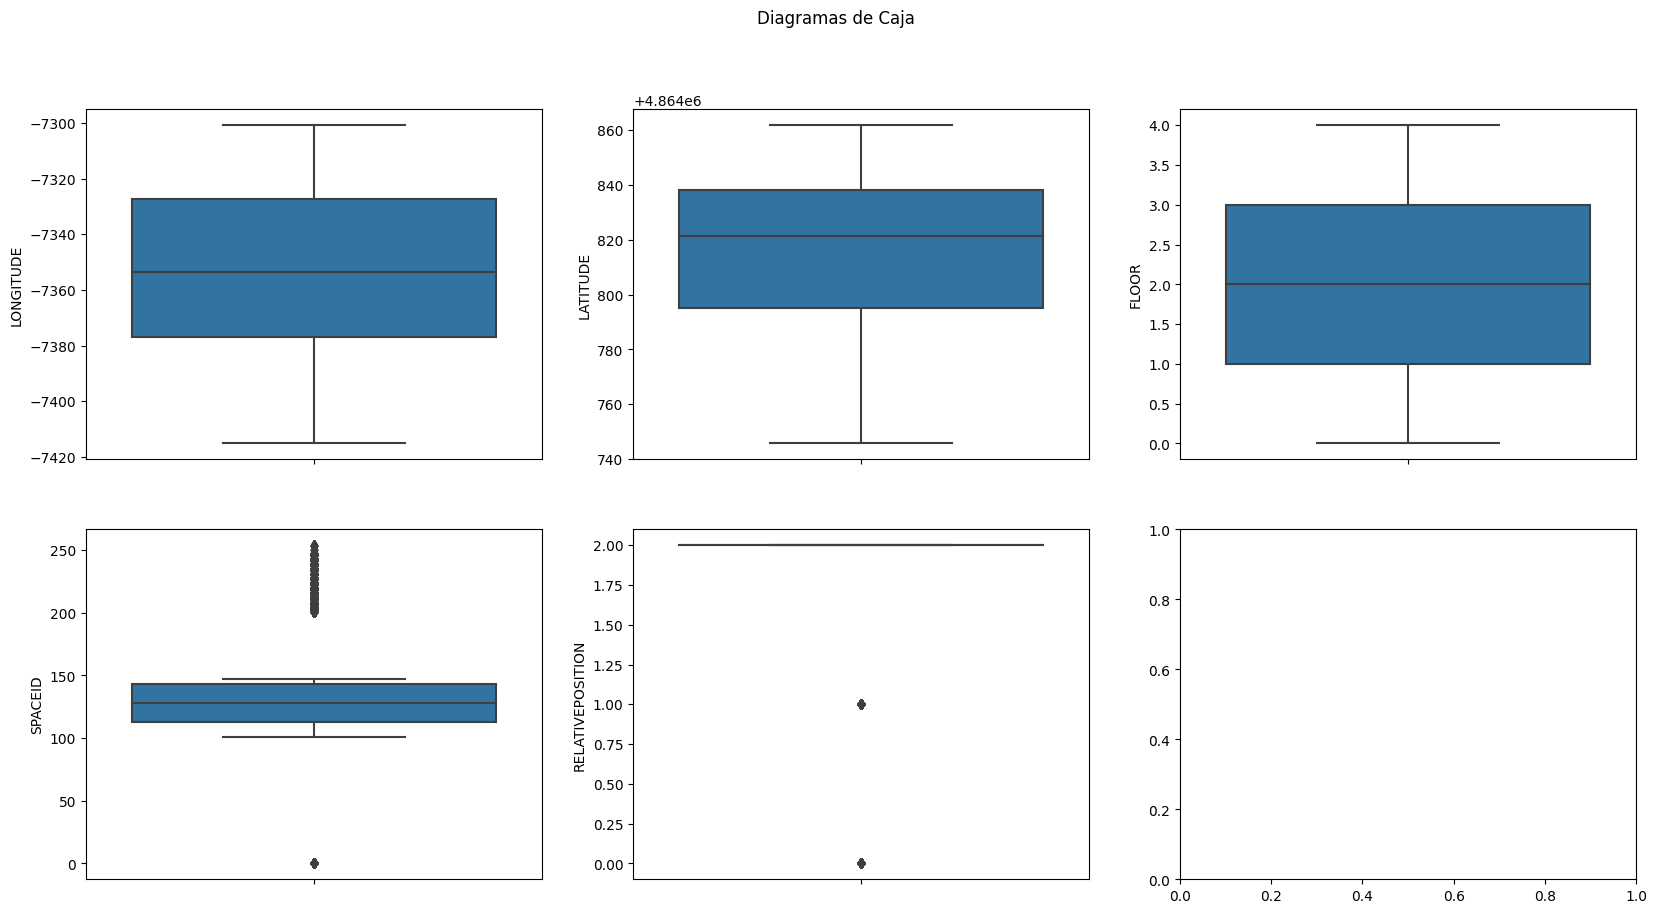

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Diagramas de Caja')
row = 0
col = 0
for ind, column in enumerate(data.columns[-5:]):
  sns.boxplot(data, y=column, ax=axes[row, col])
  if ind == 2:
    row += 1
    col = 0
  else:
    col += 1

### Dentro de las columnas que no son medicion de intensidad no se encuentran datos atipicos

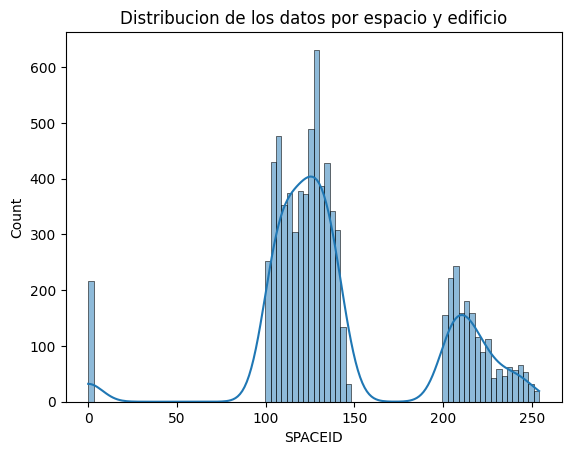

In [ ]:
sns.histplot(data, x="SPACEID", kde=True)
plt.title("Distribucion de los datos por espacio y edificio")
plt.show()

### La mayor concentracion de los datos se encuentran entre los espacios del 100 al 150 y segundo relevante son del 200 al 250, no hay linealidad en la categorizacion de los espacios

<ipython-input-33-525c1d432688>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=data, x='LONGITUDE', y='LATITUDE', palette='deep', style='FLOOR', s=50, alpha=0.7)


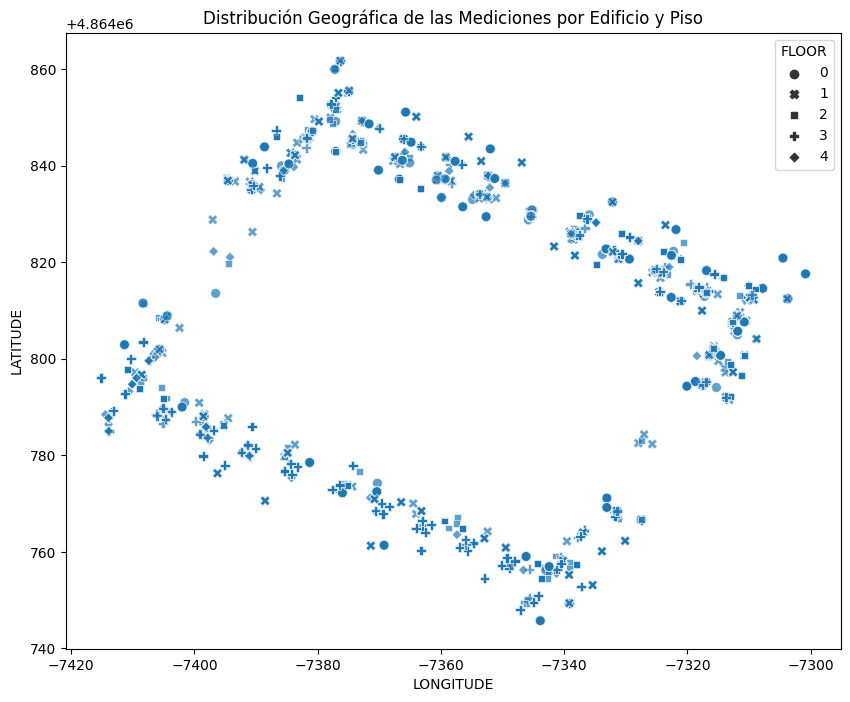

In [ ]:
# visualizar las mediciones geográficas
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='LONGITUDE', y='LATITUDE', palette='deep', style='FLOOR', s=50, alpha=0.7)
plt.title("Distribución Geográfica de las Mediciones por Edificio y Piso")
plt.show()

### La distribucción muestra la forma del edificio basado en las lecturas que se realizaron

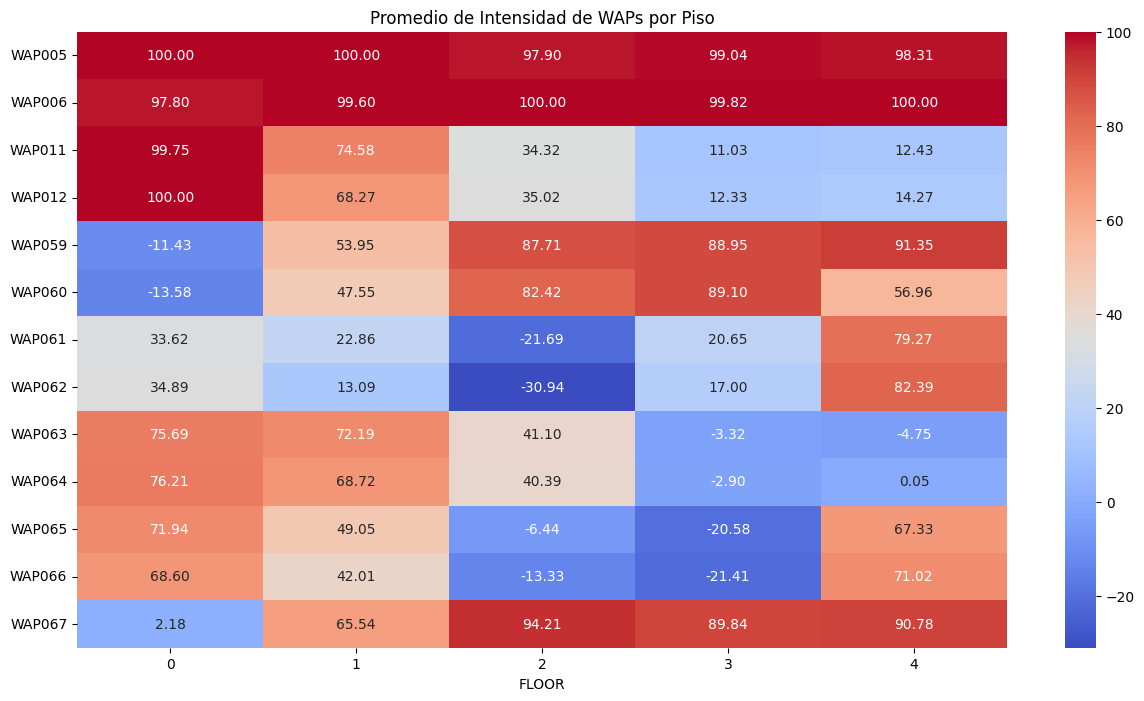

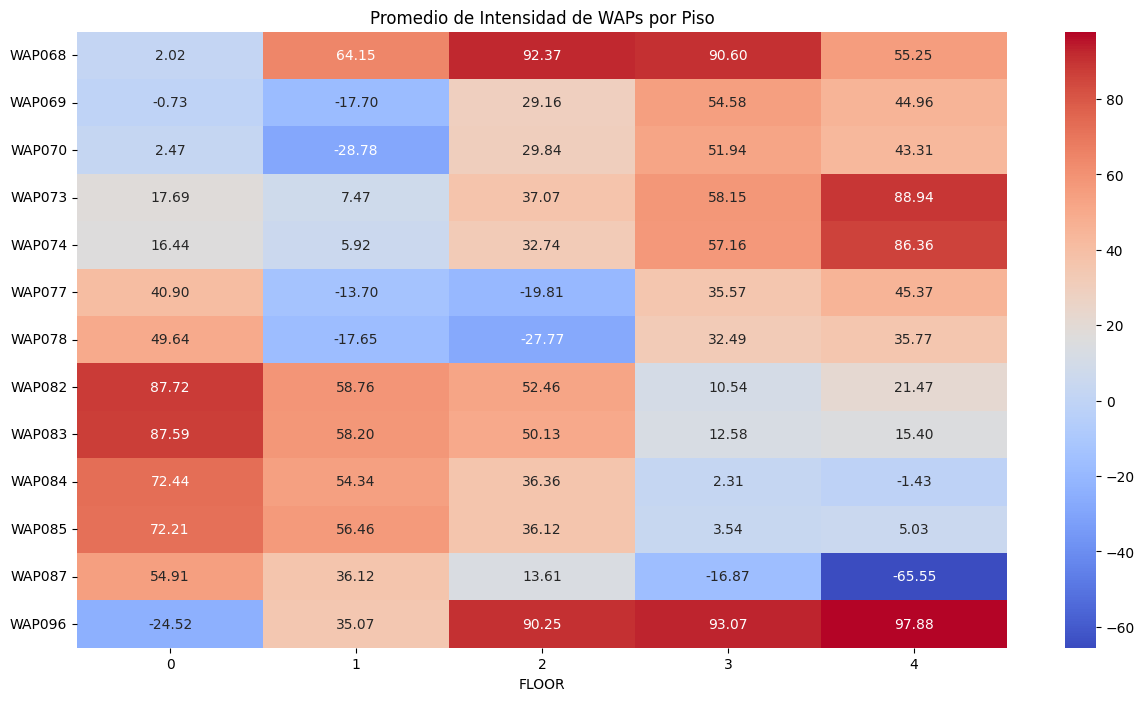

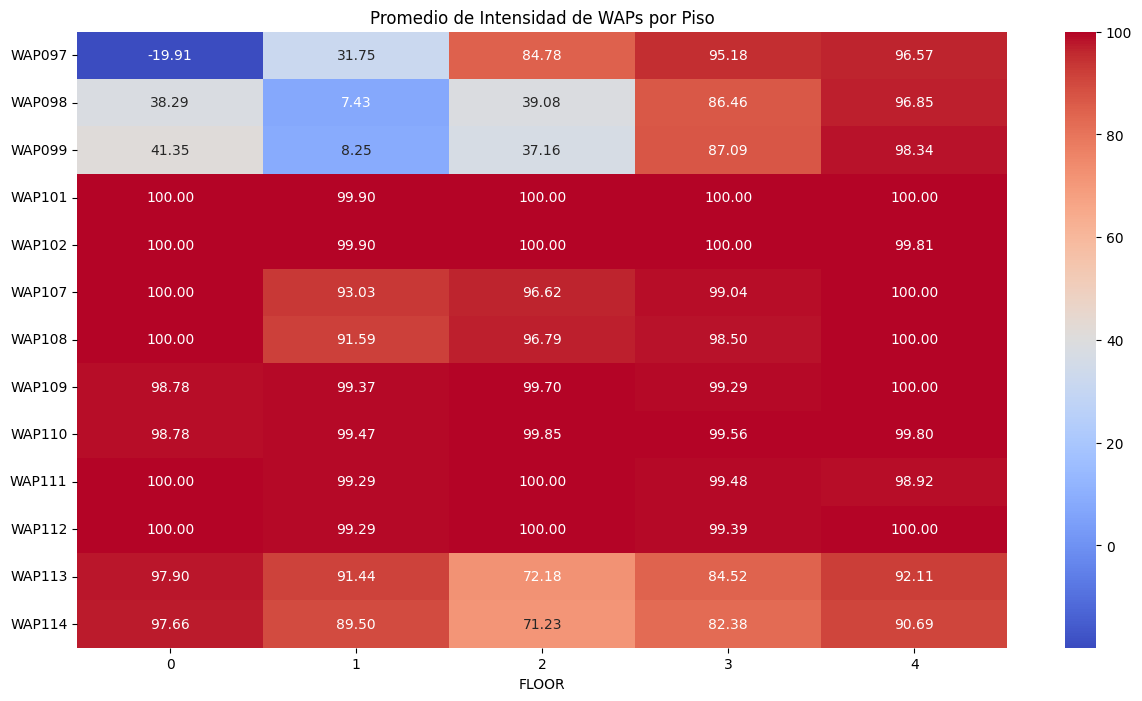

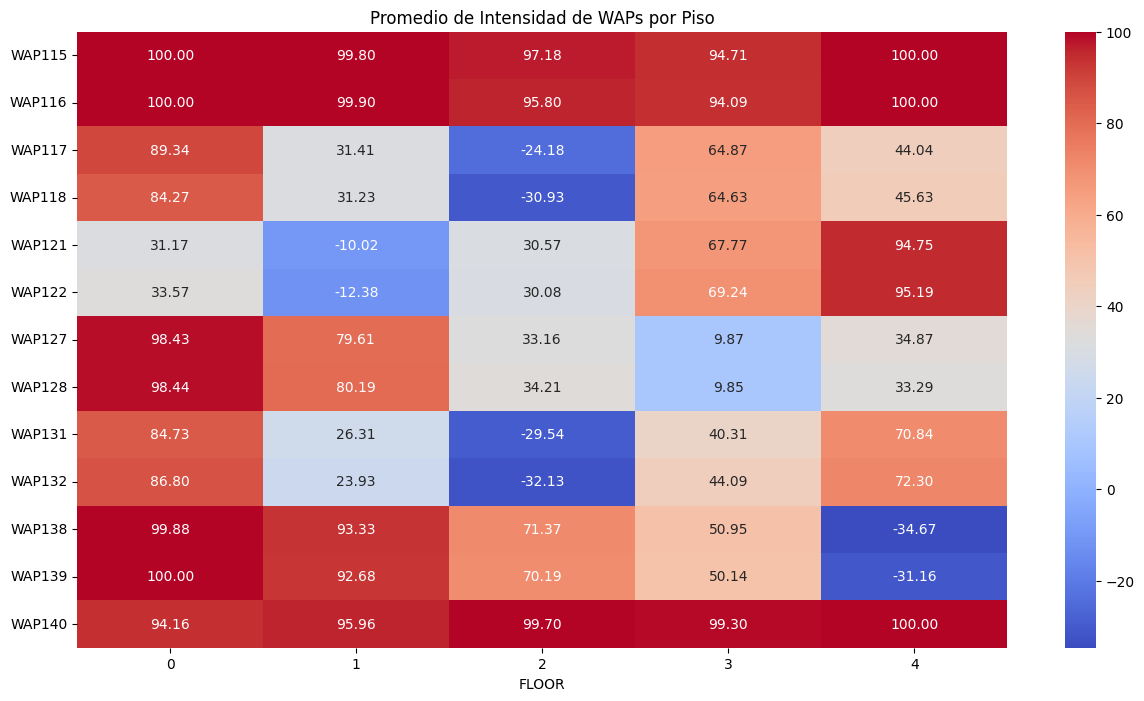

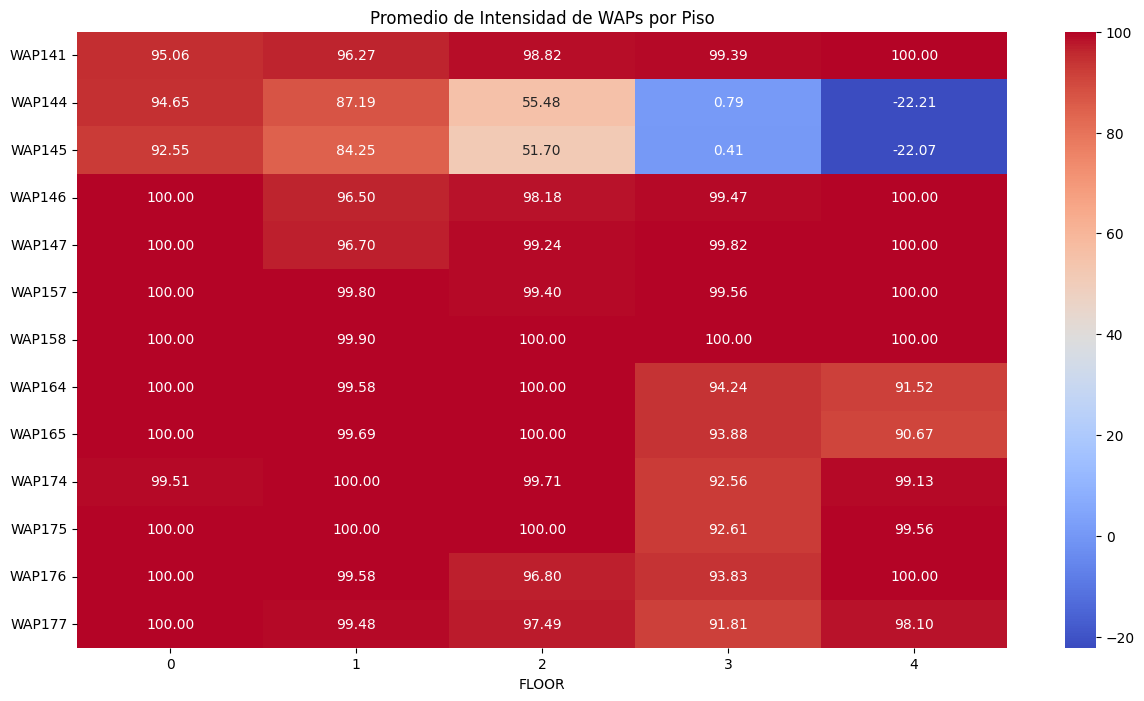

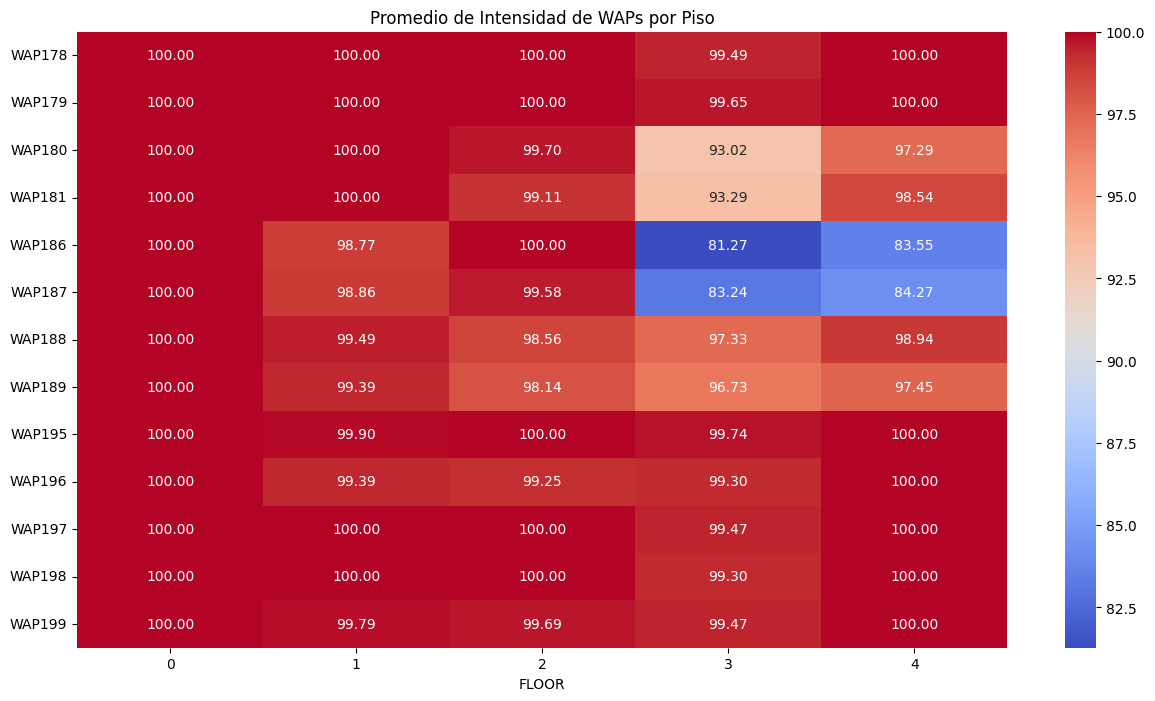

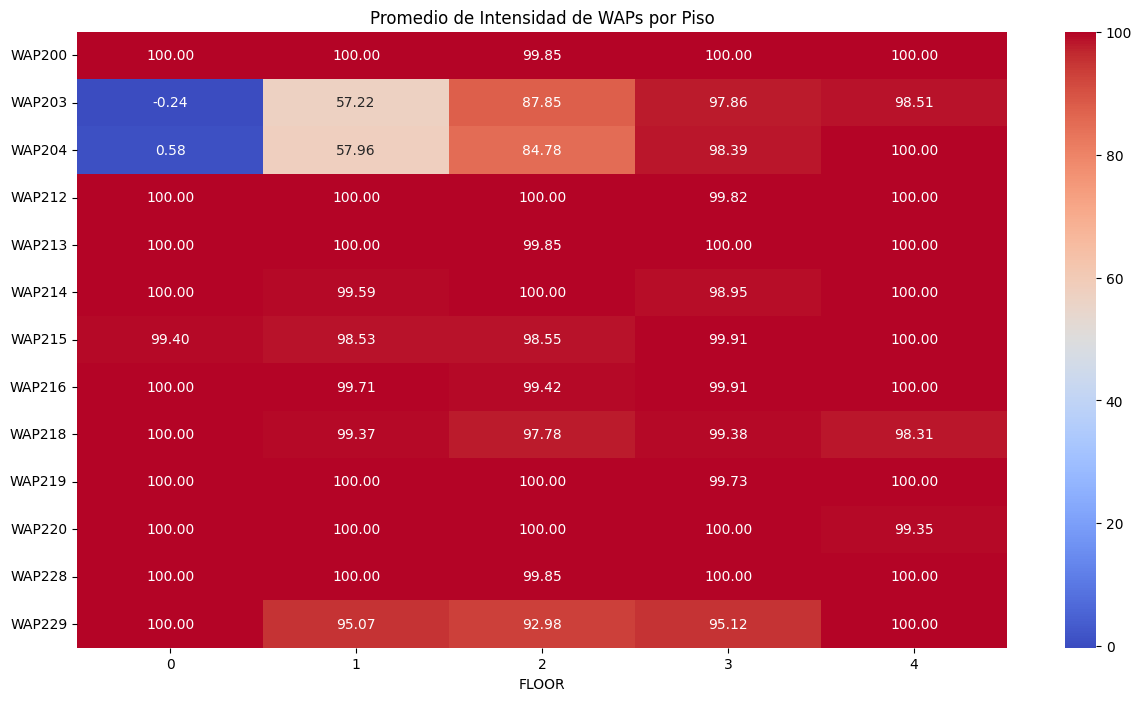

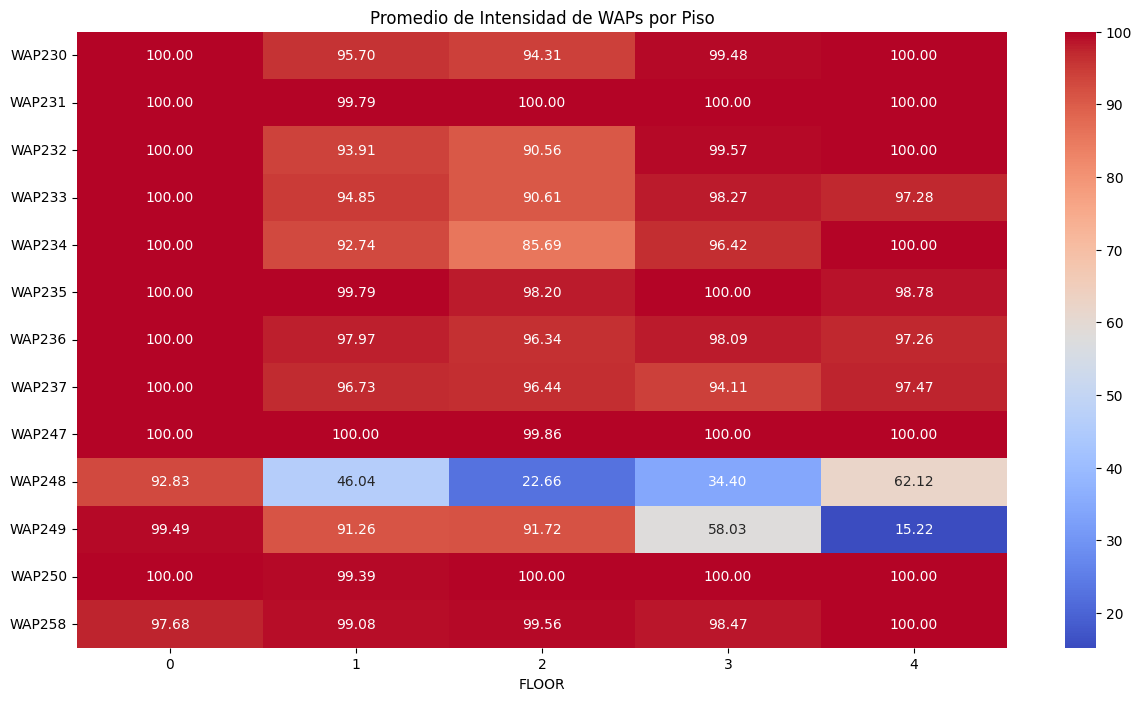

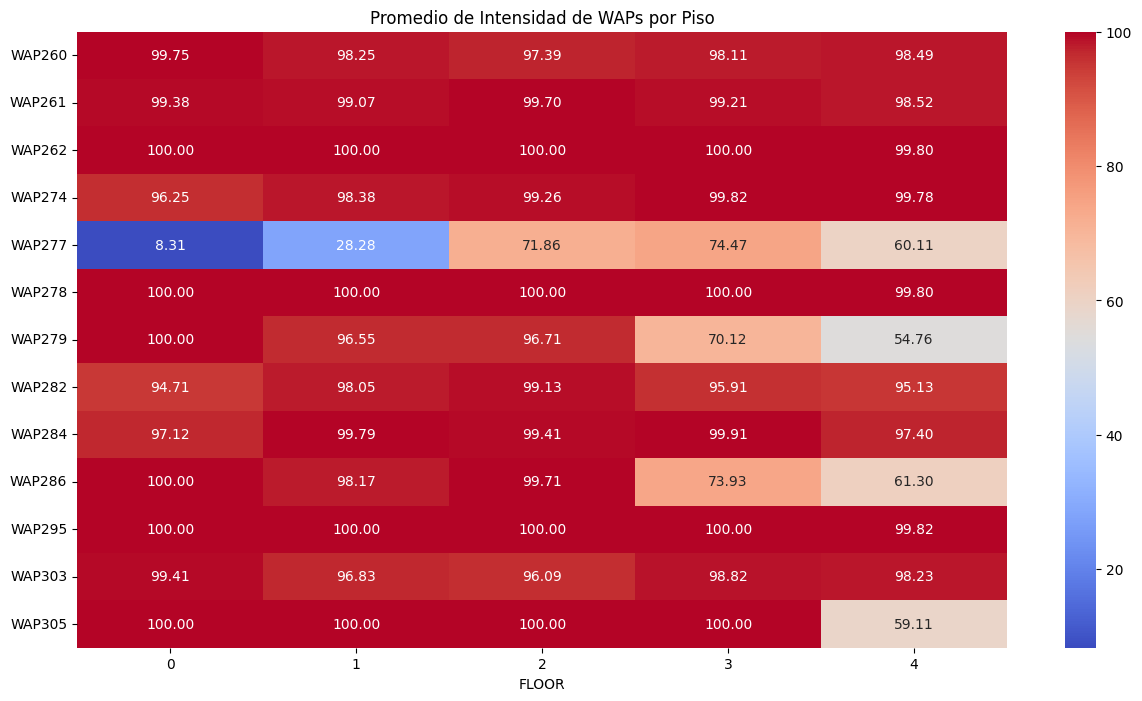

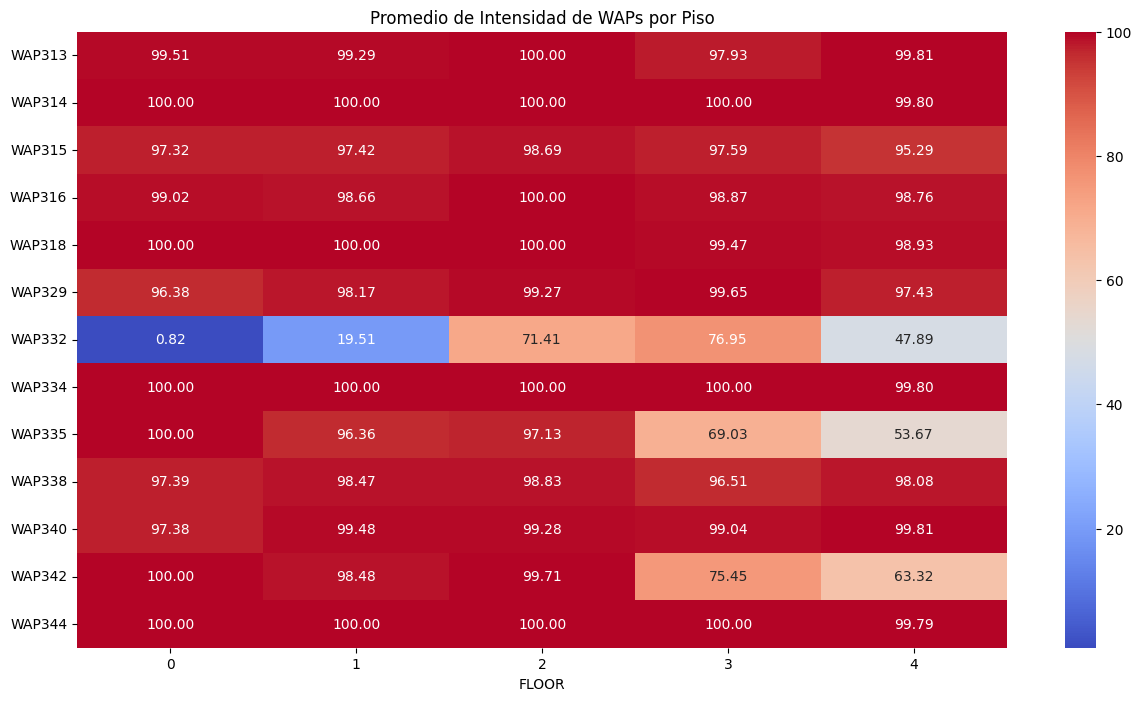

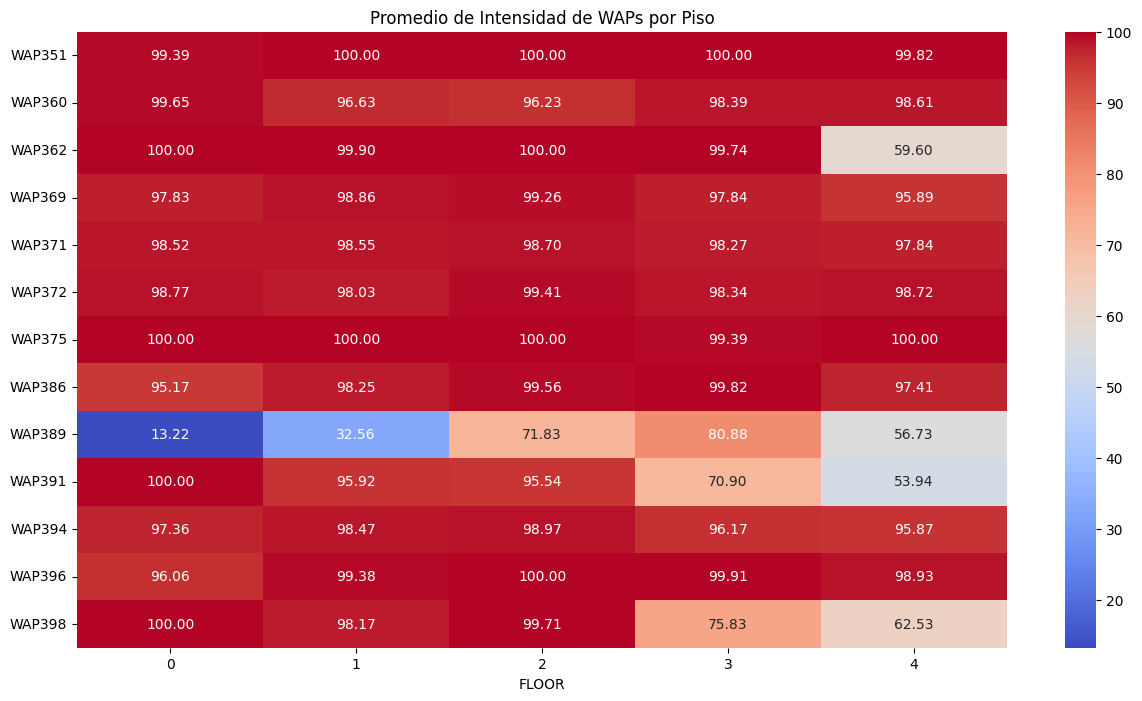

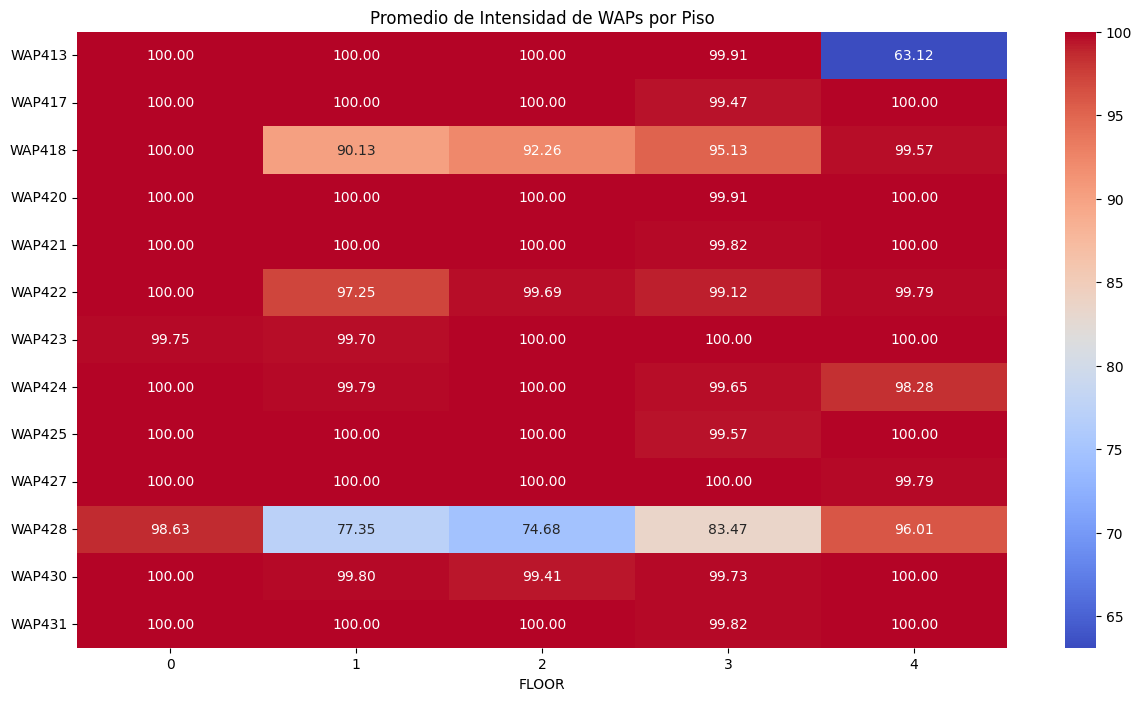

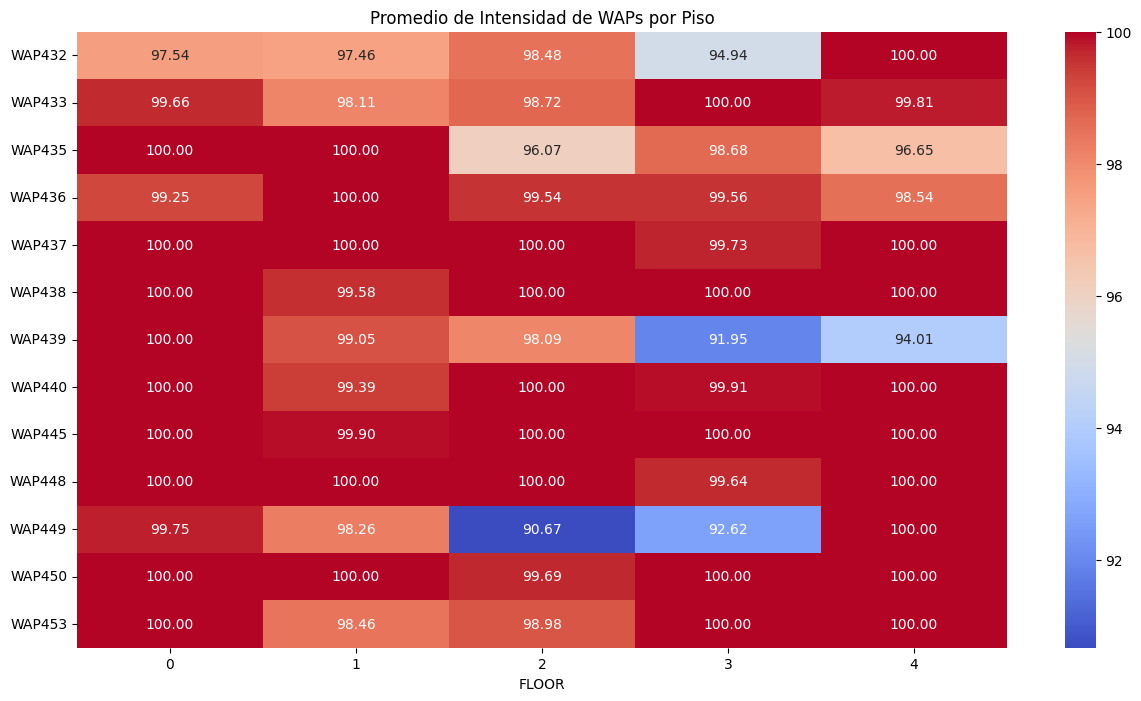

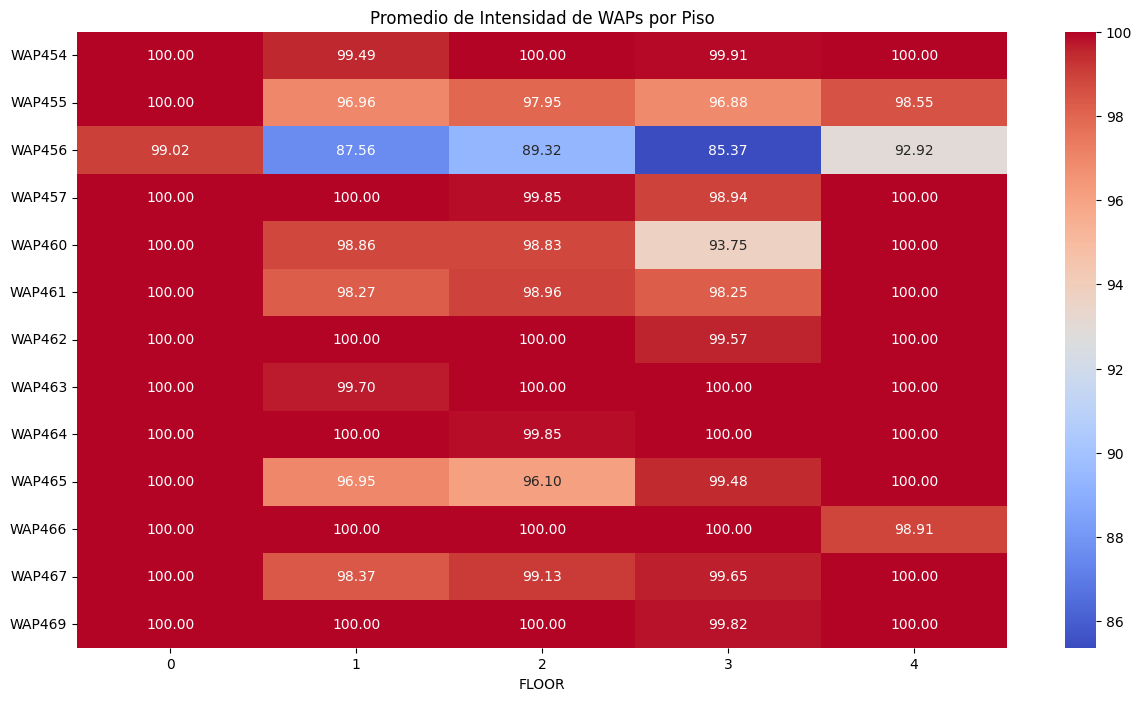

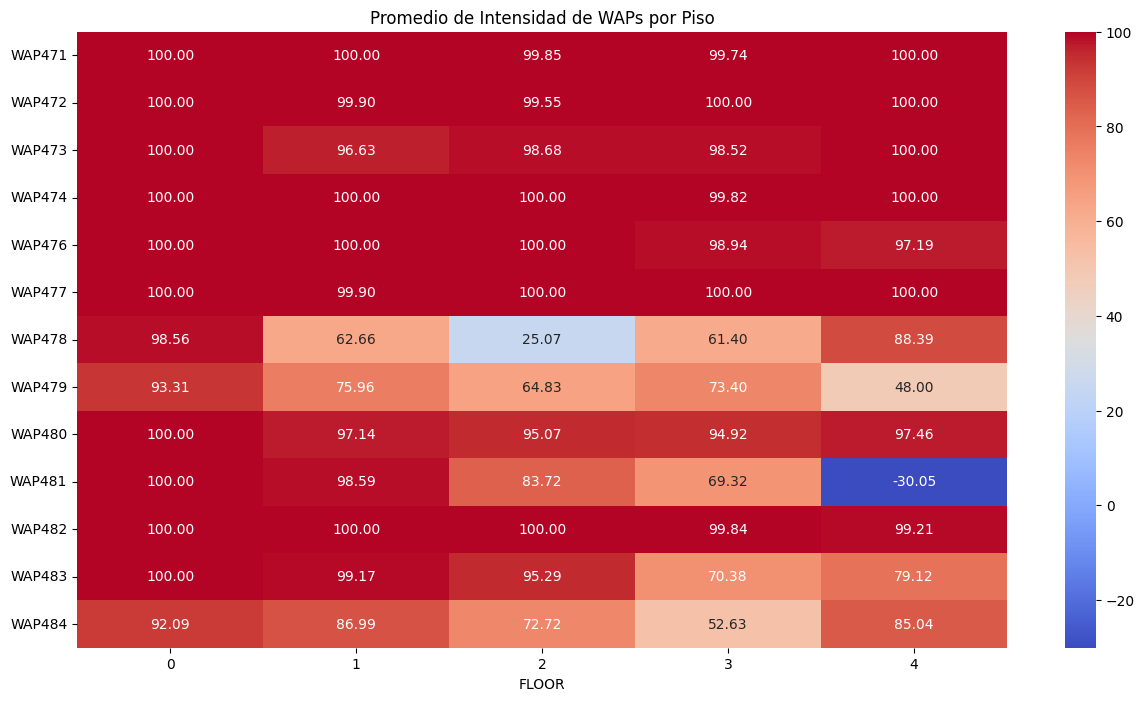

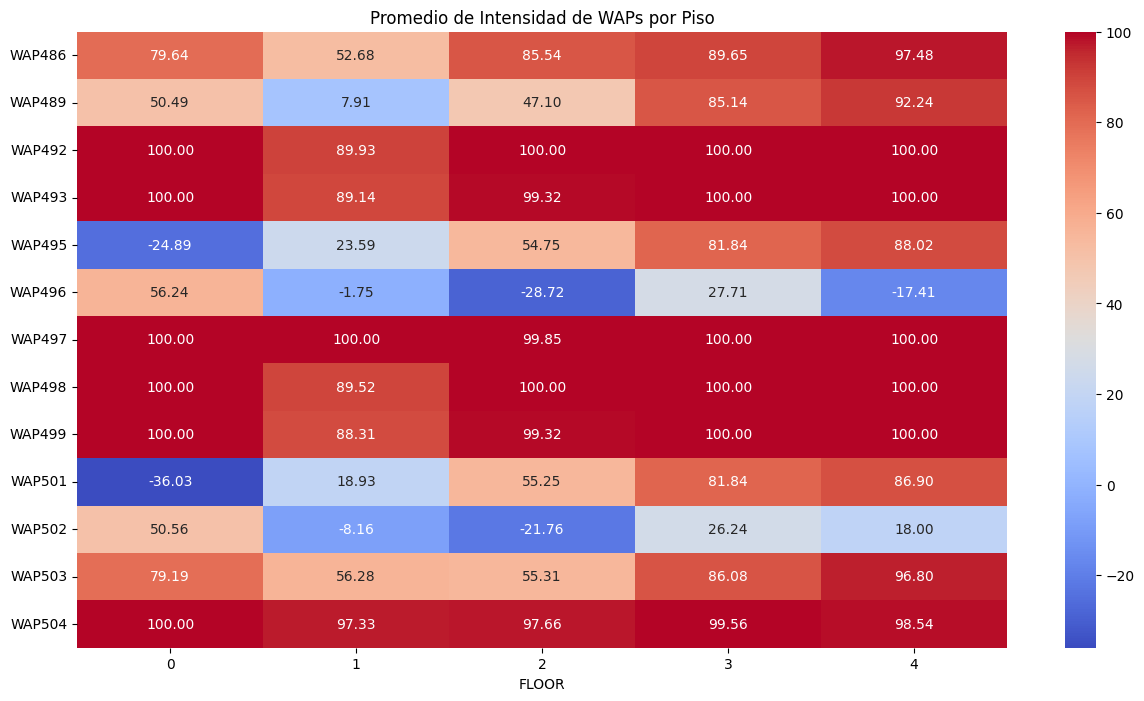

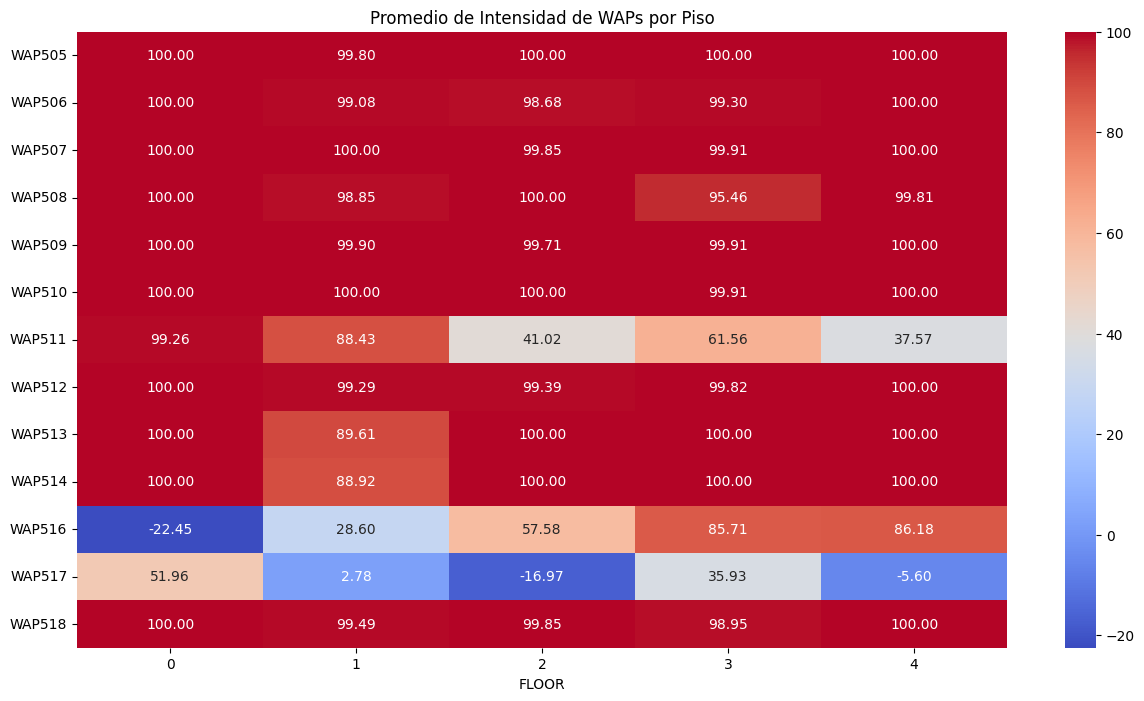

In [ ]:
heat_data = data.groupby('FLOOR')[data.columns[:-5]].mean()
for cols in np.array(data.columns[:-5]).reshape(17,13):
  heatmap_data = heat_data[cols].T
  plt.figure(figsize=(15, 8))
  sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".2f")
  plt.title("Promedio de Intensidad de WAPs por Piso")
  plt.show()

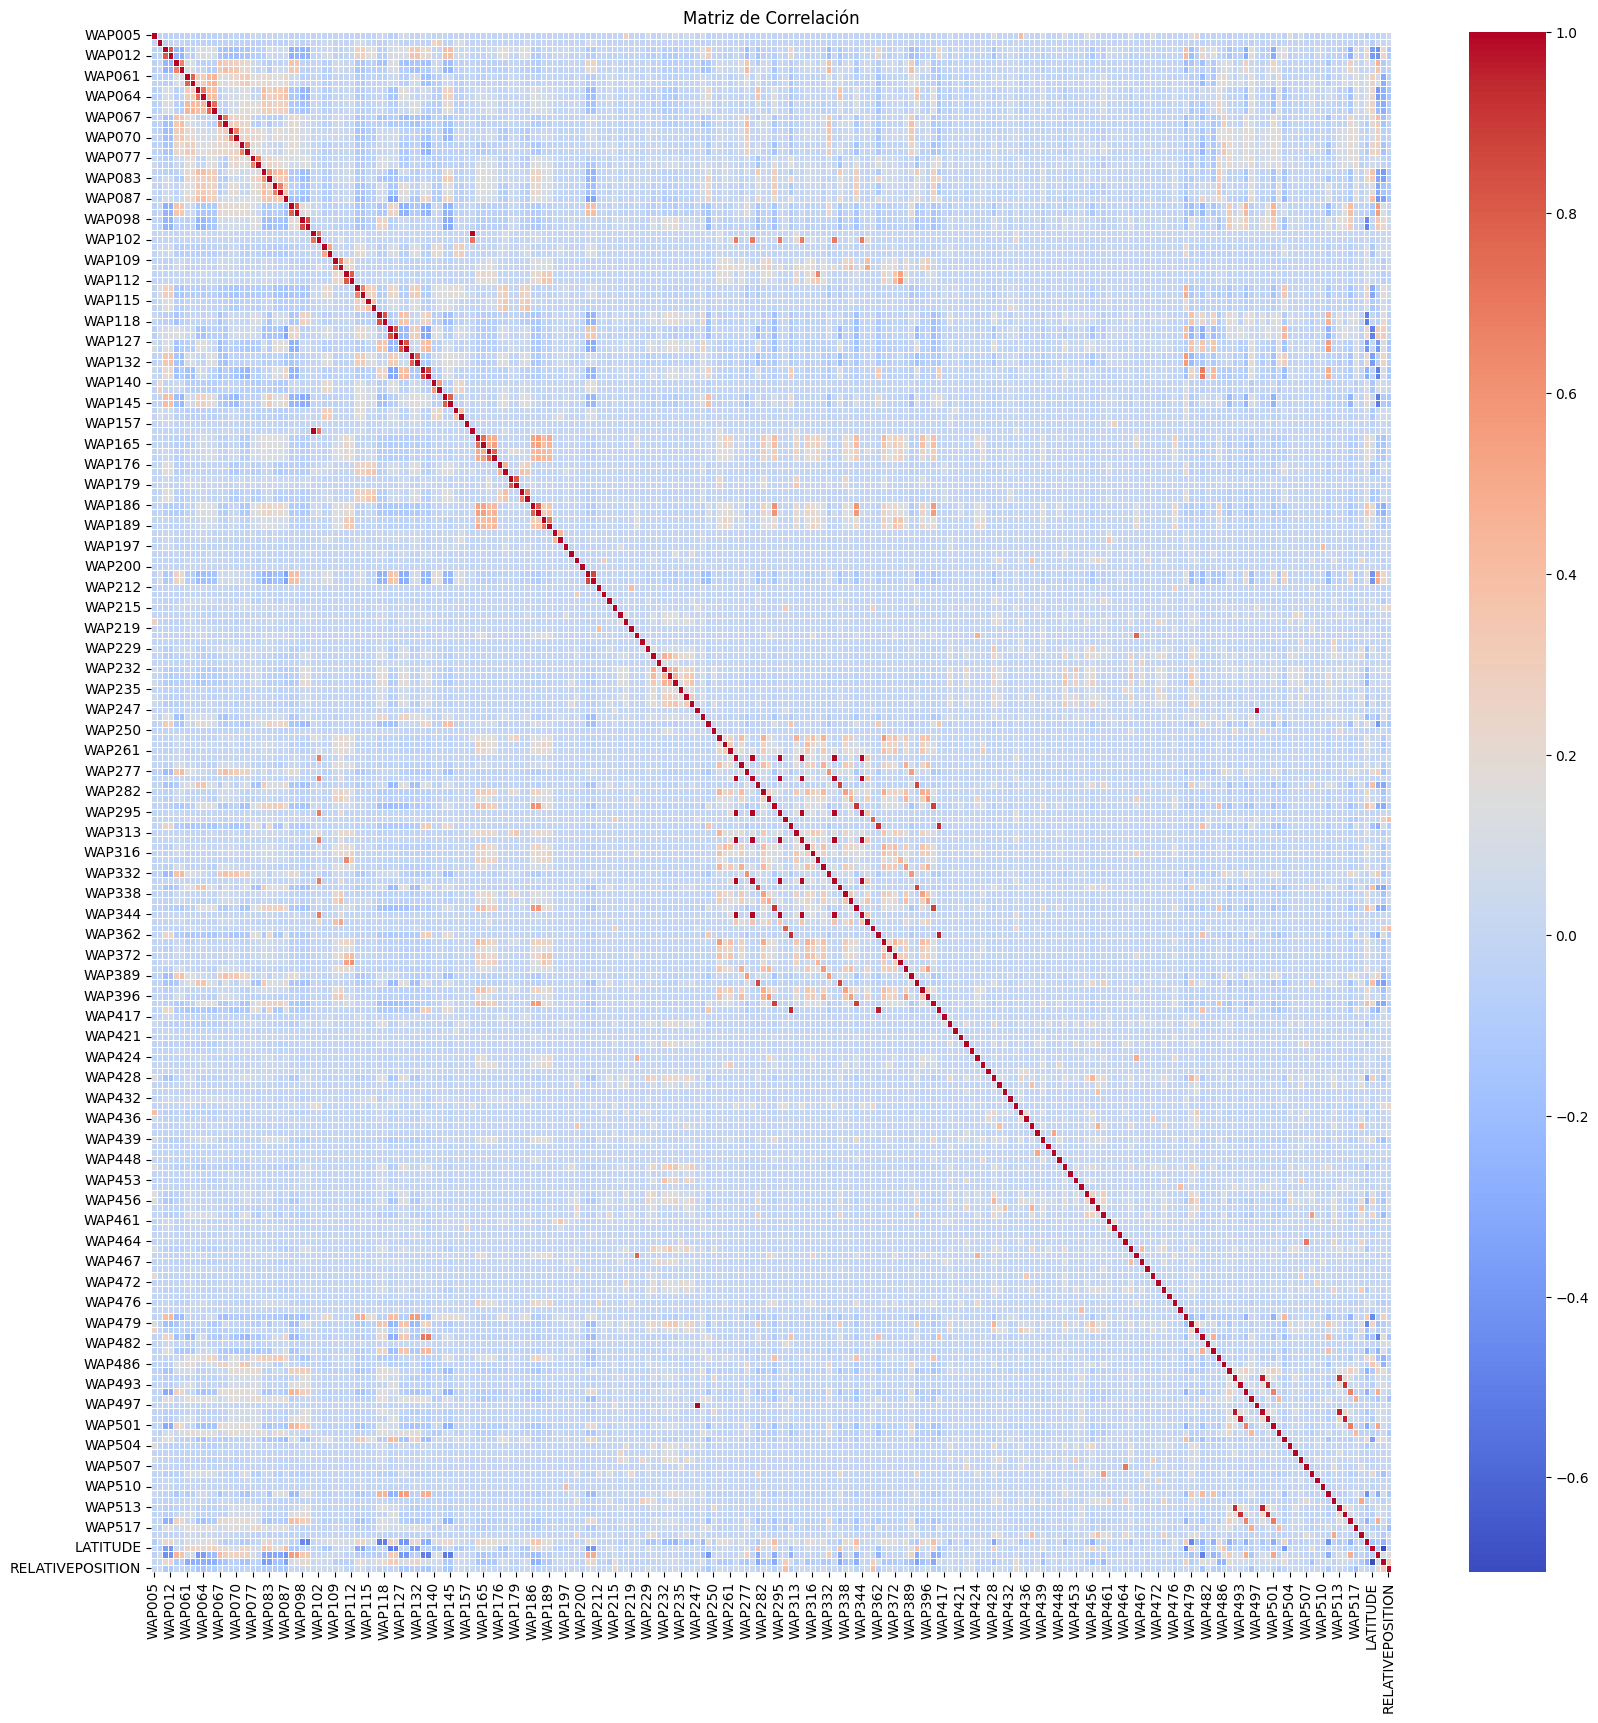

In [ ]:
correlation_matrix = data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

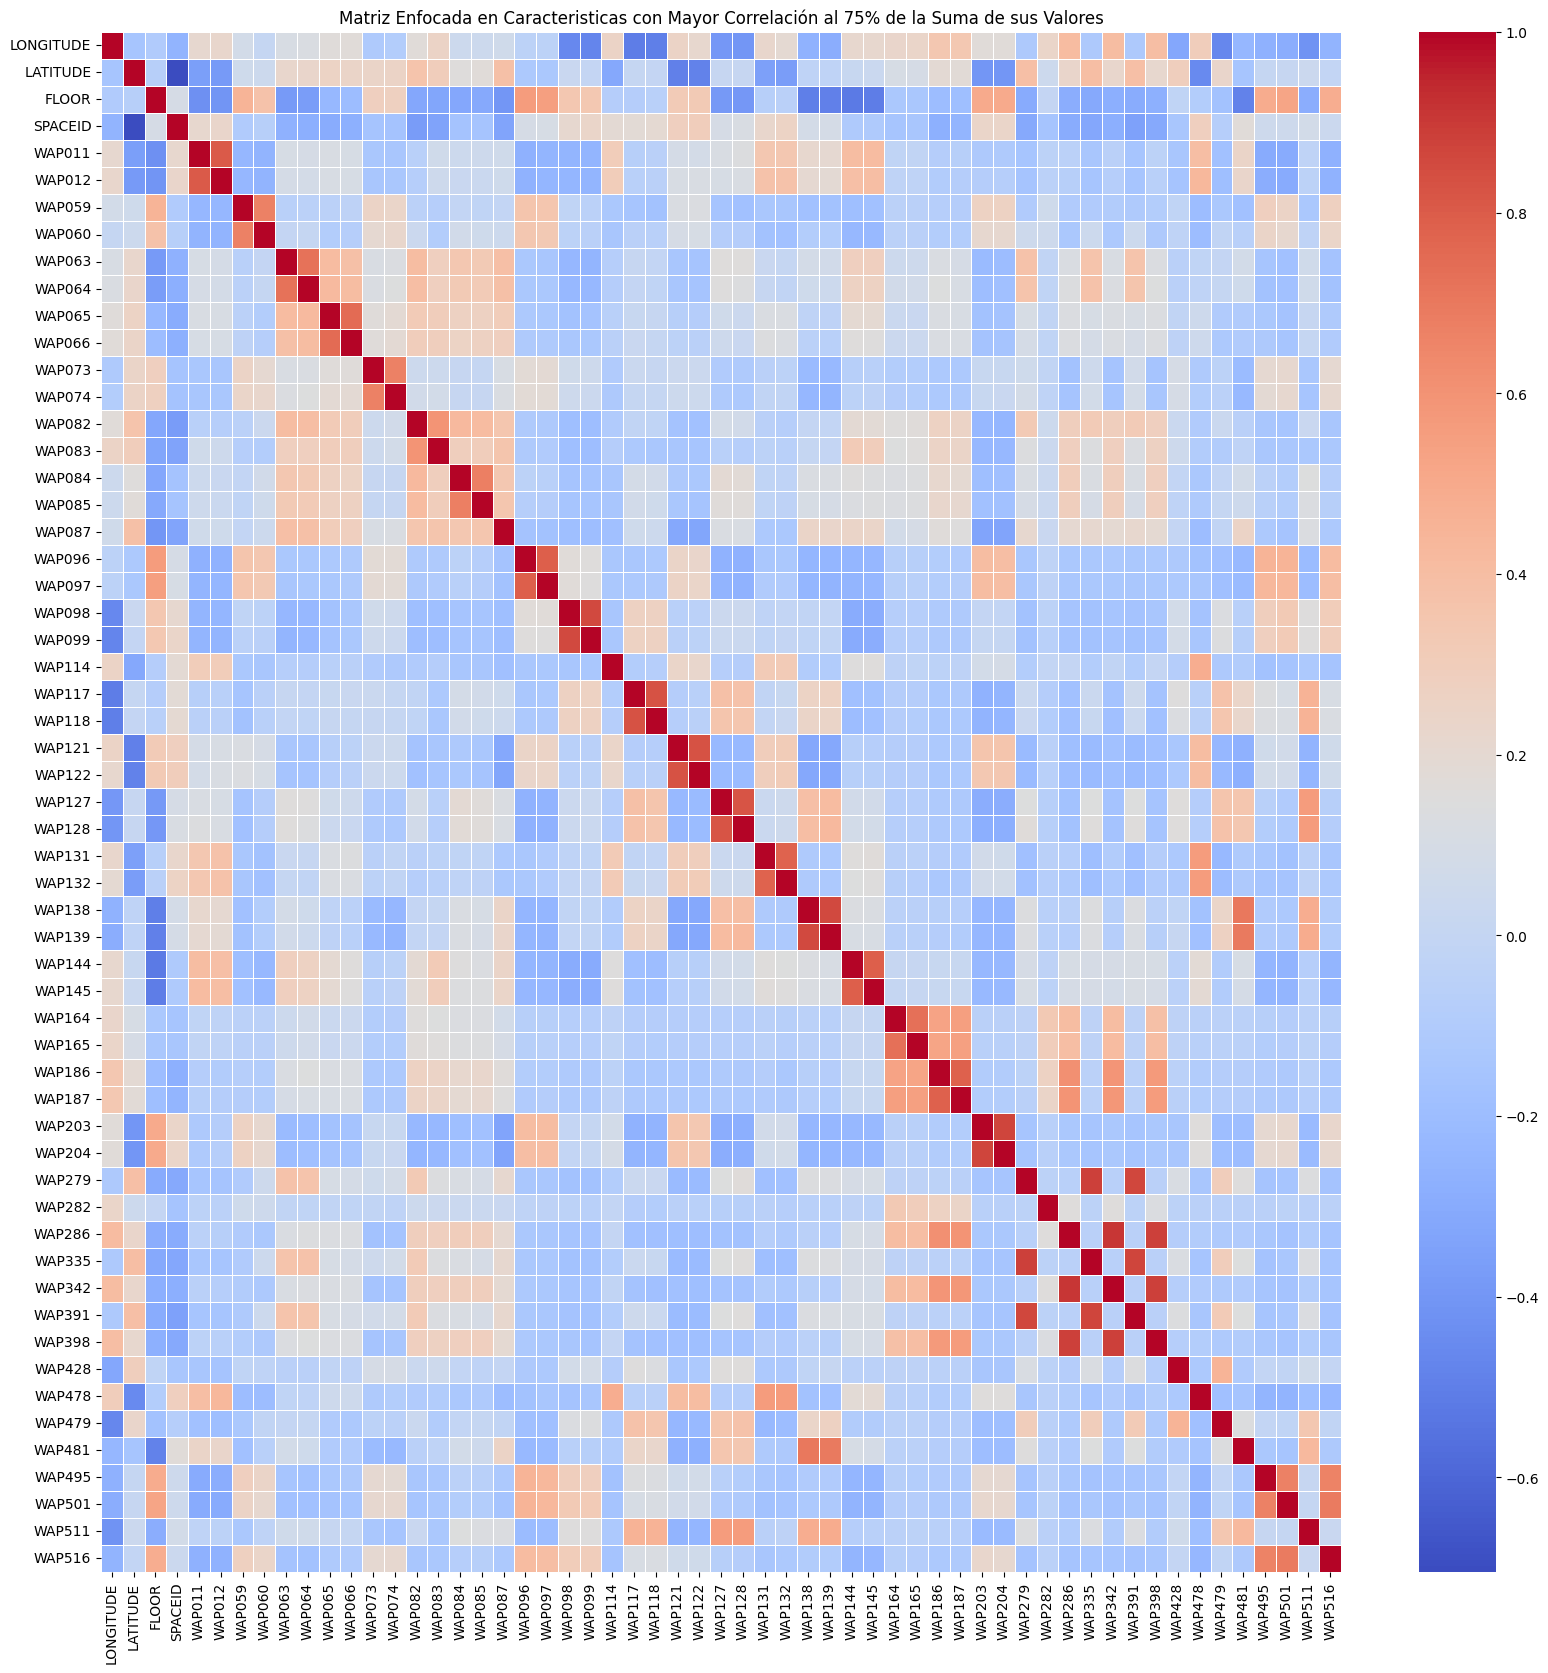

In [ ]:
columns_relevant = np.where((correlation_matrix.abs().sum()>=np.percentile(correlation_matrix.abs().sum(), 75))&(correlation_matrix.abs()!=1),correlation_matrix.index,0)
cols_waps = list(data[np.unique(columns_relevant[columns_relevant!=0])].drop(columns=['LONGITUDE', 'LATITUDE', 'FLOOR']).columns)
cols_waps.sort()
columns_of_interest = ['LONGITUDE', 'LATITUDE', 'FLOOR'] + cols_waps
plt.figure(figsize=(20, 20))
sns.heatmap(data[columns_of_interest].corr(), cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Matriz Enfocada en Caracteristicas con Mayor Correlación al 75% de la Suma de sus Valores')
plt.show()

In [ ]:
data = data[np.unique(columns_relevant[columns_relevant!=0])]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7777 entries, 2462 to 13672
Data columns (total 57 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FLOOR      7777 non-null   int64  
 1   LATITUDE   7777 non-null   float64
 2   LONGITUDE  7777 non-null   float64
 3   SPACEID    7777 non-null   int64  
 4   WAP011     7777 non-null   int64  
 5   WAP012     7777 non-null   int64  
 6   WAP059     7777 non-null   int64  
 7   WAP060     7777 non-null   int64  
 8   WAP063     7777 non-null   int64  
 9   WAP064     7777 non-null   int64  
 10  WAP065     7777 non-null   int64  
 11  WAP066     7777 non-null   int64  
 12  WAP073     7777 non-null   int64  
 13  WAP074     7777 non-null   int64  
 14  WAP082     7777 non-null   int64  
 15  WAP083     7777 non-null   int64  
 16  WAP084     7777 non-null   int64  
 17  WAP085     7777 non-null   int64  
 18  WAP087     7777 non-null   int64  
 19  WAP096     7777 non-null   int64  
 20  WAP0

### Tomando los atributos cuya suma de los valores de correlacion con las otras variables sea mayor al promedio de todas, podemos encontrar que muchas columnas no son relevantes para el modelo y quedarnos con las que pueden aportar mas al mismo.

## Normalizacion de los datos

## Se agrupan los datos de los espacios (SPACEID) para realizar una mejor normalizacion de los datos, se retira la columna SPACEID para utilizar el cluster.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


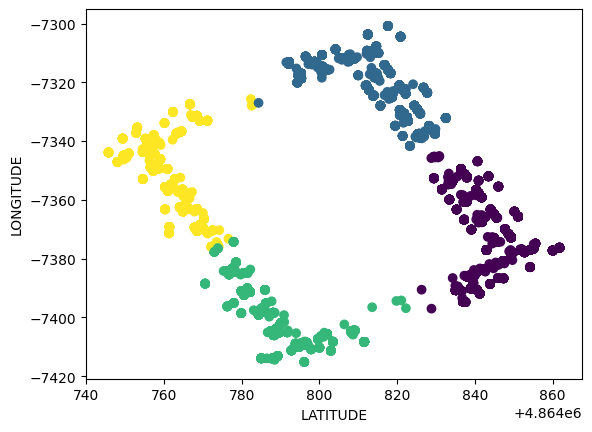

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)

kmeans.fit(data[["LATITUDE","LONGITUDE"]])

etiquetas = kmeans.labels_

data['SPACEID_cluster'] = etiquetas
data = data.drop(columns=["SPACEID"])

plt.scatter(data['LATITUDE'], data['LONGITUDE'], c=data['SPACEID_cluster'], cmap='viridis')
plt.xlabel('LATITUDE')
plt.ylabel('LONGITUDE')
plt.show()

In [ ]:
standard = StandardScaler()
data_standard = standard.fit_transform(data.drop(columns=["FLOOR","SPACEID_cluster"]))

onehot = OneHotEncoder(sparse_output=False)
data_onehot_floor  = pd.DataFrame(onehot.fit_transform(data[["FLOOR"]]),columns=["FLOOR0","FLOOR1","FLOOR2","FLOOR3","FLOOR4"])
data_onehot_spaceid  = pd.DataFrame(onehot.fit_transform(data[["SPACEID_cluster"]]),columns=["SPACE0","SPACE1","SPACE2","SPACE3"])

data_model = pd.concat([pd.DataFrame(data_standard,columns=data.drop(columns=["FLOOR","SPACEID_cluster"]).columns),data_onehot_floor,data_onehot_spaceid],axis=1)
data_model

LATITUDE  LONGITUDE    WAP011    WAP012    WAP059    WAP060    WAP063  \
0     0.694673  -1.242408 -1.693885 -1.676546  0.520473  0.578948 -1.430307   
1     0.112182   0.974553 -1.618997 -1.602017  0.520473  0.578948 -1.498738   
2    -2.075908   0.388081  0.652609  0.658687 -1.601778 -1.521868  0.713872   
3     1.417523  -0.707169  0.652609 -1.639281  0.520473  0.578948  0.713872   
4     0.990655   0.066010  0.652609  0.658687  0.520473 -1.924419  0.713872   
...        ...        ...       ...       ...       ...       ...       ...   
7772  1.064656  -0.410214 -1.381851 -1.390852  0.520473  0.578948  0.713872   
7773  0.112182   0.974553 -1.681404 -1.639281  0.520473  0.578948  0.713872   
7774 -0.280413   1.392608  0.652609  0.658687  0.520473  0.578948  0.713872   
7775  0.089346   1.013728 -1.544109  0.658687  0.520473  0.578948  0.713872   
7776 -0.023329   1.207102 -1.618997 -1.577174  0.520473  0.578948  0.713872   

        WAP064    WAP065    WAP066  ...    WAP516  FLOOR0  FLOOR1  FLOOR2  \
0    -1.429804 -1.309409 -1.272423  ...  0.670838     0.0     0.0     0.0   
1     0.716177  0.819176 -1.316831  ... -1.668349     0.0     0.0     0.0   
2     0.716177  0.819176  0.848075  ...  0.670838     1.0     0.0     0.0   
3     0.716177  0.819176  0.848075  ...  0.670838     0.0     1.0     0.0   
4     0.716177  0.819176  0.848075  ... -1.606136     1.0     0.0     0.0   
...        ...       ...       ...  ...       ...     ...     ...     ...   
7772  0.716177  0.819176  0.848075  ...  0.670838     0.0     0.0     0.0   
7773  0.716177  0.819176  0.848075  ...  0.670838     0.0     0.0     0.0   
7774  0.716177  0.819176  0.848075  ...  0.670838     0.0     0.0     1.0   
7775  0.716177 -1.264597  0.848075  ...  0.670838     0.0     0.0     0.0   
7776  0.716177 -1.343019 -1.305729  ...  0.670838     0.0     0.0     0.0   

      FLOOR3  FLOOR4  SPACE0  SPACE1  SPACE2  SPACE3  
0        0.0     1.0     1.0     0.0     0.0     0.0  
1        1.0     0.0     0.0     1.0     0.0     0.0  
2        0.0     0.0     0.0     0.0     0.0     1.0  
3        0.0     0.0     1.0     0.0     0.0     0.0  
4        0.0     0.0     1.0     0.0     0.0     0.0  
...      ...     ...     ...     ...     ...     ...  
7772     1.0     0.0     1.0     0.0     0.0     0.0  
7773     1.0     0.0     0.0     1.0     0.0     0.0  
7774     0.0     0.0     0.0     1.0     0.0     0.0  
7775     1.0     0.0     0.0     1.0     0.0     0.0  
7776     1.0     0.0     0.0     1.0     0.0     0.0  

[7777 rows x 64 columns]

## Dividimos los datos para realizar el respectivo entrenamiento y creamos la variable "X" y la variable "y".

In [ ]:
X = data_model.drop(columns=np.concatenate([["LATITUDE","LONGITUDE"],data_model.columns[-9:]]))
y = data_model[np.concatenate([["LATITUDE","LONGITUDE"],data_model.columns[-9:]])]

# MODELOS

## Creamos el modelo de RandomForestRegressor con 200 arboles y 10 trabajos en paralelo y entrenamos el mismo

In [ ]:
rfr_model = RandomForestRegressor(n_estimators=200,n_jobs=5, max_depth=10)
rfr_model.fit(X,y)

RandomForestRegressor(max_depth=10, n_estimators=200, n_jobs=5)

### Calculamos el error cuadratico medio (mse), la raiz del error cuadratico medio (rmse), el error absoluto medio (mae) y el $R^2$ de los datos de entrenamiento para evaluar el modelo

In [ ]:
y_pred = rfr_model.predict(X)

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Error Cuadrático Medio (MSE): {mse:.5f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.5f}")
print(f"Error Absoluto Medio (MAE): {mae:.5f}")
print(f"R cuadrado (R^2): {r2:.2f}")

Error Cuadrático Medio (MSE): 0.01778
Raíz del Error Cuadrático Medio (RMSE): 0.13336
Error Absoluto Medio (MAE): 0.05220
R cuadrado (R^2): 0.94


### << ANALISIS DE RESULTADO >>

El modelo RandomForestRegressor muestra un alto grado de precisión, con un $R^2$ de $0.94$, indicando que puede explicar el $94\%$ de la variabilidad en los datos de entrenamiento. Las métricas MSE, RMSE y MAE son relativamente bajas, lo que indica que el modelo tiene un buen rendimiento en los datos de entrenamiento.

## Creamos un modelo SVM básico con SVC de sklearn y entrenamos el mismo

In [ ]:
svm = SVR(kernel='poly')
model_svm = MultiOutputRegressor(svm)
model_svm.fit(X, y)

MultiOutputRegressor(estimator=SVR(kernel='poly'))

### Calculamos el error cuadratico medio (mse), la raiz del error cuadratico medio (rmse), el error absoluto medio (mae) y el $R^2$ de los datos de entrenamiento para evaluar el modelo

In [ ]:
y_pred = model_svm.predict(X)

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Error Cuadrático Medio (MSE): {mse:.5f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.5f}")
print(f"Error Absoluto Medio (MAE): {mae:.5f}")
print(f"R cuadrado (R^2): {r2:.2f}")

Error Cuadrático Medio (MSE): 0.02059
Raíz del Error Cuadrático Medio (RMSE): 0.14351
Error Absoluto Medio (MAE): 0.08619
R cuadrado (R^2): 0.93


### << ANALISIS DE RESULTADO >>

El modelo SVM presenta una precisión ligeramente menor que el modelo RandomForestRegressor con un $R^2$ de $0.93$. Sin embargo, sigue siendo un modelo con un rendimiento robusto, siendo capaz de explicar el $93\%$ de la variabilidad en los datos de entrenamiento. El MSE y RMSE son un poco más altos que en el modelo RandomForest, pero todavía están en un rango aceptable.

## Creamos una red neuronal densa con una capa de entrada de 53 Neuronas que son las 53 caracteristicas de los datos, 4 capas ocultas de 120 neuronas cada una mas una de 60 neuronas y una capa de salida de 11 que son las 11 caracteristicas de predicción para dar con la posición casi exacta del usuario

In [ ]:
tf.random.set_seed(30)
tf.keras.backend.clear_session()

model_nn = tf.keras.Sequential()

model_nn.add(tf.keras.layers.Input(shape=X.shape[1]))
model_nn.add(tf.keras.layers.Dense(240, activation='relu'))
model_nn.add(tf.keras.layers.Dropout(0.2))
model_nn.add(tf.keras.layers.Dense(240, activation='relu'))
model_nn.add(tf.keras.layers.Dropout(0.2))
model_nn.add(tf.keras.layers.Dense(240, activation='relu'))
model_nn.add(tf.keras.layers.Dropout(0.2))
model_nn.add(tf.keras.layers.Dense(120, activation='relu'))
model_nn.add(tf.keras.layers.Dropout(0.2))
model_nn.add(tf.keras.layers.Dense(60, activation='relu'))
model_nn.add(tf.keras.layers.Dense(11, activation='tanh'))
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 240)               12960     
                                                                 
 dropout (Dropout)           (None, 240)               0         
                                                                 
 dense_1 (Dense)             (None, 240)               57840     
                                                                 
 dropout_1 (Dropout)         (None, 240)               0         
                                                                 
 dense_2 (Dense)             (None, 240)               57840     
                                                                 
 dropout_2 (Dropout)         (None, 240)               0         
                                                                 
 dense_3 (Dense)             (None, 120)               2

### Se compila el modelo para regresión, se utiliza el optimizador Adam, una perdidad evaluada con mse y la metrica de binary accuracy

In [ ]:
model_nn.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.mse,
              metrics=tf.keras.metrics.BinaryAccuracy())

### Se realiza el entrenamiento con 100 iteraciones, una validación cruzada del 10% de los datos y un batch_size de 16.

In [ ]:
history = model_nn.fit(X,
                    y,
                    epochs=100,
                    validation_split=0.10,
                    batch_size=16)

Epoch 1/100
438/438 [==============================] - 4s 5ms/step - loss: 0.1293 - binary_accuracy: 0.7339 - val_loss: 0.0733 - val_binary_accuracy: 0.7817
Epoch 2/100
438/438 [==============================] - 2s 4ms/step - loss: 0.0777 - binary_accuracy: 0.7790 - val_loss: 0.0573 - val_binary_accuracy: 0.7903
Epoch 3/100
438/438 [==============================] - 2s 4ms/step - loss: 0.0660 - binary_accuracy: 0.7860 - val_loss: 0.0561 - val_binary_accuracy: 0.7921
Epoch 4/100
438/438 [==============================] - 2s 4ms/step - loss: 0.0587 - binary_accuracy: 0.7913 - val_loss: 0.0516 - val_binary_accuracy: 0.7964
Epoch 5/100
438/438 [==============================] - 2s 4ms/step - loss: 0.0541 - binary_accuracy: 0.7948 - val_loss: 0.0536 - val_binary_accuracy: 0.7939
Epoch 6/100
438/438 [==============================] - 2s 5ms/step - loss: 0.0512 - binary_accuracy: 0.7967 - val_loss: 0.0514 - val_binary_accuracy: 0.7963
Epoch 7/100
438/438 [==============================] - 2s 

### Se validan los datos

<Axes: xlabel='Epoch'>

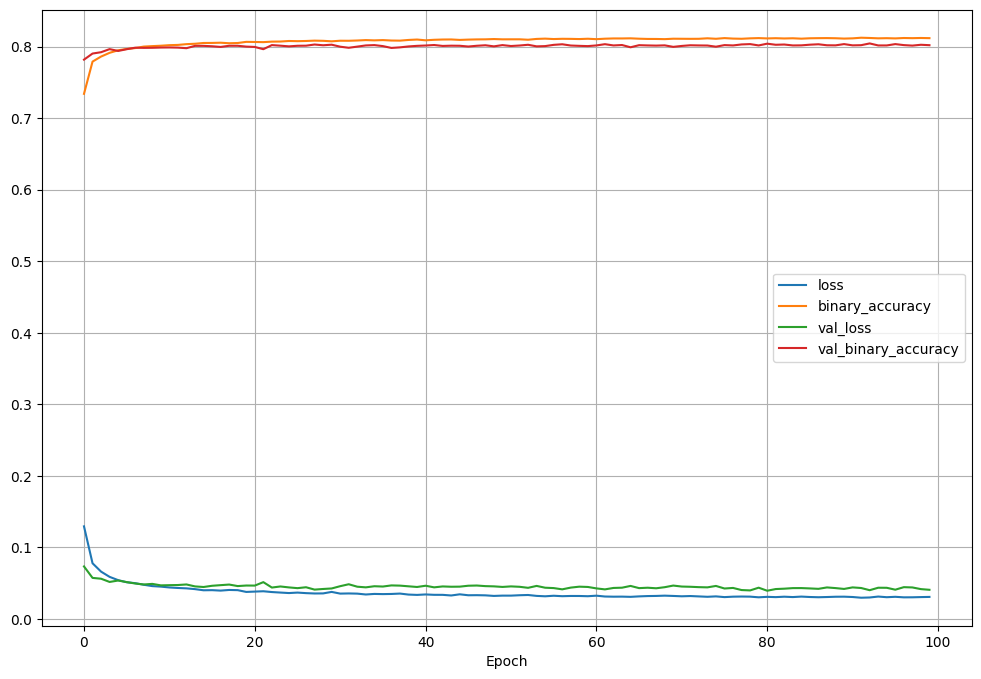

In [ ]:
pd.DataFrame(history.history).plot(figsize=(12, 8),
                                   grid=True,
                                   xlabel='Epoch',
                                   )

### Calculamos el error cuadratico medio (mse), la raiz del error cuadratico medio (rmse), el error absoluto medio (mae) y el $R^2$ de los datos de entrenamiento para evaluar el modelo

In [ ]:
y_pred = model_nn.predict(X)

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Error Cuadrático Medio (MSE): {mse:.5f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.5f}")
print(f"Error Absoluto Medio (MAE): {mae:.5f}")
print(f"R cuadrado (R^2): {r2:.2f}")

244/244 [==============================] - 1s 2ms/step
Error Cuadrático Medio (MSE): 0.02688
Raíz del Error Cuadrático Medio (RMSE): 0.16394
Error Absoluto Medio (MAE): 0.05477
R cuadrado (R^2): 0.95


### << ANALISIS DE RESULTADO >>

La red neuronal densa presenta un alto grado de precisión con un coeficiente de determinación $R^2$ de $0.95$, lo que indica que puede explicar el $95\%$ de la variabilidad en los datos de entrenamiento. Las métricas MSE, RMSE y MAE sugieren que el modelo tiene un rendimiento sólido en los datos de entrenamiento. La gráfica muestra una evolución estable de las métricas de entrenamiento, lo que refleja un aprendizaje eficaz y una posible convergencia temprana del modelo.


## Se almacenan los modelos ceados:

1.   K-means
2.   Random Forest Regressor
3.   SVM
4.   Red Neuronal Densa



In [ ]:
with open("KMeans_Model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

with open("RandomForest_Model.pkl", "wb") as f:
    pickle.dump(rfr_model, f)

with open("SVM_Model.pkl", "wb") as f:
    pickle.dump(model_svm, f)

model_nn.save("NN_Dense_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Ejecución de modelos con los datos de Prueba

## Carga de modelos

In [ ]:
kmeans = pickle.load(open("KMeans_Model.pkl", "rb"))
ranfor = pickle.load(open("RandomForest_Model.pkl", "rb"))
svm_mod = pickle.load(open("SVM_Model.pkl", "rb"))
nn_dense = tf.keras.models.load_model("NN_Dense_model.h5")

## Preprocesamiento datos de prueba

### Generamos una copia de los datos de prueba para trabajar con ellos

In [ ]:
data_copy = data_test.copy()

### Predecimos el SPACEID_cluster de los datos de prueba con el modelo de kmeans cargado

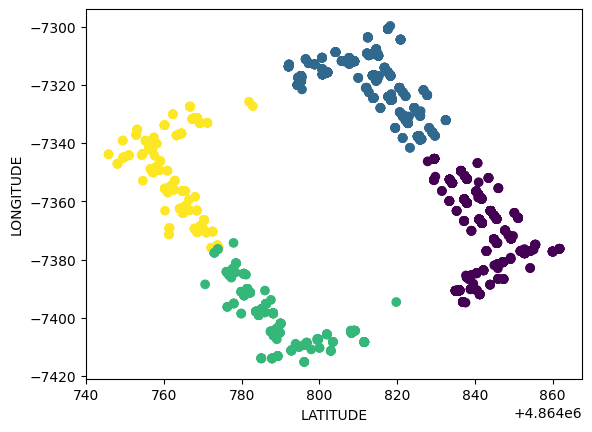

In [ ]:
data_copy['SPACEID_cluster'] = kmeans.predict(data_copy[["LATITUDE","LONGITUDE"]])
data_copy = data_copy.drop(columns=["SPACEID"])

plt.scatter(data_copy['LATITUDE'], data_copy['LONGITUDE'], c=data_copy['SPACEID_cluster'], cmap='viridis')
plt.xlabel('LATITUDE')
plt.ylabel('LONGITUDE')
plt.show()

### Creamos dos variables con las columnas que se utilizaran para probar los modelos previamente cargados

In [ ]:
columnas_X = [
          'WAP011', 'WAP012', 'WAP059', 'WAP060', 'WAP063', 'WAP064', 'WAP065', 'WAP066', 'WAP073',
          'WAP074', 'WAP082', 'WAP083', 'WAP084', 'WAP085', 'WAP087', 'WAP096', 'WAP097', 'WAP098',
          'WAP099', 'WAP114', 'WAP117', 'WAP118', 'WAP121', 'WAP122', 'WAP127', 'WAP128', 'WAP131',
          'WAP132', 'WAP138', 'WAP139', 'WAP144', 'WAP145', 'WAP164', 'WAP165', 'WAP186', 'WAP187',
          'WAP203', 'WAP204', 'WAP279', 'WAP282', 'WAP286', 'WAP335', 'WAP342', 'WAP391', 'WAP398',
          'WAP428', 'WAP478', 'WAP479', 'WAP481', 'WAP495', 'WAP501', 'WAP511', 'WAP516'
       ]
columnas_Y = [
            'LATITUDE', 'LONGITUDE', 'FLOOR0', 'FLOOR1', 'FLOOR2',
            'FLOOR3', 'FLOOR4', 'SPACE0', 'SPACE1', 'SPACE2', 'SPACE3'
            ]

### Se estandarizan los datos aplicando tecnica de escalado y conversión de datos categoricos

In [ ]:
standard = StandardScaler()
data_standard = standard.fit_transform(data_copy.drop(columns=["FLOOR","SPACEID_cluster"]))

onehot = OneHotEncoder(sparse_output=False)
data_onehot_floor  = pd.DataFrame(onehot.fit_transform(data_copy[["FLOOR"]]),columns=["FLOOR0","FLOOR1","FLOOR2","FLOOR3","FLOOR4"])
data_onehot_spaceid  = pd.DataFrame(onehot.fit_transform(data_copy[["SPACEID_cluster"]]),columns=["SPACE0","SPACE1","SPACE2","SPACE3"])

data_model_test = pd.concat([pd.DataFrame(data_standard,columns=data_copy.drop(columns=["FLOOR","SPACEID_cluster"]).columns),data_onehot_floor,data_onehot_spaceid],axis=1)
data_model_test

WAP001  WAP002  WAP003  WAP004    WAP005    WAP006  WAP007  WAP008  \
0        0.0     0.0     0.0     0.0  0.059989  0.045314     0.0     0.0   
1        0.0     0.0     0.0     0.0  0.059989  0.045314     0.0     0.0   
2        0.0     0.0     0.0     0.0  0.059989  0.045314     0.0     0.0   
3        0.0     0.0     0.0     0.0  0.059989  0.045314     0.0     0.0   
4        0.0     0.0     0.0     0.0  0.059989  0.045314     0.0     0.0   
...      ...     ...     ...     ...       ...       ...     ...     ...   
1947     0.0     0.0     0.0     0.0  0.059989  0.045314     0.0     0.0   
1948     0.0     0.0     0.0     0.0  0.059989  0.045314     0.0     0.0   
1949     0.0     0.0     0.0     0.0  0.059989  0.045314     0.0     0.0   
1950     0.0     0.0     0.0     0.0  0.059989  0.045314     0.0     0.0   
1951     0.0     0.0     0.0     0.0  0.059989  0.045314     0.0     0.0   

      WAP009  WAP010  ...  TIMESTAMP  FLOOR0  FLOOR1  FLOOR2  FLOOR3  FLOOR4  \
0        0.0     0.0  ...  -0.162020     0.0     0.0     1.0     0.0     0.0   
1        0.0     0.0  ...  -0.160507     0.0     1.0     0.0     0.0     0.0   
2        0.0     0.0  ...  -0.162762     0.0     0.0     0.0     1.0     0.0   
3        0.0     0.0  ...  -0.163189     0.0     0.0     0.0     1.0     0.0   
4        0.0     0.0  ...  -0.162543     1.0     0.0     0.0     0.0     0.0   
...      ...     ...  ...        ...     ...     ...     ...     ...     ...   
1947     0.0     0.0  ...   6.090798     0.0     0.0     0.0     0.0     1.0   
1948     0.0     0.0  ...  -0.162329     0.0     1.0     0.0     0.0     0.0   
1949     0.0     0.0  ...  -0.163244     0.0     0.0     0.0     0.0     1.0   
1950     0.0     0.0  ...  -0.163090     0.0     0.0     0.0     1.0     0.0   
1951     0.0     0.0  ...  -0.162010     0.0     0.0     1.0     0.0     0.0   

      SPACE0  SPACE1  SPACE2  SPACE3  
0        1.0     0.0     0.0     0.0  
1        1.0     0.0     0.0     0.0  
2        0.0     0.0     0.0     1.0  
3        0.0     0.0     1.0     0.0  
4        1.0     0.0     0.0     0.0  
...      ...     ...     ...     ...  
1947     0.0     1.0     0.0     0.0  
1948     1.0     0.0     0.0     0.0  
1949     1.0     0.0     0.0     0.0  
1950     0.0     0.0     1.0     0.0  
1951     1.0     0.0     0.0     0.0  

[1952 rows x 536 columns]

### Dividimos los datos que son de "X" y las etiquetas "y"

In [ ]:
X = data_model_test[columnas_X]
y = data_model_test[columnas_Y]

## Ejecución de modelos con los datos de prueba

### RandomForest

In [ ]:
y_pred = ranfor.predict(X)

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Error Cuadrático Medio (MSE): {mse:.5f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.5f}")
print(f"Error Absoluto Medio (MAE): {mae:.5f}")
print(f"R cuadrado (R^2): {r2:.2f}")

Error Cuadrático Medio (MSE): 0.03287
Raíz del Error Cuadrático Medio (RMSE): 0.18130
Error Absoluto Medio (MAE): 0.07531
R cuadrado (R^2): 0.89


### << ANALISIS DE RESULTADO >>
El modelo RandomForest ha demostrado una buena capacidad predictiva, con un coeficiente de determinación \( R^2 \) de 0.89, lo que indica que el modelo puede explicar el 89\% de la variabilidad de los datos. El RMSE, que es una métrica que nos indica el error promedio de nuestras predicciones, es razonablemente bajo.

### SVM (Support Vector Machine)

In [ ]:
y_pred = svm_mod.predict(X)

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Error Cuadrático Medio (MSE): {mse:.5f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.5f}")
print(f"Error Absoluto Medio (MAE): {mae:.5f}")
print(f"R cuadrado (R^2): {r2:.2f}")

Error Cuadrático Medio (MSE): 0.03601
Raíz del Error Cuadrático Medio (RMSE): 0.18975
Error Absoluto Medio (MAE): 0.11176
R cuadrado (R^2): 0.87


### << ANALISIS DE RESULTADO >>
El modelo SVM presenta un rendimiento ligeramente inferior al modelo RandomForest. Aunque el \( R^2 \) sigue siendo alto, el MAE es más grande, lo que sugiere que, en promedio, las predicciones del modelo SVM están más alejadas de los valores reales que las del modelo RandomForest.

### Red neuronal densa

In [ ]:
y_pred = nn_dense.predict(X)

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Error Cuadrático Medio (MSE): {mse:.5f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.5f}")
print(f"Error Absoluto Medio (MAE): {mae:.5f}")
print(f"R cuadrado (R^2): {r2:.2f}")

61/61 [==============================] - 0s 2ms/step
Error Cuadrático Medio (MSE): 0.04196
Raíz del Error Cuadrático Medio (RMSE): 0.20484
Error Absoluto Medio (MAE): 0.07024
R cuadrado (R^2): 0.89


### << ANALISIS DE RESULTADO >>
La Red Neuronal Densa tiene un rendimiento comparable al modelo RandomForest en términos de \( R^2 \). Sin embargo, su RMSE es más alto, lo que indica que las predicciones del modelo tienen un mayor error en promedio. A pesar de ello, el MAE es competitivo, lo que sugiere que las predicciones del modelo suelen estar cerca de los valores reales, pero pueden existir algunos errores significativos que afectan el RMSE.

# USO DE AUTOENCODER

## Realizamos una copia de los datos utilizados para entrenar los modelos previos pero en esta ocasión vamos a utilizar todas las columnas WAP para que con ayuda de un autoencoder seleccionar las 53 caracteristicas mas relevantes.

In [ ]:
data_encod = data_org.copy()
data_encod

WAP001  WAP002  WAP003  WAP004  WAP005  WAP006  WAP007  WAP008  WAP009  \
2462      100     100     100     100     100     100     100     100     100   
11026     100     100     100     100     100     100     100     100     100   
5822      100     100     100     100     100     100     100     100     100   
14554     100     100     100     100     100     100     100     100     100   
18648     100     100     100     100     100     100     100     100     100   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
11465     100     100     100     100     100     100     100     100     100   
9655      100     100     100     100     100     100     100     100     100   
10216     100     100     100     100     100     100     100     100     100   
1707      100     100     100     100     100     100     100     100     100   
13672     100     100     100     100     100     100     100     100     100   

       WAP010  ...  WAP516  WAP517  WAP518  WAP519  WAP520    LONGITUDE  \
2462      100  ...     100     -87     100     100     100 -7390.761200   
11026     100  ...     -88     100     100     100     100 -7325.052900   
5822      100  ...     100     100     100     100     100 -7342.435300   
14554     100  ...     100     100     100     100     100 -7374.897300   
18648     100  ...     -83     100     100     100     100 -7351.981125   
...       ...  ...     ...     ...     ...     ...     ...          ...   
11465     100  ...     100     -87     100     100     100 -7366.095900   
9655      100  ...     100     -83     100     100     100 -7325.052900   
10216     100  ...     100     100     100     100     100 -7312.662200   
1707      100  ...     100     100     100     100     100 -7323.891800   
13672     100  ...     100     100     100     100     100 -7318.160400   

           LATITUDE  FLOOR  SPACEID  RELATIVEPOSITION  
2462   4.864835e+06      4      147                 2  
11026  4.864819e+06      3      124                 2  
5822   4.864757e+06      0      207                 2  
14554  4.864856e+06      1      105                 2  
18648  4.864843e+06      0      140                 1  
...             ...    ...      ...               ...  
11465  4.864846e+06      3      108                 2  
9655   4.864819e+06      3      124                 2  
10216  4.864808e+06      2      136                 2  
1707   4.864818e+06      3      125                 2  
13672  4.864815e+06      3      126                 2  

[7808 rows x 525 columns]

### Se encuentran 59 registros en los cuales las mediciones de todos los WAP indican si deteccion pero cuentan con diferentes valores en longitud, latitud y Piso lo que puede ocasionar un mal entrenamiento en el modelo, estos registros se eliminaran

In [ ]:
data_encod = data_encod[data_encod[data_encod.columns[:-5]].mean(axis=1)!=100]
data_encod

WAP001  WAP002  WAP003  WAP004  WAP005  WAP006  WAP007  WAP008  WAP009  \
2462      100     100     100     100     100     100     100     100     100   
11026     100     100     100     100     100     100     100     100     100   
5822      100     100     100     100     100     100     100     100     100   
14554     100     100     100     100     100     100     100     100     100   
18648     100     100     100     100     100     100     100     100     100   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
11465     100     100     100     100     100     100     100     100     100   
9655      100     100     100     100     100     100     100     100     100   
10216     100     100     100     100     100     100     100     100     100   
1707      100     100     100     100     100     100     100     100     100   
13672     100     100     100     100     100     100     100     100     100   

       WAP010  ...  WAP516  WAP517  WAP518  WAP519  WAP520    LONGITUDE  \
2462      100  ...     100     -87     100     100     100 -7390.761200   
11026     100  ...     -88     100     100     100     100 -7325.052900   
5822      100  ...     100     100     100     100     100 -7342.435300   
14554     100  ...     100     100     100     100     100 -7374.897300   
18648     100  ...     -83     100     100     100     100 -7351.981125   
...       ...  ...     ...     ...     ...     ...     ...          ...   
11465     100  ...     100     -87     100     100     100 -7366.095900   
9655      100  ...     100     -83     100     100     100 -7325.052900   
10216     100  ...     100     100     100     100     100 -7312.662200   
1707      100  ...     100     100     100     100     100 -7323.891800   
13672     100  ...     100     100     100     100     100 -7318.160400   

           LATITUDE  FLOOR  SPACEID  RELATIVEPOSITION  
2462   4.864835e+06      4      147                 2  
11026  4.864819e+06      3      124                 2  
5822   4.864757e+06      0      207                 2  
14554  4.864856e+06      1      105                 2  
18648  4.864843e+06      0      140                 1  
...             ...    ...      ...               ...  
11465  4.864846e+06      3      108                 2  
9655   4.864819e+06      3      124                 2  
10216  4.864808e+06      2      136                 2  
1707   4.864818e+06      3      125                 2  
13672  4.864815e+06      3      126                 2  

[7777 rows x 525 columns]

In [ ]:
X = data_encod[data_encod.columns[:-5]]
y = data_encod[data_encod.columns[-5:]]

## Creación de autoencoder

### Se declara una red neuronal que funcionara como autoencoder para reducir a 56 caracteristicas la dimensionalidad de los WAP

In [ ]:
tf.random.set_seed(30)
tf.keras.backend.clear_session()

autoencoder = tf.keras.Sequential()

autoencoder.add(tf.keras.layers.Input(shape=X.shape[1]))
autoencoder.add(tf.keras.layers.Dense(250, activation="relu"))
autoencoder.add(tf.keras.layers.Dense(125, activation="relu"))
autoencoder.add(tf.keras.layers.Dense(56, activation="relu"))

autoencoder.add(tf.keras.layers.Dense(56, activation="relu"))
autoencoder.add(tf.keras.layers.Dense(125, activation="relu"))
autoencoder.add(tf.keras.layers.Dense(250, activation="relu"))
autoencoder.add(tf.keras.layers.Dense(X.shape[1], activation="sigmoid"))

autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 250)               130250    
                                                                 
 dense_1 (Dense)             (None, 125)               31375     
                                                                 
 dense_2 (Dense)             (None, 56)                7056      
                                                                 
 dense_3 (Dense)             (None, 56)                3192      
                                                                 
 dense_4 (Dense)             (None, 125)               7125      
                                                                 
 dense_5 (Dense)             (None, 250)               31500     
                                                                 
 dense_6 (Dense)             (None, 520)               1

### Se compila el autoencoder utilizando adam y la perdida MSE

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')

Se entrena el modelo con 10 epocas

In [ ]:
autoencoder.fit(X, X, epochs=10)

Epoch 1/10
244/244 [==============================] - 4s 9ms/step - loss: 9699.2158
Epoch 2/10
244/244 [==============================] - 2s 8ms/step - loss: 9695.5039
Epoch 3/10
244/244 [==============================] - 2s 10ms/step - loss: 9695.3848
Epoch 4/10
244/244 [==============================] - 3s 12ms/step - loss: 9695.3848
Epoch 5/10
244/244 [==============================] - 2s 8ms/step - loss: 9695.3857
Epoch 6/10
244/244 [==============================] - 3s 11ms/step - loss: 9695.3867
Epoch 7/10
244/244 [==============================] - 2s 8ms/step - loss: 9695.3906
Epoch 8/10
244/244 [==============================] - 2s 7ms/step - loss: 9695.3857
Epoch 9/10
244/244 [==============================] - 2s 7ms/step - loss: 9695.3867
Epoch 10/10
244/244 [==============================] - 2s 7ms/step - loss: 9695.3164


In [ ]:
latent_features = autoencoder.predict(X)
n = 56
most_relevant_features = np.argsort(latent_features)[:,:n]

244/244 [==============================] - 1s 3ms/step


In [ ]:
X = X[X.columns[np.sort(most_relevant_features[0])]]
display(X)
display(y)

WAP002  WAP017  WAP060  WAP065  WAP077  WAP078  WAP089  WAP093  WAP138  \
2462      100     100     100     -90     100     -91     100     100     100   
11026     100     100     100     100     100     100     100     100     -81   
5822      100     100     -67     100     100     100     100     100     100   
14554     100     100     100     100     100     100     100     100     100   
18648     100     100     -99     100     100     100     100     100     100   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
11465     100     100     100     100     100     100     100     100     100   
9655      100     100     100     100     -95     100     100     100     -86   
10216     100     100     100     100     -90     -91     100     100     100   
1707      100     100     100     -86     100     100     100     100     -75   
13672     100     100     100     -93     100     100     100     100     -71   

       WAP141  ...  WAP422  WAP431  WAP432  WAP434  WAP437  WAP478  WAP483  \
2462      100  ...     100     100     100     100     100     100     100   
11026     100  ...     100     100     100     100     100     100     -79   
5822      100  ...     100     100     100     100     100     100     100   
14554     100  ...     100     100     100     100     100     -73     100   
18648     100  ...     100     100     100     100     100     100     100   
...       ...  ...     ...     ...     ...     ...     ...     ...     ...   
11465     100  ...     100     100     100     100     100     100     100   
9655      100  ...     100     100     100     100     100     100     -79   
10216     100  ...     100     100     100     100     100     100     100   
1707      100  ...     100     100     100     100     100     100     -67   
13672     100  ...     100     100     100     100     100     100     -73   

       WAP496  WAP497  WAP517  
2462      100     100     -87  
11026     100     100     100  
5822      -84     100     100  
14554     100     100     100  
18648     100     100     100  
...       ...     ...     ...  
11465     -88     100     -87  
9655      100     100     -83  
10216     100     100     100  
1707      100     100     100  
13672     100     100     100  

[7777 rows x 56 columns]

LONGITUDE      LATITUDE  FLOOR  SPACEID  RELATIVEPOSITION
2462  -7390.761200  4.864835e+06      4      147                 2
11026 -7325.052900  4.864819e+06      3      124                 2
5822  -7342.435300  4.864757e+06      0      207                 2
14554 -7374.897300  4.864856e+06      1      105                 2
18648 -7351.981125  4.864843e+06      0      140                 1
...            ...           ...    ...      ...               ...
11465 -7366.095900  4.864846e+06      3      108                 2
9655  -7325.052900  4.864819e+06      3      124                 2
10216 -7312.662200  4.864808e+06      2      136                 2
1707  -7323.891800  4.864818e+06      3      125                 2
13672 -7318.160400  4.864815e+06      3      126                 2

[7777 rows x 5 columns]

<ipython-input-68-4e02b4216836>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['SPACEID_cluster'] = kmeans.predict(y[["LATITUDE","LONGITUDE"]])


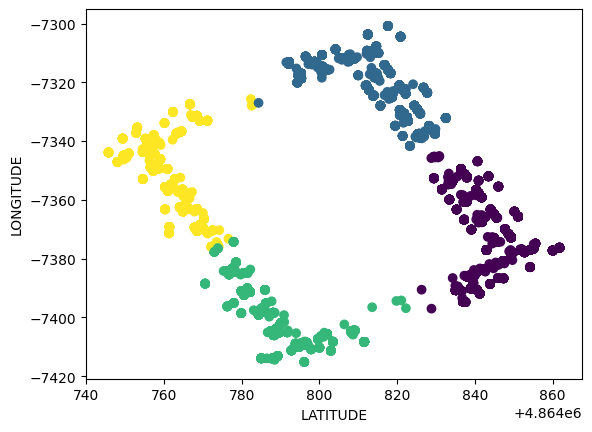

In [ ]:
y['SPACEID_cluster'] = kmeans.predict(y[["LATITUDE","LONGITUDE"]])
y = y.drop(columns=["SPACEID"])

plt.scatter(y['LATITUDE'], y['LONGITUDE'], c=y['SPACEID_cluster'], cmap='viridis')
plt.xlabel('LATITUDE')
plt.ylabel('LONGITUDE')
plt.show()

In [ ]:
standard = StandardScaler()
X_transform = pd.DataFrame(standard.fit_transform(X),columns=X.columns)
y_transfom = pd.DataFrame(standard.fit_transform(y[["LATITUDE","LONGITUDE"]]),columns=["LATITUDE","LONGITUDE"])

onehot = OneHotEncoder(sparse_output=False)
y_transform1  = pd.DataFrame(onehot.fit_transform(y[["FLOOR"]]),columns=["FLOOR0","FLOOR1","FLOOR2","FLOOR3","FLOOR4"])
y_transform2  = pd.DataFrame(onehot.fit_transform(y[["SPACEID_cluster"]]),columns=["SPACE0","SPACE1","SPACE2","SPACE3"])

y_transform = pd.concat([y_transfom,y_transform1,y_transform2],axis=1)

In [ ]:
display(X_transform)

WAP002  WAP017    WAP060    WAP065    WAP077    WAP078  WAP089  WAP093  \
0        0.0     0.0  0.578948 -1.309409  0.909948 -1.154911     0.0     0.0   
1        0.0     0.0  0.578948  0.819176  0.909948  0.935781     0.0     0.0   
2        0.0     0.0 -1.521868  0.819176  0.909948  0.935781     0.0     0.0   
3        0.0     0.0  0.578948  0.819176  0.909948  0.935781     0.0     0.0   
4        0.0     0.0 -1.924419  0.819176  0.909948  0.935781     0.0     0.0   
...      ...     ...       ...       ...       ...       ...     ...     ...   
7772     0.0     0.0  0.578948  0.819176  0.909948  0.935781     0.0     0.0   
7773     0.0     0.0  0.578948  0.819176 -1.228037  0.935781     0.0     0.0   
7774     0.0     0.0  0.578948  0.819176 -1.173217 -1.154911     0.0     0.0   
7775     0.0     0.0  0.578948 -1.264597  0.909948  0.935781     0.0     0.0   
7776     0.0     0.0  0.578948 -1.343019  0.909948  0.935781     0.0     0.0   

        WAP138    WAP141  ...    WAP422    WAP431    WAP432  WAP434    WAP437  \
0     0.502934  0.109988  ...  0.071874  0.016038  0.122472     0.0  0.019644   
1    -2.030755  0.109988  ...  0.071874  0.016038  0.122472     0.0  0.019644   
2     0.502934  0.109988  ...  0.071874  0.016038  0.122472     0.0  0.019644   
3     0.502934  0.109988  ...  0.071874  0.016038  0.122472     0.0  0.019644   
4     0.502934  0.109988  ...  0.071874  0.016038  0.122472     0.0  0.019644   
...        ...       ...  ...       ...       ...       ...     ...       ...   
7772  0.502934  0.109988  ...  0.071874  0.016038  0.122472     0.0  0.019644   
7773 -2.100746  0.109988  ...  0.071874  0.016038  0.122472     0.0  0.019644   
7774  0.502934  0.109988  ...  0.071874  0.016038  0.122472     0.0  0.019644   
7775 -1.946765  0.109988  ...  0.071874  0.016038  0.122472     0.0  0.019644   
7776 -1.890772  0.109988  ...  0.071874  0.016038  0.122472     0.0  0.019644   

        WAP478    WAP483    WAP496   WAP497    WAP517  
0     0.483340  0.265983  0.995074  0.01134 -1.186907  
1     0.483340 -3.773452  0.995074  0.01134  0.932691  
2     0.483340  0.265983 -1.082091  0.01134  0.932691  
3    -1.994042  0.265983  0.995074  0.01134  0.932691  
4     0.483340  0.265983  0.995074  0.01134  0.932691  
...        ...       ...       ...      ...       ...  
7772  0.483340  0.265983 -1.127246  0.01134 -1.186907  
7773  0.483340 -3.773452  0.995074  0.01134 -1.141568  
7774  0.483340  0.265983  0.995074  0.01134  0.932691  
7775  0.483340 -3.502652  0.995074  0.01134  0.932691  
7776  0.483340 -3.638052  0.995074  0.01134  0.932691  

[7777 rows x 56 columns]

In [ ]:
display(y_transform)

LATITUDE  LONGITUDE  FLOOR0  FLOOR1  FLOOR2  FLOOR3  FLOOR4  SPACE0  \
0     0.694673  -1.242408     0.0     0.0     0.0     0.0     1.0     1.0   
1     0.112182   0.974553     0.0     0.0     0.0     1.0     0.0     0.0   
2    -2.075908   0.388081     1.0     0.0     0.0     0.0     0.0     0.0   
3     1.417523  -0.707169     0.0     1.0     0.0     0.0     0.0     1.0   
4     0.990655   0.066010     1.0     0.0     0.0     0.0     0.0     1.0   
...        ...        ...     ...     ...     ...     ...     ...     ...   
7772  1.064656  -0.410214     0.0     0.0     0.0     1.0     0.0     1.0   
7773  0.112182   0.974553     0.0     0.0     0.0     1.0     0.0     0.0   
7774 -0.280413   1.392608     0.0     0.0     1.0     0.0     0.0     0.0   
7775  0.089346   1.013728     0.0     0.0     0.0     1.0     0.0     0.0   
7776 -0.023329   1.207102     0.0     0.0     0.0     1.0     0.0     0.0   

      SPACE1  SPACE2  SPACE3  
0        0.0     0.0     0.0  
1        1.0     0.0     0.0  
2        0.0     0.0     1.0  
3        0.0     0.0     0.0  
4        0.0     0.0     0.0  
...      ...     ...     ...  
7772     0.0     0.0     0.0  
7773     1.0     0.0     0.0  
7774     1.0     0.0     0.0  
7775     1.0     0.0     0.0  
7776     1.0     0.0     0.0  

[7777 rows x 11 columns]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_transform, y_transform, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6221, 56)
(1556, 56)
(6221, 11)
(1556, 11)


In [ ]:
tf.random.set_seed(30)
tf.keras.backend.clear_session()

model_conv = tf.keras.Sequential()
model_conv.add(tf.keras.layers.Input(shape=(X_train.shape[1],1)))
model_conv.add(tf.keras.layers.Conv1D(32, kernel_size=4, activation="relu"))
model_conv.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model_conv.add(tf.keras.layers.Conv1D(64, kernel_size=4, activation="relu"))
model_conv.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model_conv.add(tf.keras.layers.Conv1D(128, kernel_size=4, activation="relu"))
model_conv.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model_conv.add(tf.keras.layers.Flatten())

model_conv.add(tf.keras.layers.Dense(200, activation="relu"))
model_conv.add(tf.keras.layers.Dense(200, activation="relu"))
model_conv.add(tf.keras.layers.Dense(100, activation="relu"))
model_conv.add(tf.keras.layers.Dense(11, activation="tanh"))

model_conv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 53, 32)            160       
                                                                 
 max_pooling1d (MaxPooling1  (None, 26, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 64)            8256      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 11, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 8, 128)            32896     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 4, 128)            0

In [ ]:
model_conv.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.mse,
              metrics=tf.keras.metrics.BinaryAccuracy())

In [ ]:
history = model_conv.fit(X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1),
                         y_train,
                         epochs=100,
                         batch_size=16)

Epoch 1/100
389/389 [==============================] - 9s 13ms/step - loss: 0.2209 - binary_accuracy: 0.6755
Epoch 2/100
389/389 [==============================] - 3s 7ms/step - loss: 0.1880 - binary_accuracy: 0.6987
Epoch 3/100
389/389 [==============================] - 3s 8ms/step - loss: 0.1798 - binary_accuracy: 0.7053
Epoch 4/100
389/389 [==============================] - 4s 9ms/step - loss: 0.1764 - binary_accuracy: 0.7073
Epoch 5/100
389/389 [==============================] - 4s 10ms/step - loss: 0.1725 - binary_accuracy: 0.7097
Epoch 6/100
389/389 [==============================] - 3s 8ms/step - loss: 0.1686 - binary_accuracy: 0.7121
Epoch 7/100
389/389 [==============================] - 3s 8ms/step - loss: 0.1662 - binary_accuracy: 0.7120
Epoch 8/100
389/389 [==============================] - 4s 11ms/step - loss: 0.1642 - binary_accuracy: 0.7145
Epoch 9/100
389/389 [==============================] - 3s 8ms/step - loss: 0.1612 - binary_accuracy: 0.7159
Epoch 10/100
389/389 [===

<Axes: xlabel='Epoch'>

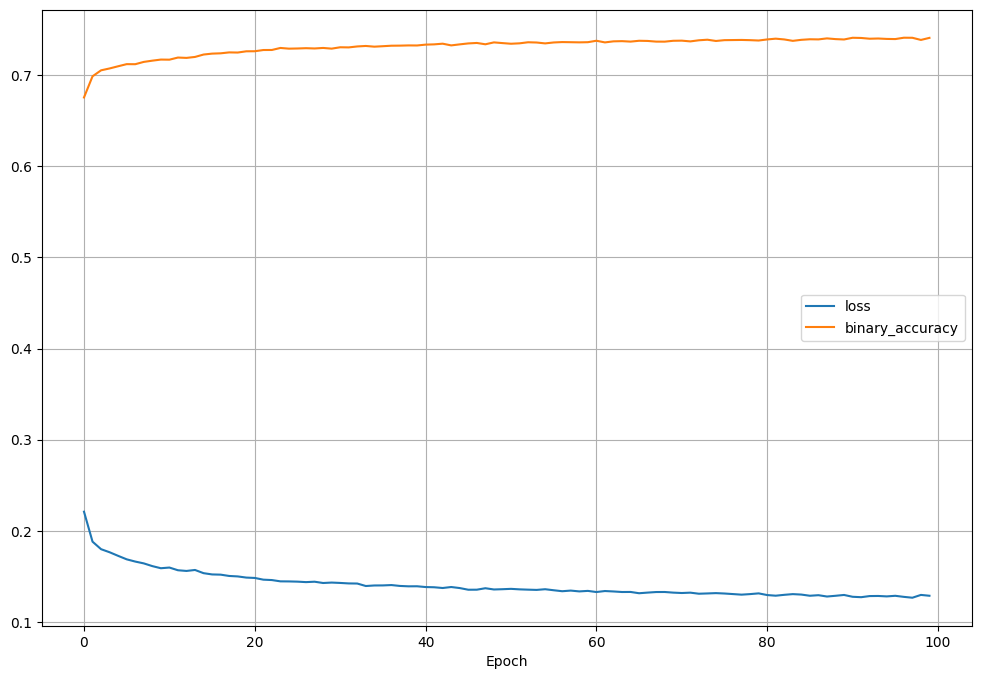

In [ ]:
pd.DataFrame(history.history).plot(figsize=(12, 8),
                                   grid=True,
                                   xlabel='Epoch',
                                   )

In [ ]:
y_pred = model_conv.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error Cuadrático Medio (MSE): {mse:.5f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.5f}")
print(f"Error Absoluto Medio (MAE): {mae:.5f}")
print(f"R cuadrado (R^2): {r2:.2f}")

49/49 [==============================] - 1s 9ms/step
Error Cuadrático Medio (MSE): 0.14123
Raíz del Error Cuadrático Medio (RMSE): 0.37580
Error Absoluto Medio (MAE): 0.21563
R cuadrado (R^2): 0.55


El modelo convolutivo, a pesar de su arquitectura más compleja, presenta un \( R^2 \) de 0.55, lo que indica que hay margen de mejora en su capacidad predictiva. Es posible que se requieran ajustes adicionales en la arquitectura o en el proceso de entrenamiento para mejorar su rendimiento.
